In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import max, min

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
data_path = 'Data/cleaned_data'

In [4]:
df1 = spark.read.format("csv").option('header','true').load(data_path)

In [5]:
df1.createOrReplaceTempView('FrameId')

23/02/28 15:06:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
df_max_min = spark.sql("SELECT gameId, playId, AVG(prePenaltyPlayResult), count(frameId) as count_frames \
                        FROM (\
                        SELECT DISTINCT gameId, playId, prePenaltyPlayResult, frameId FROM FrameId)\
                        GROUP BY gameId, playId \
                        ORDER BY playId, count(frameId) DESC")
df_max_min = df_max_min.toPandas()

In [7]:
pd.set_option('display.max_columns', None)

<AxesSubplot:xlabel='count_frames', ylabel='avg(prePenaltyPlayResult)'>

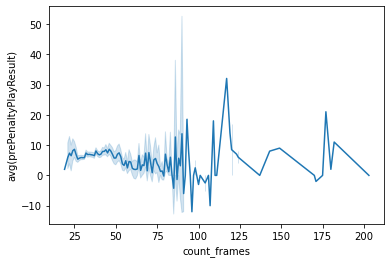

In [8]:
sns.lineplot(x='count_frames', y='avg(prePenaltyPlayResult)', data=df_max_min)

In [9]:
x = stats.pearsonr(df_max_min['count_frames'], df_max_min['avg(prePenaltyPlayResult)'])
x

(-0.0653074535590892, 2.3732777738060244e-09)

In [10]:
df1.createOrReplaceTempView('pass_cov')
df_pass_cov = spark.sql("SELECT gameId, playId, pff_passCoverage, prePenaltyPlayResult, passResult, playResult\
                        FROM ( \
                        SELECT DISTINCT gameId, playId, pff_passCoverage, prePenaltyPlayResult, passResult, playResult\
                        FROM pass_cov \
                        GROUP BY gameId, playId, pff_passCoverage, prePenaltyPlayResult, passResult, playResult \
                        ORDER BY pff_passCoverage, prePenaltyPlayResult, playResult) \
                       ")
df_pass_cov.show()

+----------+------+----------------+--------------------+----------+----------+
|    gameId|playId|pff_passCoverage|prePenaltyPlayResult|passResult|playResult|
+----------+------+----------------+--------------------+----------+----------+
|2021101708|  2939|           2-Man|                  -1|         S|        -1|
|2021100301|  1112|           2-Man|                 -10|         S|       -10|
|2021091905|  3553|           2-Man|                 -10|         S|       -10|
|2021102405|  2903|           2-Man|                 -10|         S|       -10|
|2021102500|  3945|           2-Man|                 -10|         S|       -10|
|2021101703|  3773|           2-Man|                 -11|         S|       -11|
|2021091211|   902|           2-Man|                 -11|         S|       -11|
|2021100305|  3091|           2-Man|                  -3|         C|        -3|
|2021102405|   507|           2-Man|                  -5|         S|        -5|
|2021100311|  1312|           2-Man|    

In [11]:
df_pass_cov = df_pass_cov.toPandas()
df_pass_cov

,gameId,playId,pff_passCoverage,prePenaltyPlayResult,passResult,playResult
0,2021101708,2939,2-Man,-1,S,-1
1,2021091905,3553,2-Man,-10,S,-10
2,2021100301,1112,2-Man,-10,S,-10
3,2021102405,2903,2-Man,-10,S,-10
4,2021102500,3945,2-Man,-10,S,-10
...,...,...,...,...,...,...
8336,2021101701,2212,Red Zone,9,C,9
8337,2021101708,3160,Red Zone,9,C,9
8338,2021102406,1870,Red Zone,9,C,9
8339,2021103105,762,Red Zone,9,C,9


In [12]:
df_pass_cov['prePenaltyPlayResult'] = df_pass_cov['prePenaltyPlayResult'].astype(int)
df_pass_cov['playResult'] = df_pass_cov['playResult'].astype(int)


In [13]:
df_pass_cov.sort_values(by=['prePenaltyPlayResult', 'playResult'], inplace=True)

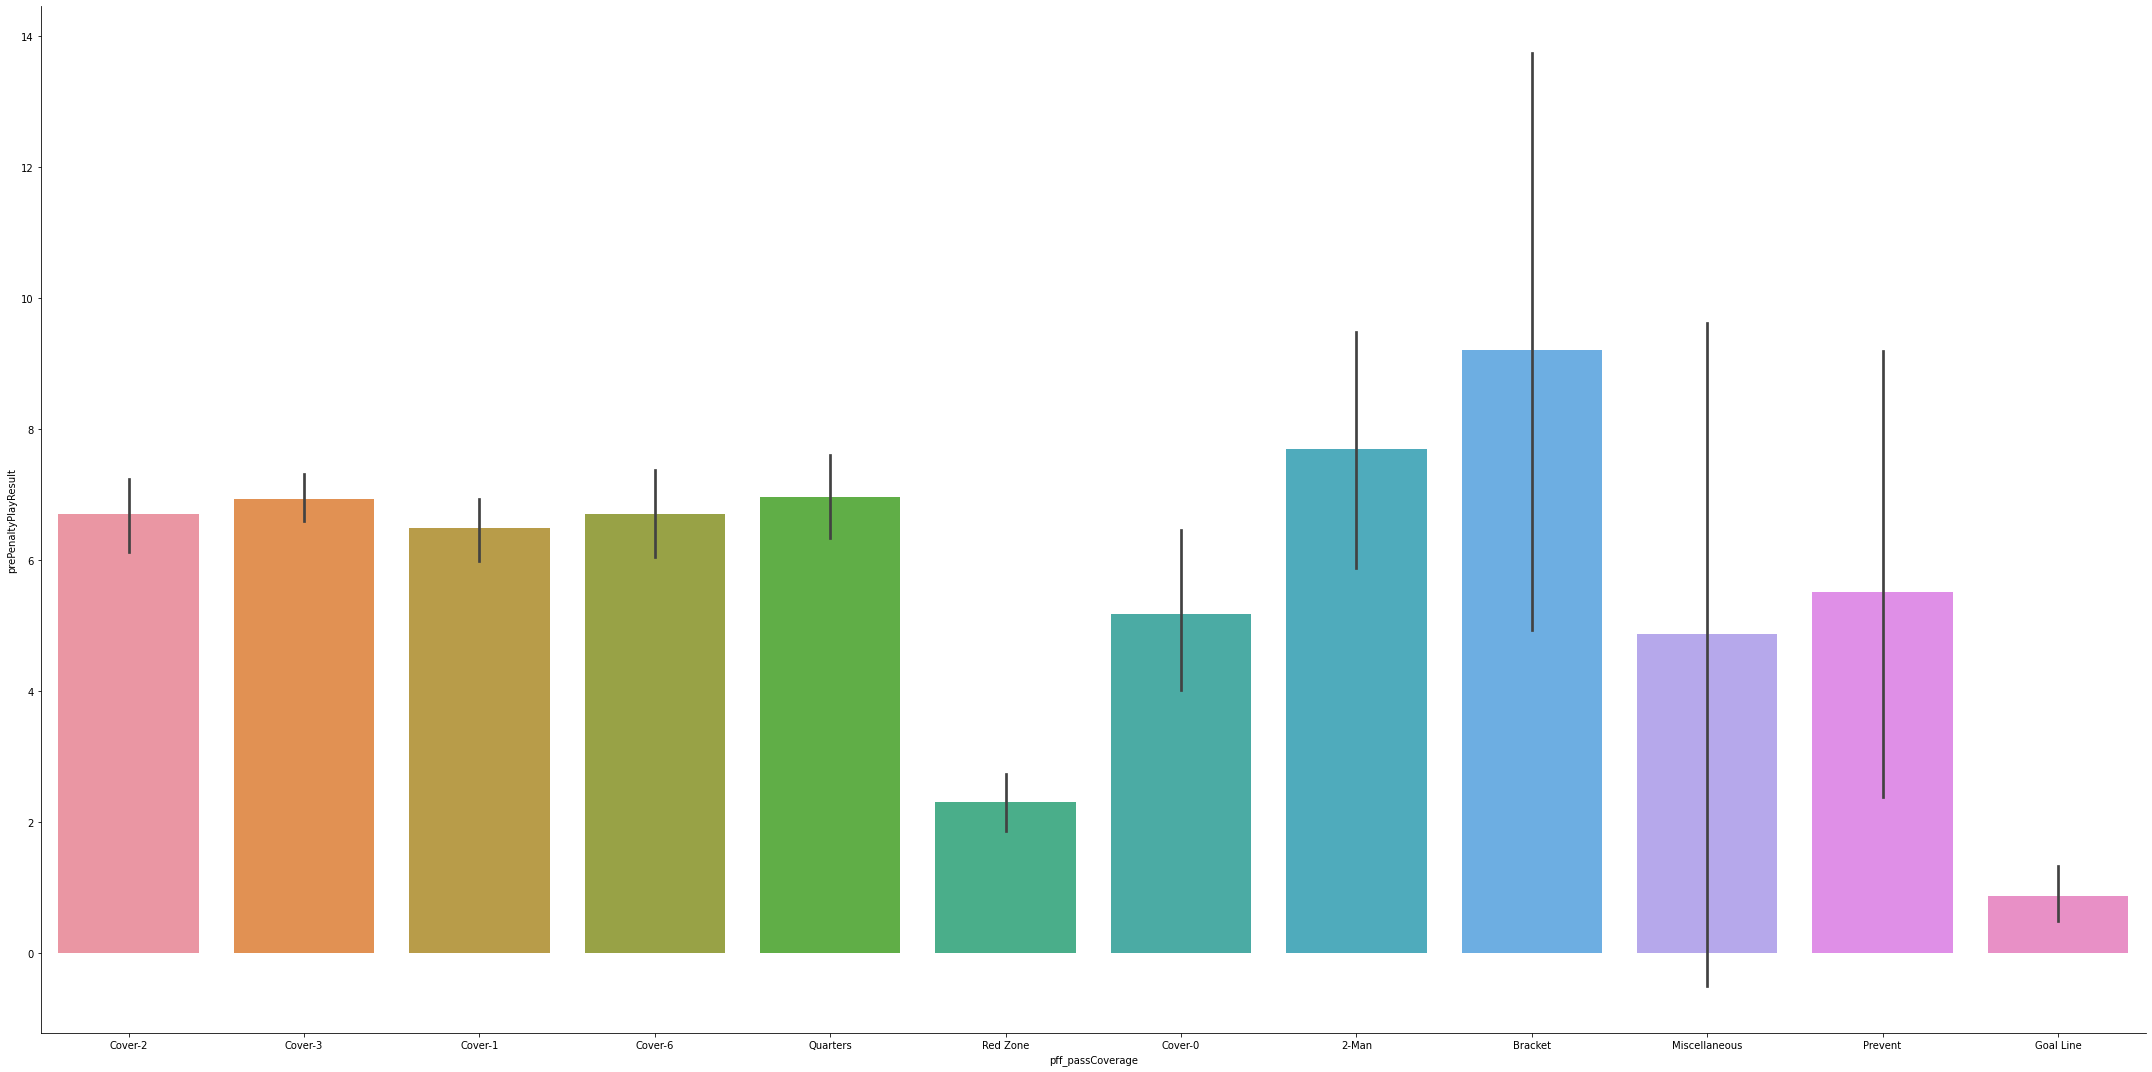

In [14]:
sns.catplot(x='pff_passCoverage', y='prePenaltyPlayResult', kind='bar',data=df_pass_cov, height=15, aspect=2)

In [15]:
df1.createOrReplaceTempView('eda_cov')
df_eda_cov = spark.sql("SELECT gameId, playId, pff_blockType, yardsToGo,pff_passCoverageType,preSnapHomeScore,offenseFormation,defendersInBox,dropBackType,preSnapVisitorScore,prePenaltyPlayResult, passResult, playResult,\
                        preSnapHomeScore - preSnapVisitorScore as hometeamupdown\
                        FROM ( \
                        SELECT gameId, playId, pff_blockType,yardsToGo,pff_passCoverageType, preSnapHomeScore,preSnapVisitorScore,dropBackType,defendersInBox,offenseFormation,prePenaltyPlayResult, passResult, playResult\
                        FROM pass_cov \
                        GROUP BY gameId, playId, pff_blockType,yardsToGo,pff_passCoverageType, preSnapHomeScore,preSnapVisitorScore,dropBackType,defendersInBox,offenseFormation,prePenaltyPlayResult, passResult, playResult \
                        ORDER BY yardsToGo, preSnapHomeScore, defendersInBox, preSnapVisitorScore, prePenaltyPlayResult, playResult\
                      )")
df_eda_cov = df_eda_cov.toPandas()
df_eda_cov

,gameId,playId,pff_blockType,yardsToGo,pff_passCoverageType,preSnapHomeScore,offenseFormation,defendersInBox,dropBackType,preSnapVisitorScore,prePenaltyPlayResult,passResult,playResult,hometeamupdown
0,2021092604,1330,PT,0,Other,0,SHOTGUN,11.0,None,12,0,C,0,-12.0
1,2021092604,1330,PP,0,Other,0,SHOTGUN,11.0,None,12,0,C,0,-12.0
2,2021092604,1330,None,0,Other,0,SHOTGUN,11.0,None,12,0,C,0,-12.0
3,2021103103,2868,PP,0,Other,10,EMPTY,4.0,None,9,0,I,0,1.0
4,2021103103,2868,None,0,Other,10,EMPTY,4.0,None,9,0,I,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30631,2021102401,1007,PT,9,Zone,7,EMPTY,8.0,TRADITIONAL,7,10,C,10,0.0
30632,2021102401,1007,PP,9,Zone,7,EMPTY,8.0,TRADITIONAL,7,10,C,10,0.0
30633,2021091202,1885,None,9,Man,9,SHOTGUN,5.0,TRADITIONAL,0,14,C,14,9.0
30634,2021091202,1885,PP,9,Man,9,SHOTGUN,5.0,TRADITIONAL,0,14,C,14,9.0


In [16]:
# df_eda_cov['defendersInBox'] = df_eda_cov.astype({'defendersInBox':'int'})
df_eda_cov['defendersInBox'].value_counts()

df_eda_cov.loc[df_eda_cov["defendersInBox"] == "1.0", "defendersInBox"] = int(1)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "2.0", "defendersInBox"] = int(2)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "3.0", "defendersInBox"] = int(3)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "4.0", "defendersInBox"] = int(4)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "5.0", "defendersInBox"] = int(5)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "6.0", "defendersInBox"] = int(6)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "7.0", "defendersInBox"] = int(7)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "8.0", "defendersInBox"] = int(8)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "9.0", "defendersInBox"] = int(9)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "10.0", "defendersInBox"] = int(10)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "11.0", "defendersInBox"] = int(11)

df_eda_cov.dtypes

gameId                   object
playId                   object
pff_blockType            object
yardsToGo                object
pff_passCoverageType     object
preSnapHomeScore         object
offenseFormation         object
defendersInBox           object
dropBackType             object
preSnapVisitorScore      object
prePenaltyPlayResult     object
passResult               object
playResult               object
hometeamupdown          float64
dtype: object

In [17]:

df_eda_cov['defendersInBox'] = pd.to_numeric(df_eda_cov['defendersInBox'])

df_eda_cov.dtypes

gameId                   object
playId                   object
pff_blockType            object
yardsToGo                object
pff_passCoverageType     object
preSnapHomeScore         object
offenseFormation         object
defendersInBox          float64
dropBackType             object
preSnapVisitorScore      object
prePenaltyPlayResult     object
passResult               object
playResult               object
hometeamupdown          float64
dtype: object

In [18]:
df_eda_cov['yardsToGo'] = df_eda_cov['yardsToGo'].astype(int)
df_eda_cov['preSnapHomeScore'] = df_eda_cov['preSnapHomeScore'].astype(int)
# df_eda_cov['defendersInBox'] = df_eda_cov['defendersInBox'].astype(int)
df_eda_cov['preSnapVisitorScore'] = df_eda_cov['preSnapVisitorScore'].astype(int)
df_eda_cov['prePenaltyPlayResult'] = df_eda_cov['prePenaltyPlayResult'].astype(int)
df_eda_cov['playResult'] = df_eda_cov['playResult'].astype(int)

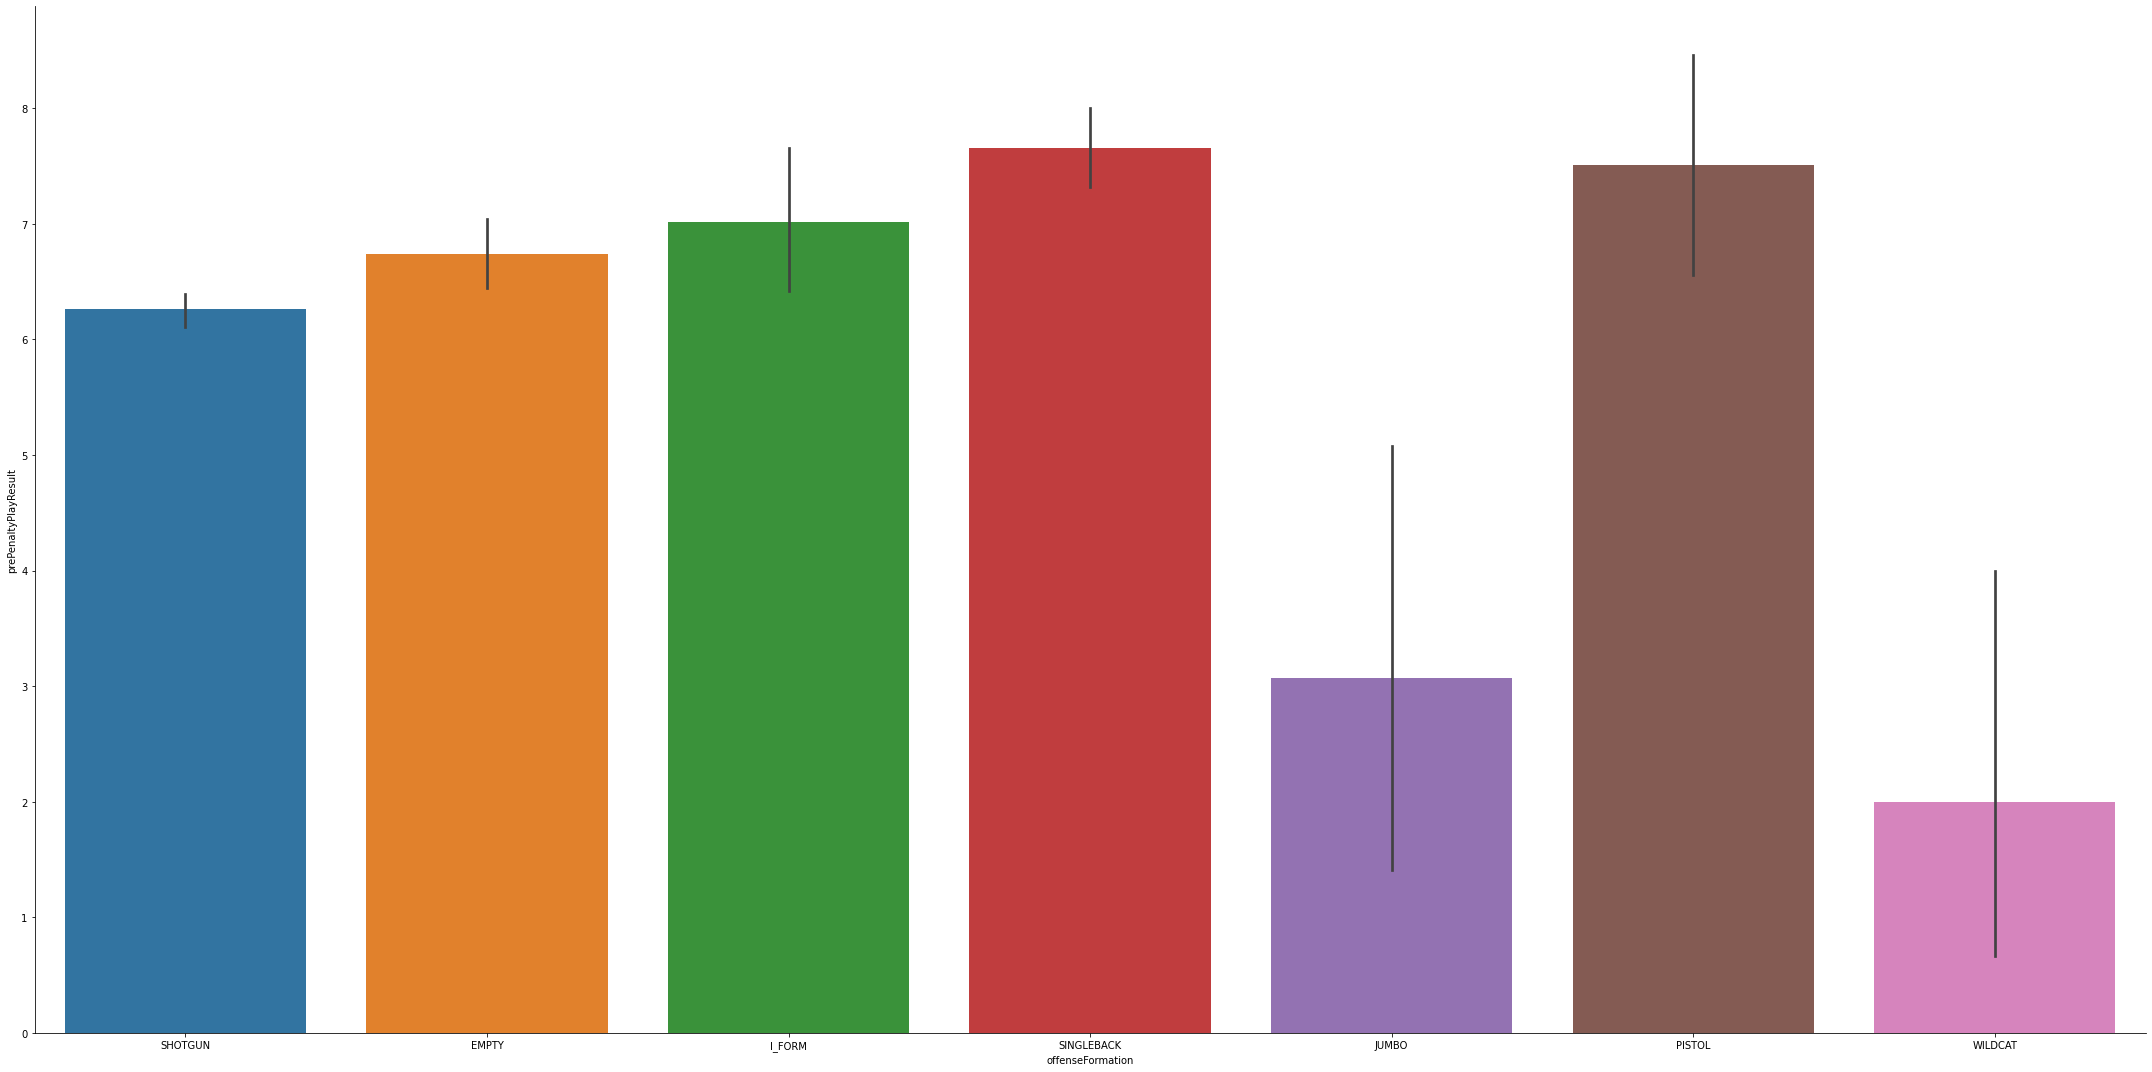

In [19]:
sns.catplot(x='offenseFormation', y='prePenaltyPlayResult', kind='bar',data=df_eda_cov, height=15, aspect=2)

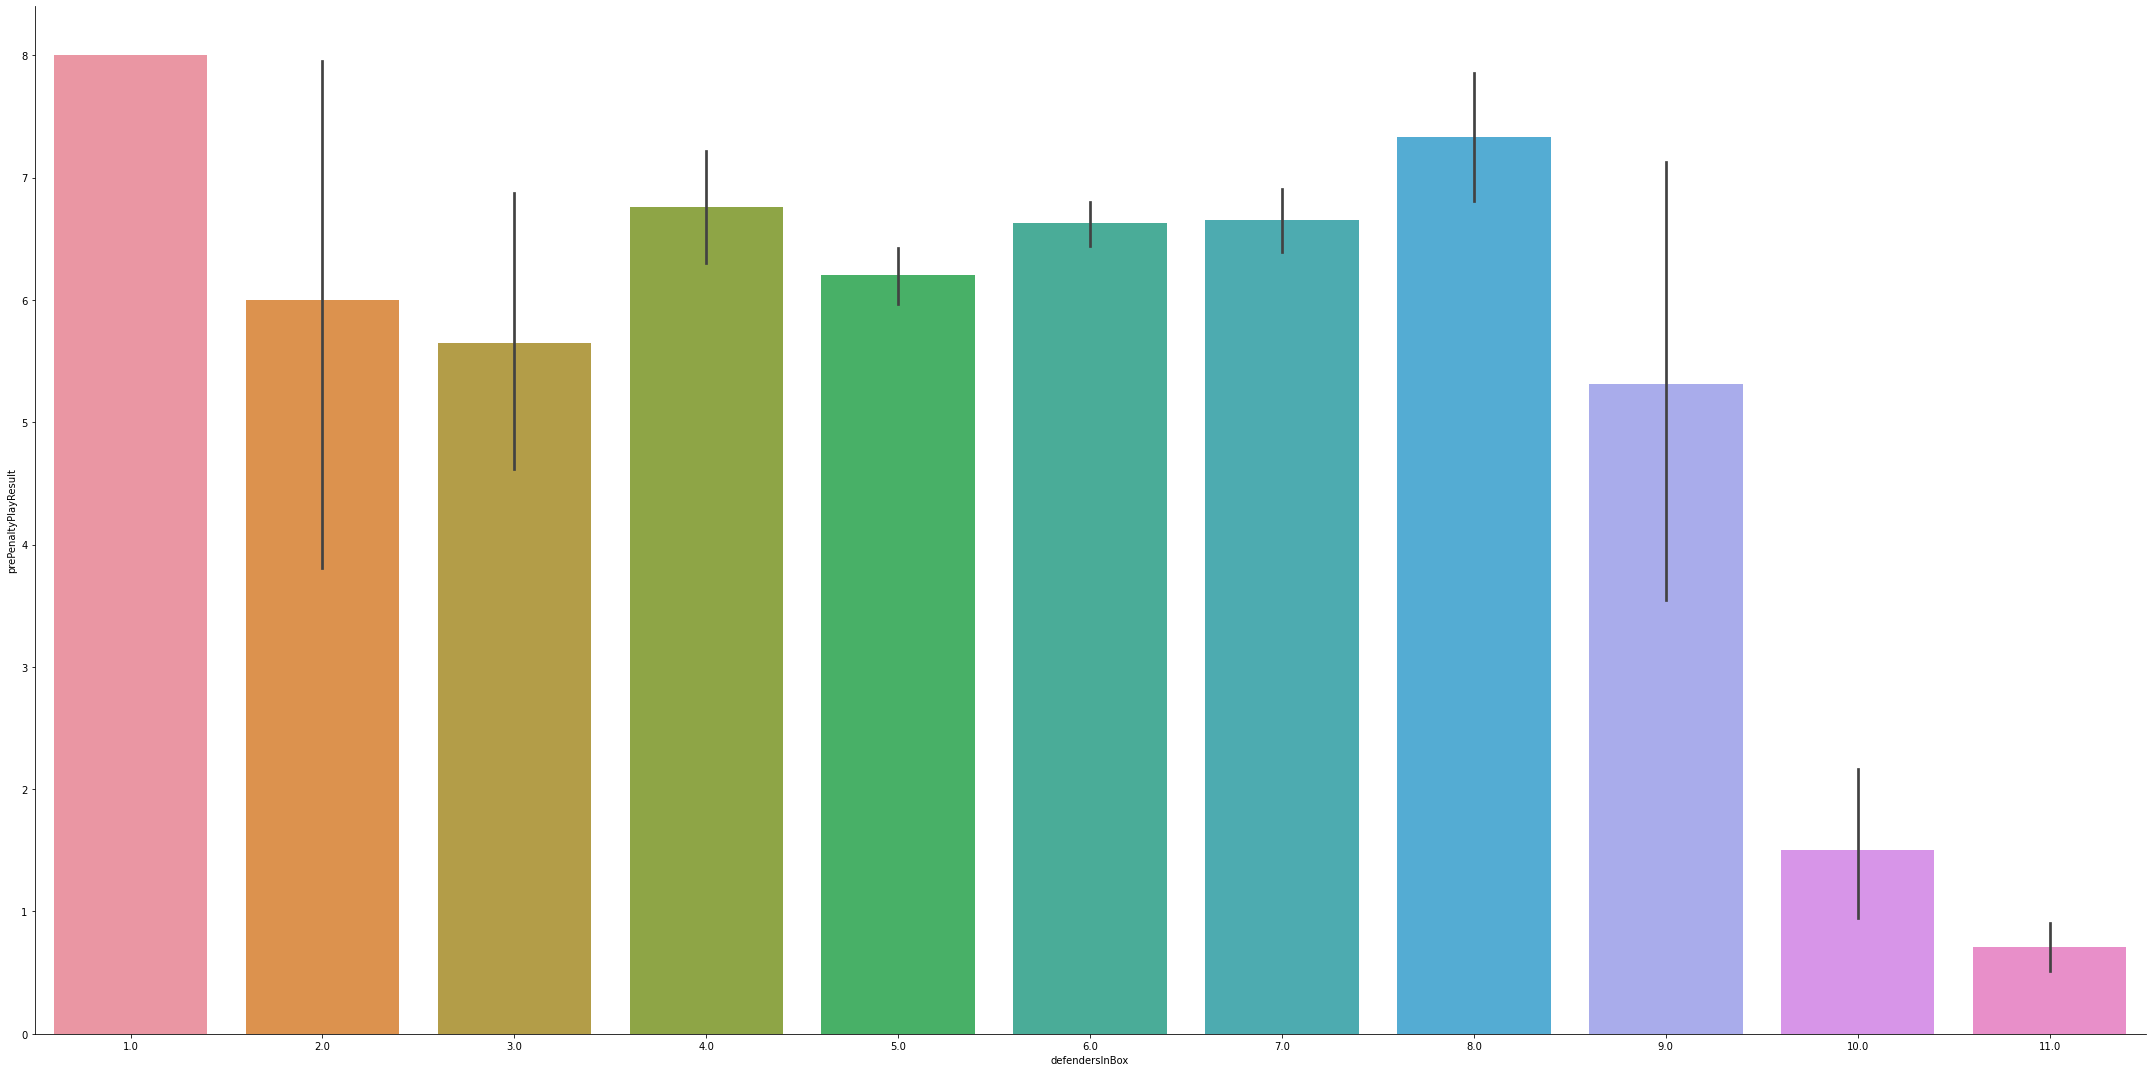

In [20]:
sns.catplot(x='defendersInBox', y='prePenaltyPlayResult', kind='bar',data=df_eda_cov, height=15, aspect=2)

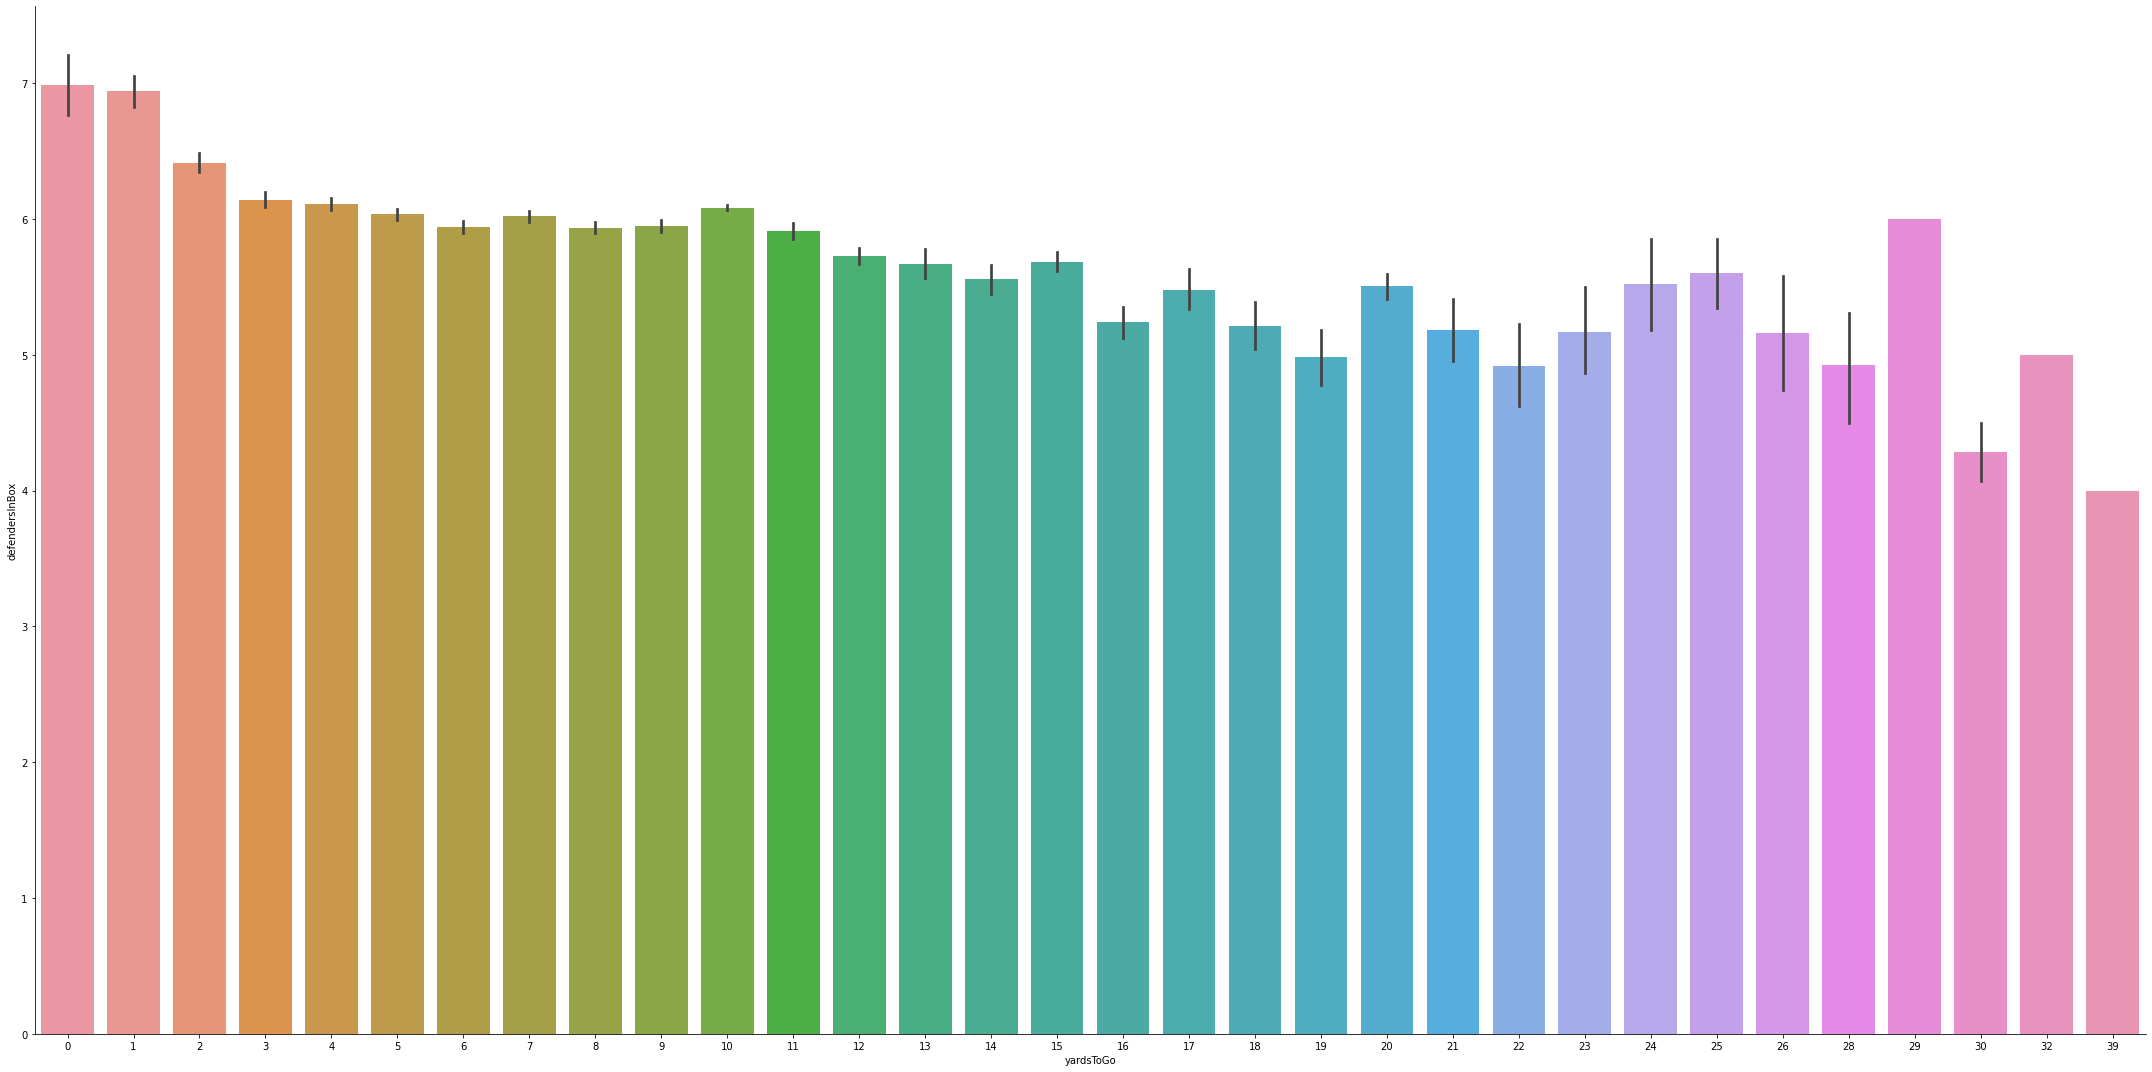

In [21]:
sns.catplot(x='yardsToGo', y='defendersInBox', kind='bar',data=df_eda_cov, height=15, aspect=2)

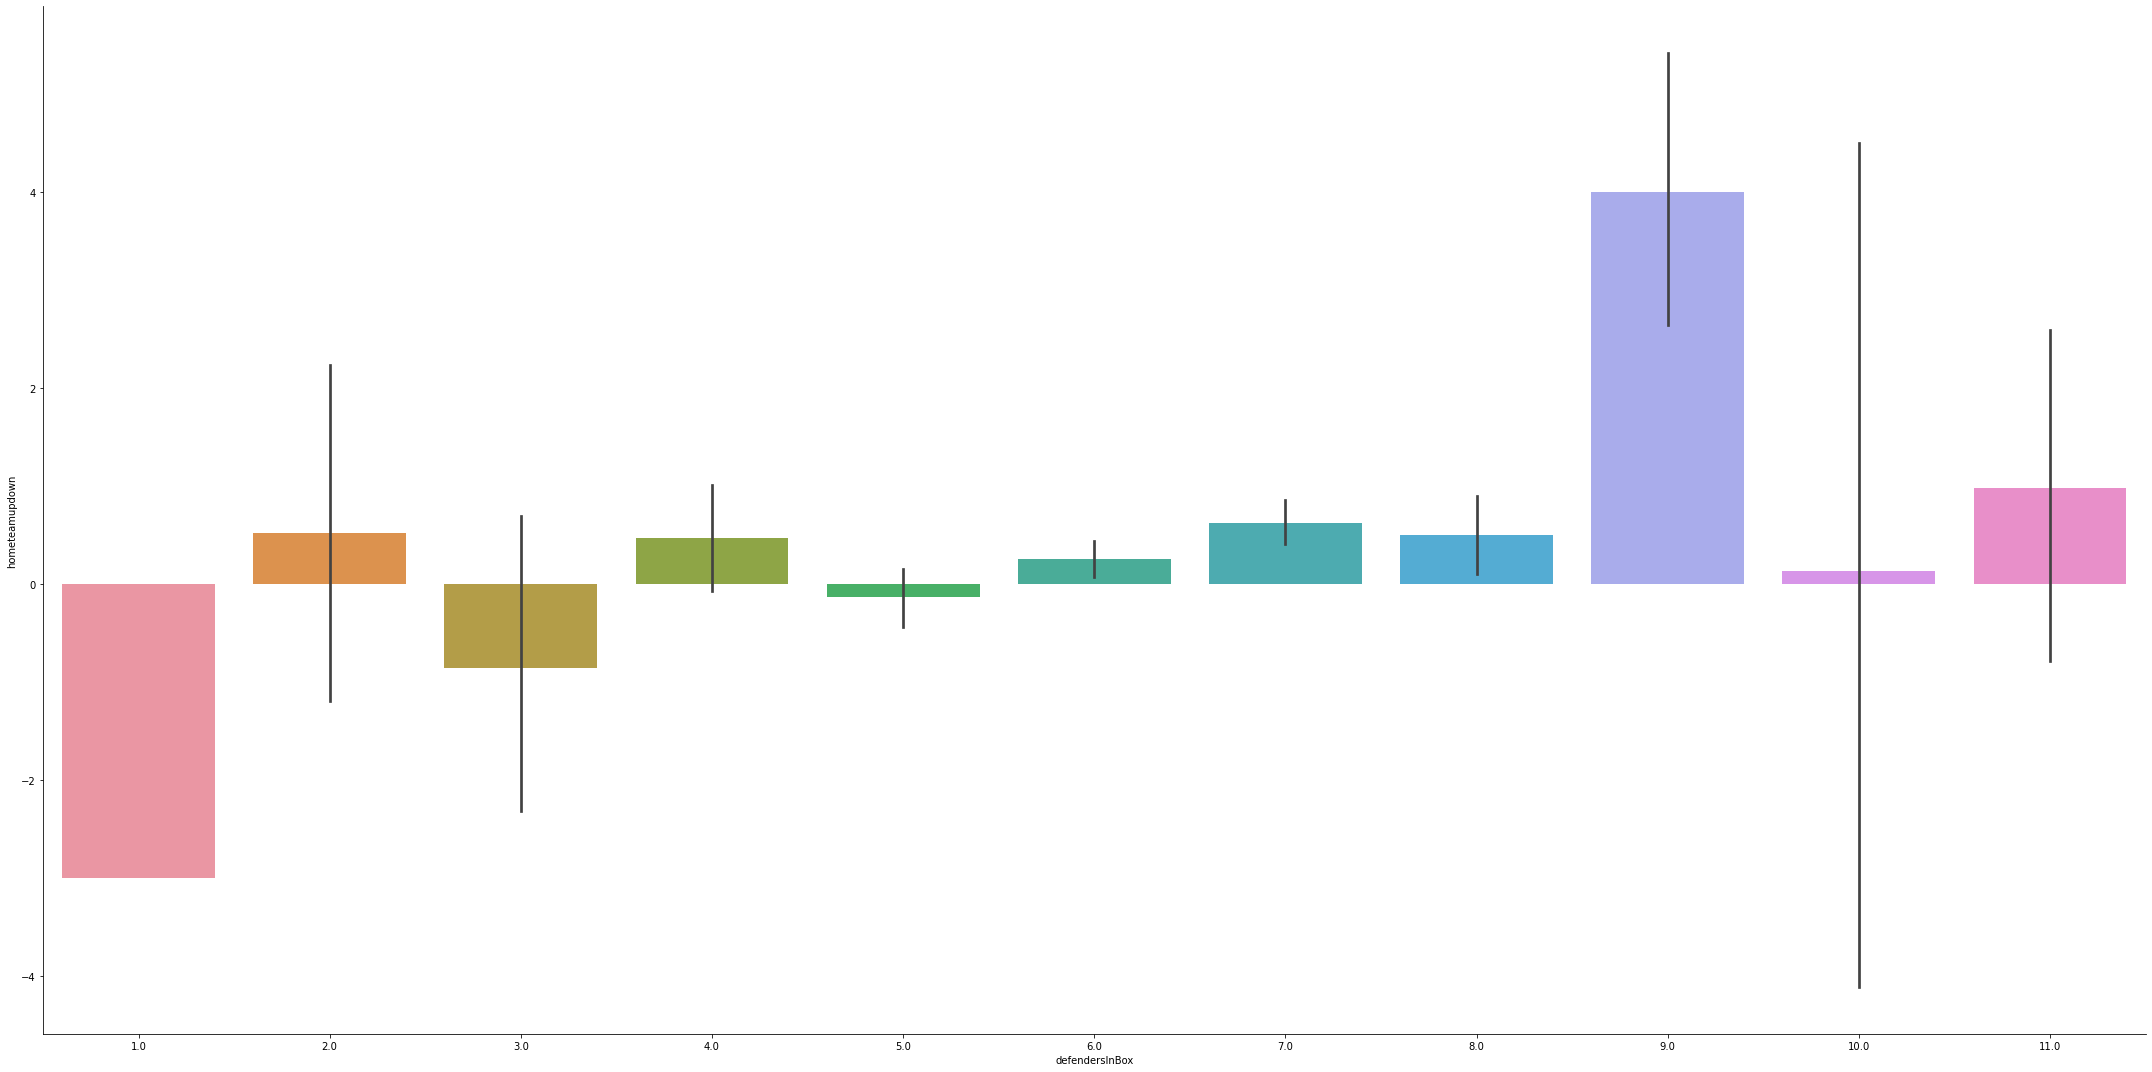

In [22]:
sns.catplot(x='defendersInBox', y='hometeamupdown', kind='bar',data=df_eda_cov, height=15, aspect=2)

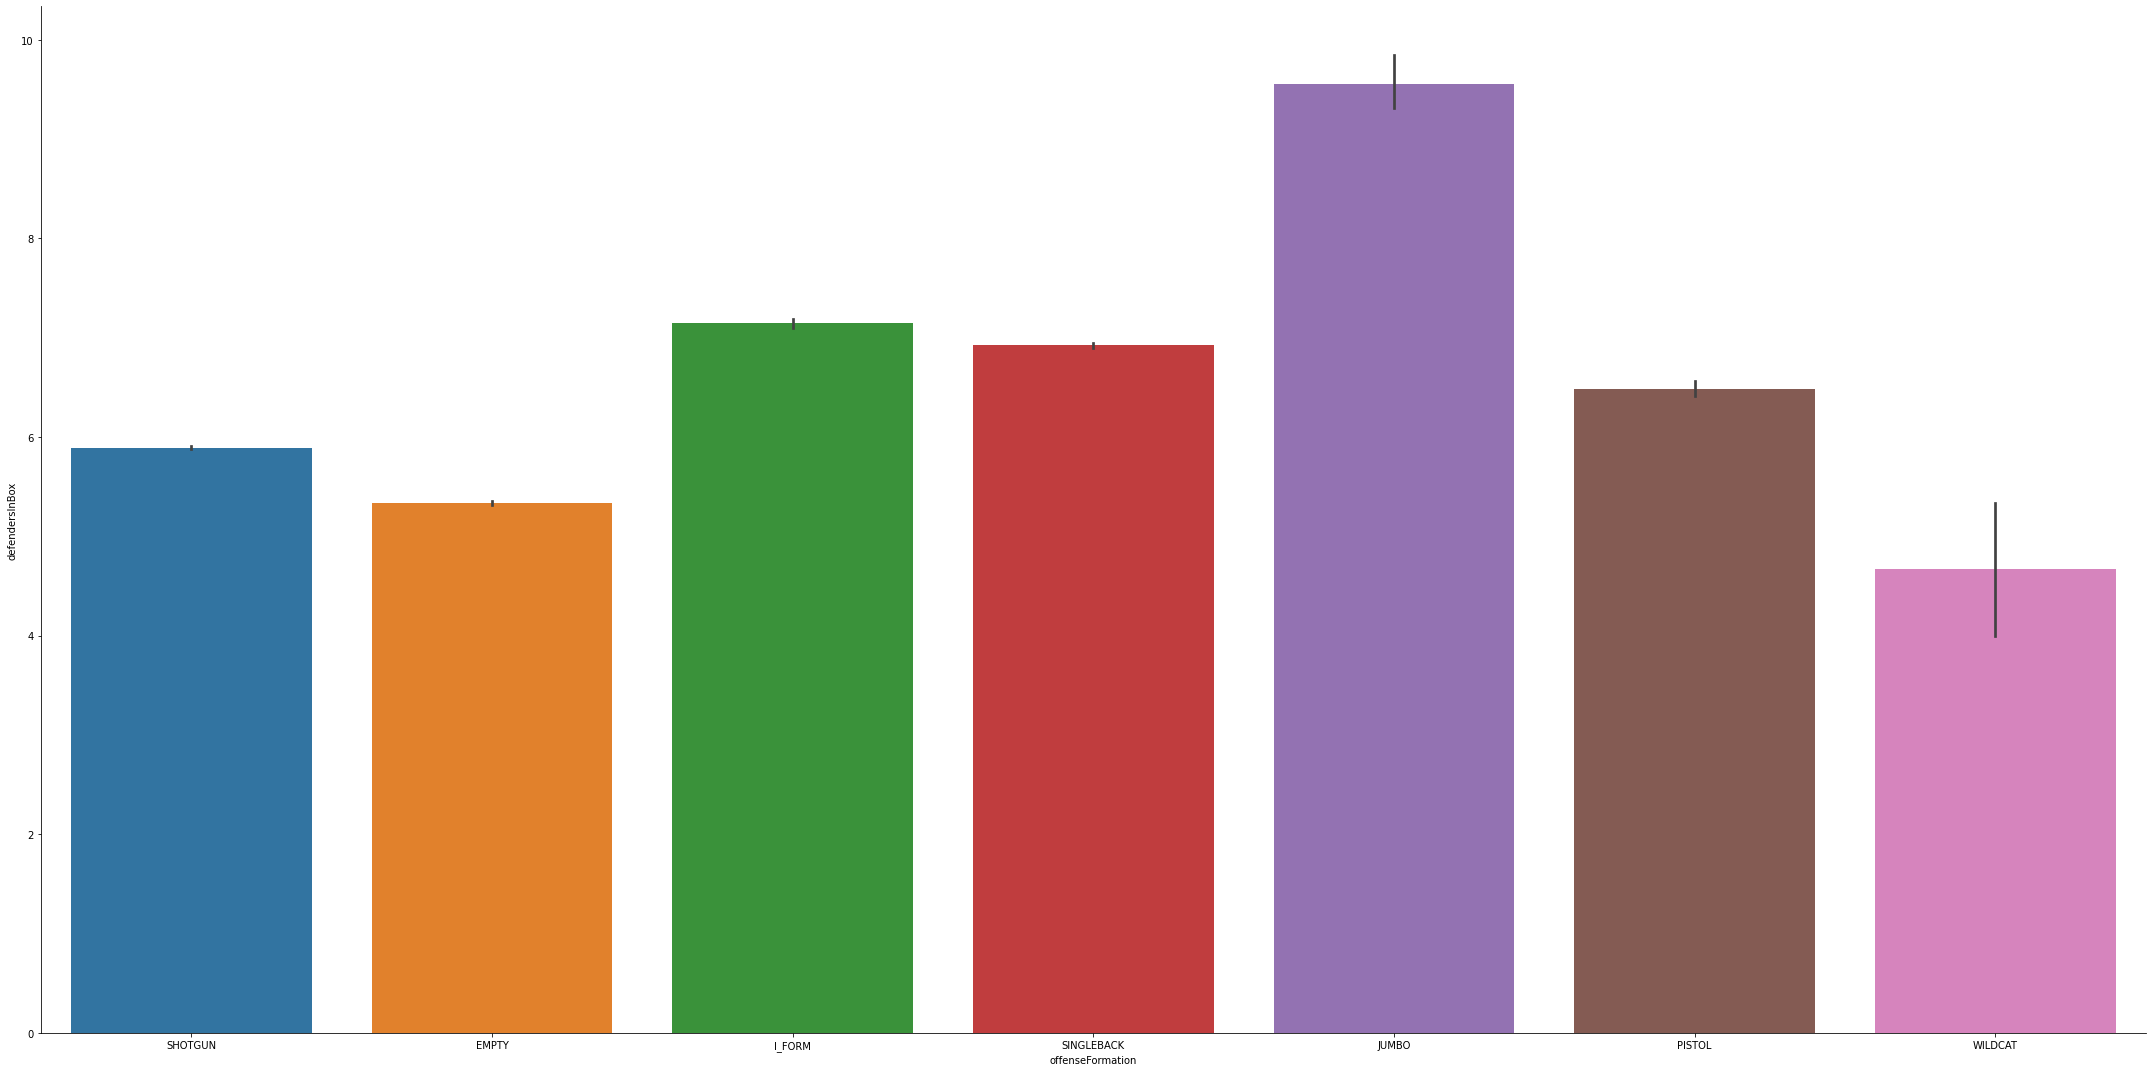

In [23]:
sns.catplot(x='offenseFormation', y='defendersInBox', kind='bar',data=df_eda_cov, height=15, aspect=2)

In [24]:
df_eda_cov_dummy = pd.get_dummies(data=df_eda_cov, columns=['pff_blockType', 'pff_passCoverageType', 'offenseFormation', 'dropBackType', 'passResult'])
df_eda_cov_dummy

,gameId,playId,yardsToGo,preSnapHomeScore,defendersInBox,preSnapVisitorScore,prePenaltyPlayResult,playResult,hometeamupdown,pff_blockType_BH,pff_blockType_CH,pff_blockType_CL,pff_blockType_NB,pff_blockType_PA,pff_blockType_PP,pff_blockType_PR,pff_blockType_PT,pff_blockType_PU,pff_blockType_SR,pff_blockType_SW,pff_blockType_UP,pff_passCoverageType_Man,pff_passCoverageType_Other,pff_passCoverageType_Zone,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT,dropBackType_DESIGNED_ROLLOUT_LEFT,dropBackType_DESIGNED_ROLLOUT_RIGHT,dropBackType_SCRAMBLE,dropBackType_SCRAMBLE_ROLLOUT_LEFT,dropBackType_SCRAMBLE_ROLLOUT_RIGHT,dropBackType_TRADITIONAL,dropBackType_UNKNOWN,passResult_C,passResult_I,passResult_IN,passResult_R,passResult_S
0,2021092604,1330,0,0,11.0,12,0,0,-12.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2021092604,1330,0,0,11.0,12,0,0,-12.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2021092604,1330,0,0,11.0,12,0,0,-12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2021103103,2868,0,10,4.0,9,0,0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2021103103,2868,0,10,4.0,9,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30631,2021102401,1007,9,7,8.0,7,10,10,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
30632,2021102401,1007,9,7,8.0,7,10,10,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
30633,2021091202,1885,9,9,5.0,0,14,14,9.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
30634,2021091202,1885,9,9,5.0,0,14,14,9.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0


<AxesSubplot:>

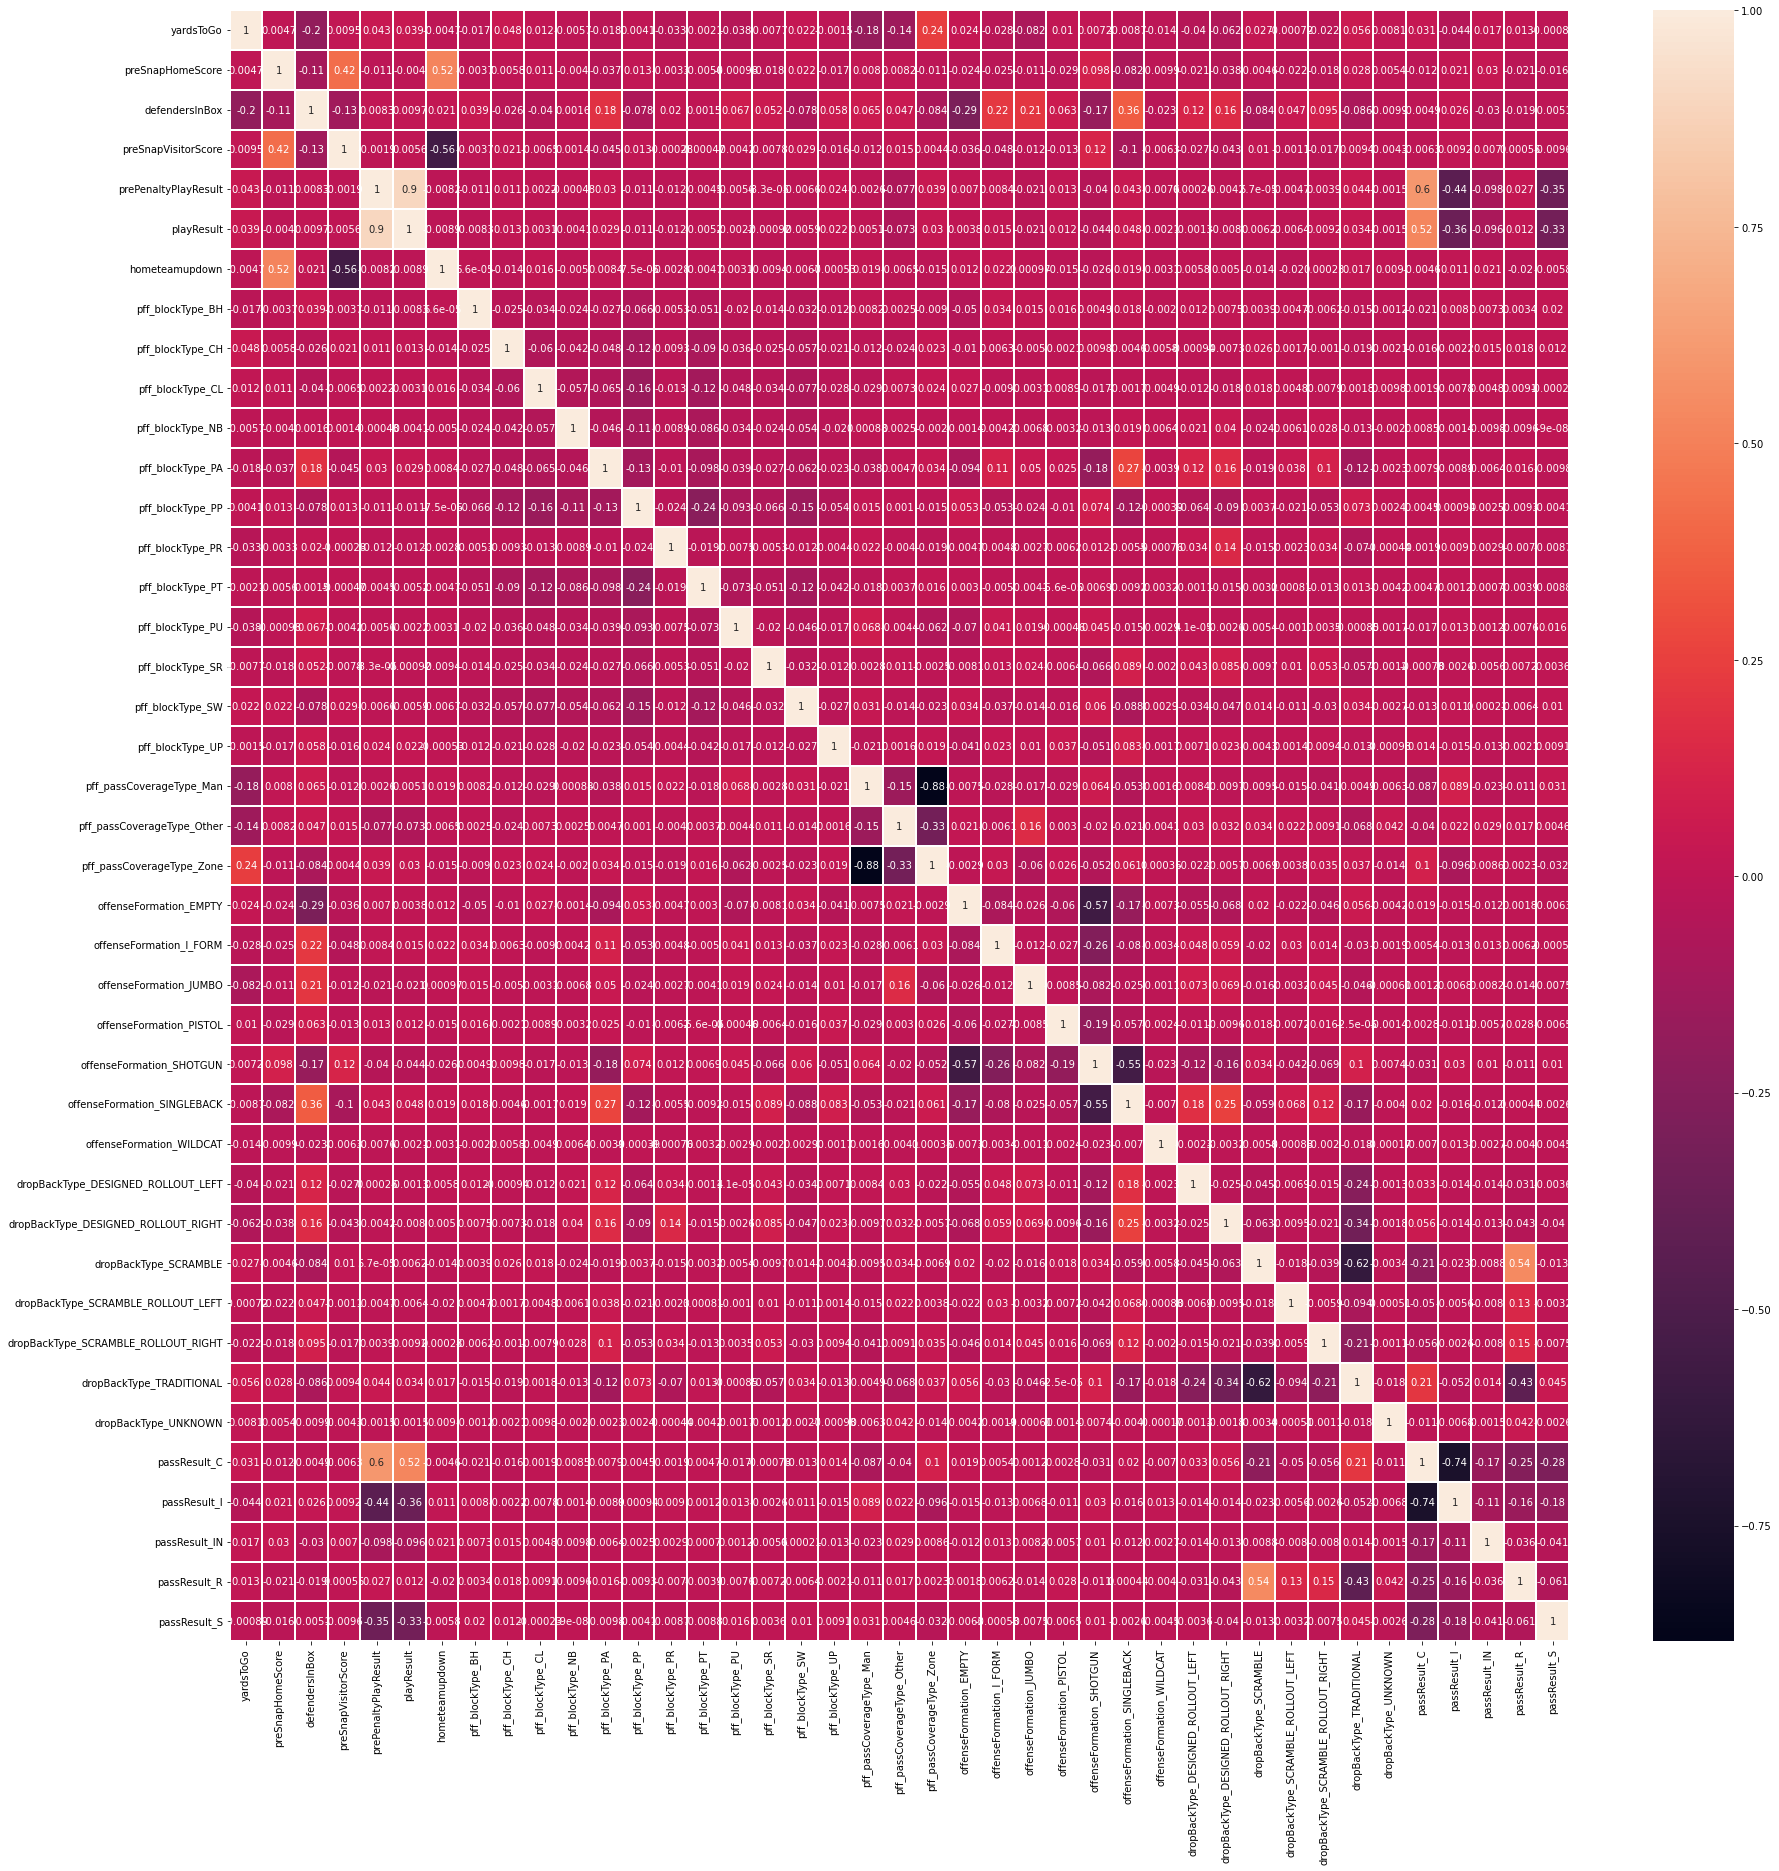

In [25]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(df_eda_cov_dummy.corr(),linewidths=.05, annot=True, ax=ax)

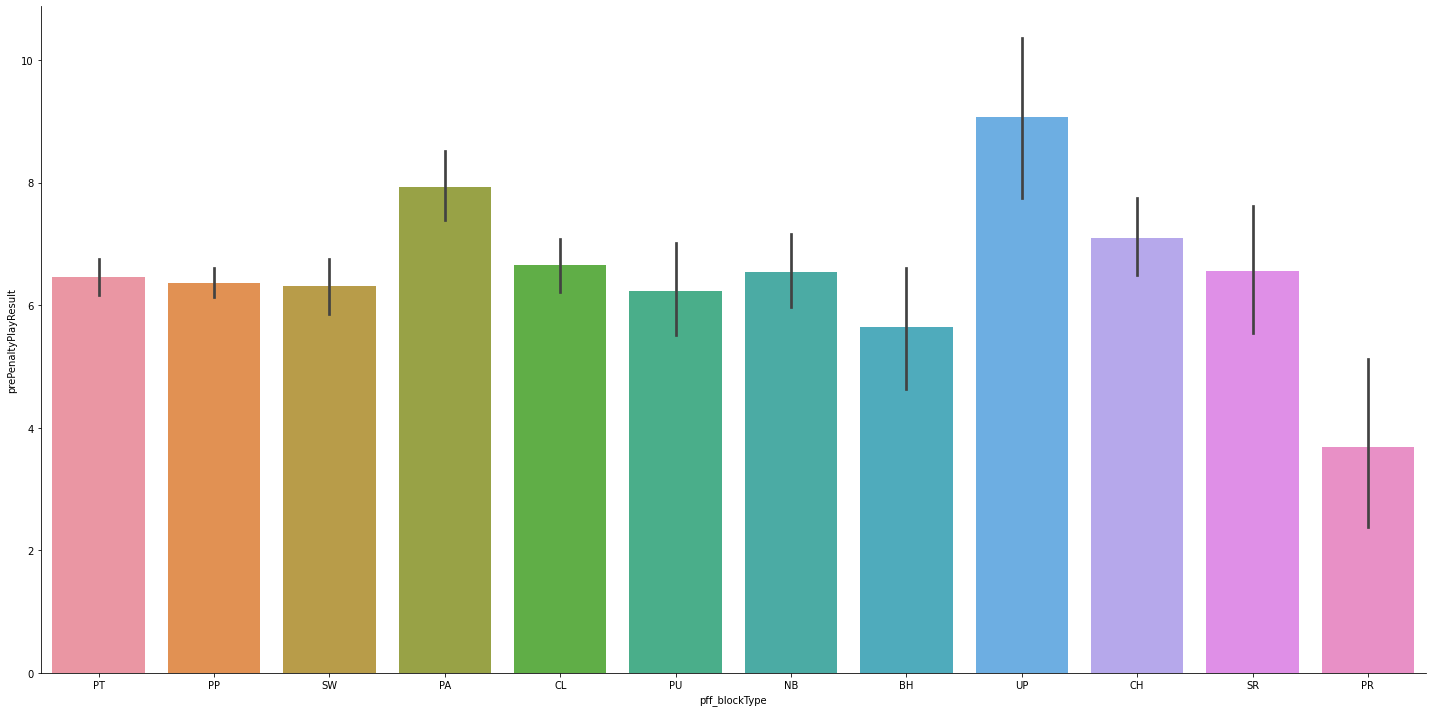

In [26]:
sns.catplot(x='pff_blockType', y='prePenaltyPlayResult', kind='bar',data=df_eda_cov, height=10, aspect=2)

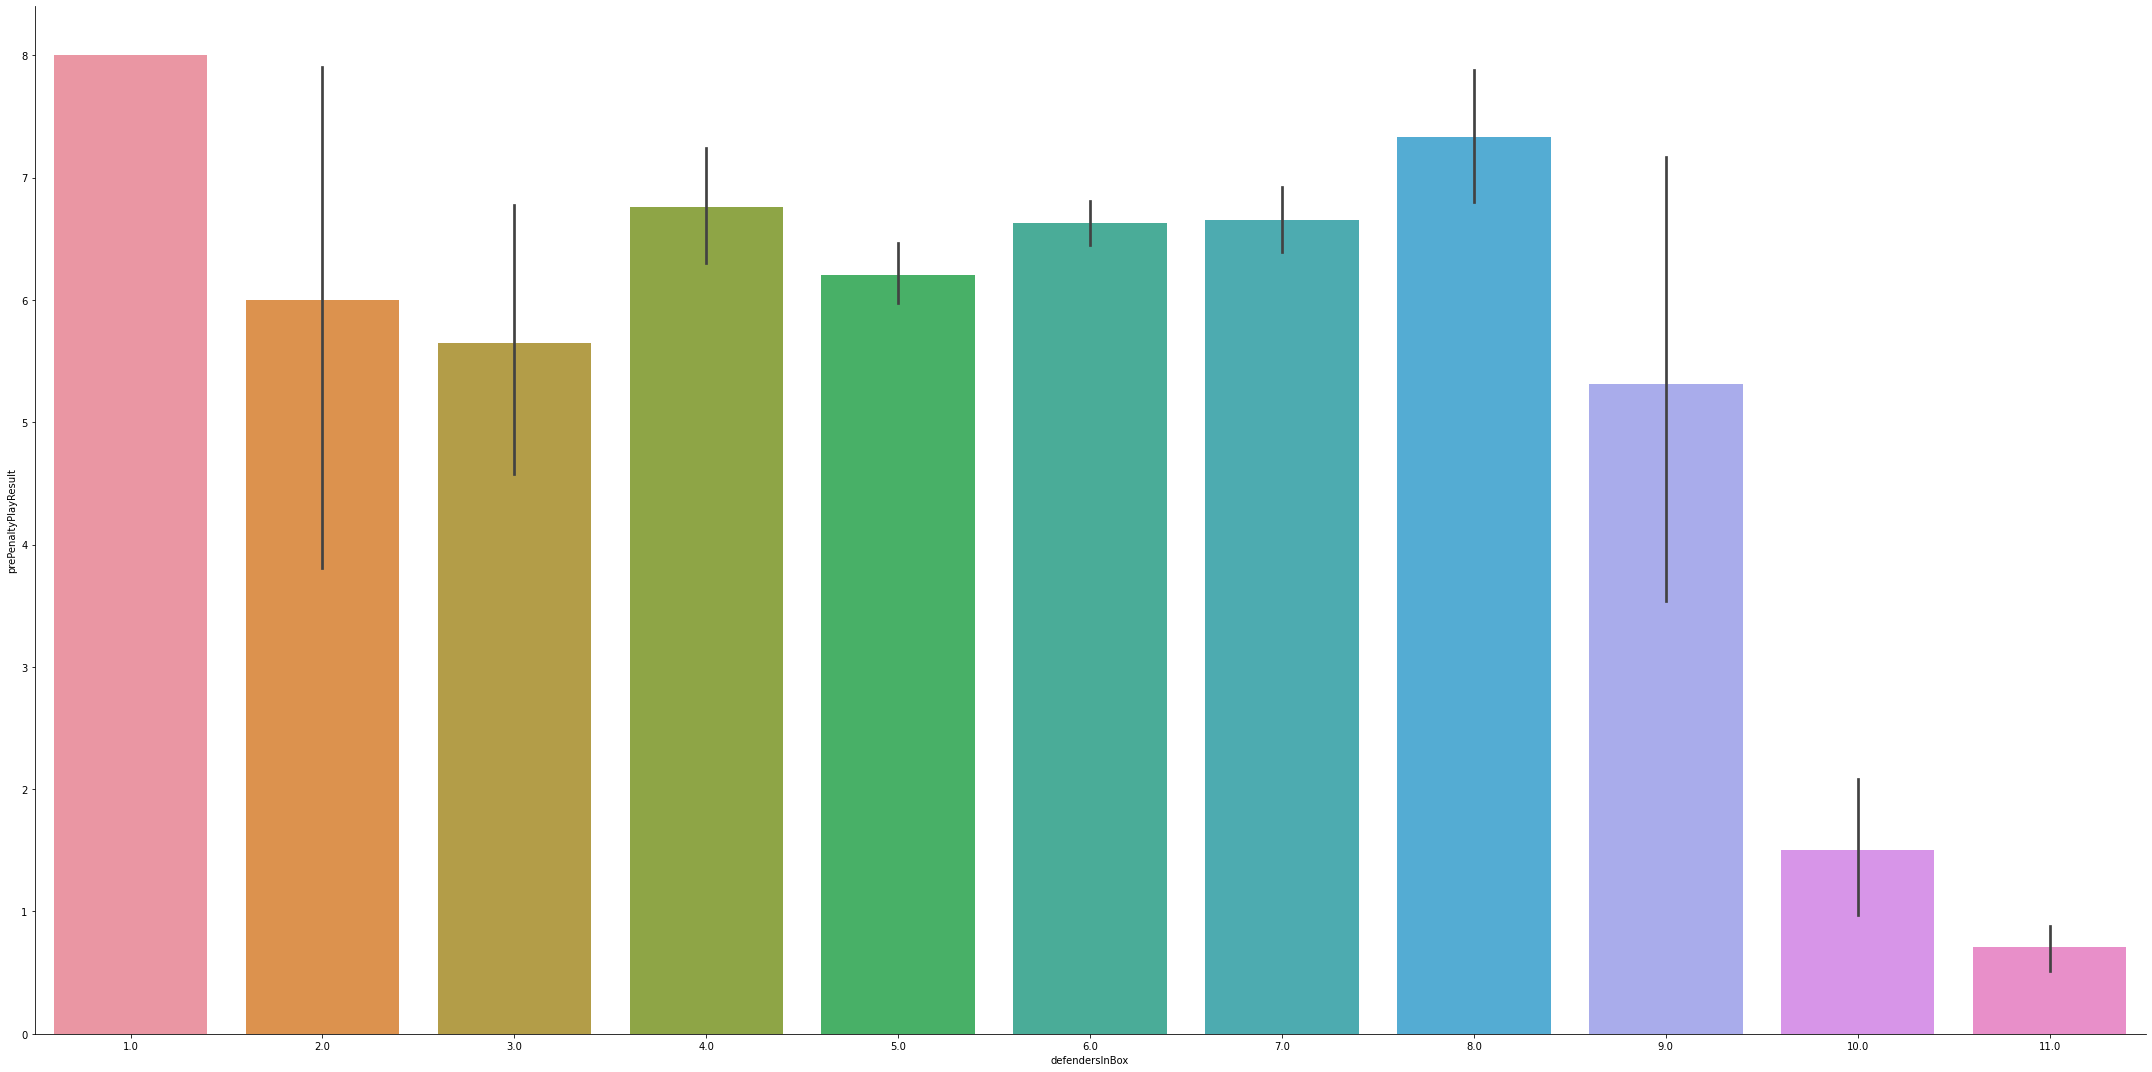

In [27]:
sns.catplot(x='defendersInBox', y='prePenaltyPlayResult', kind='bar',data=df_eda_cov, height=15, aspect=2)

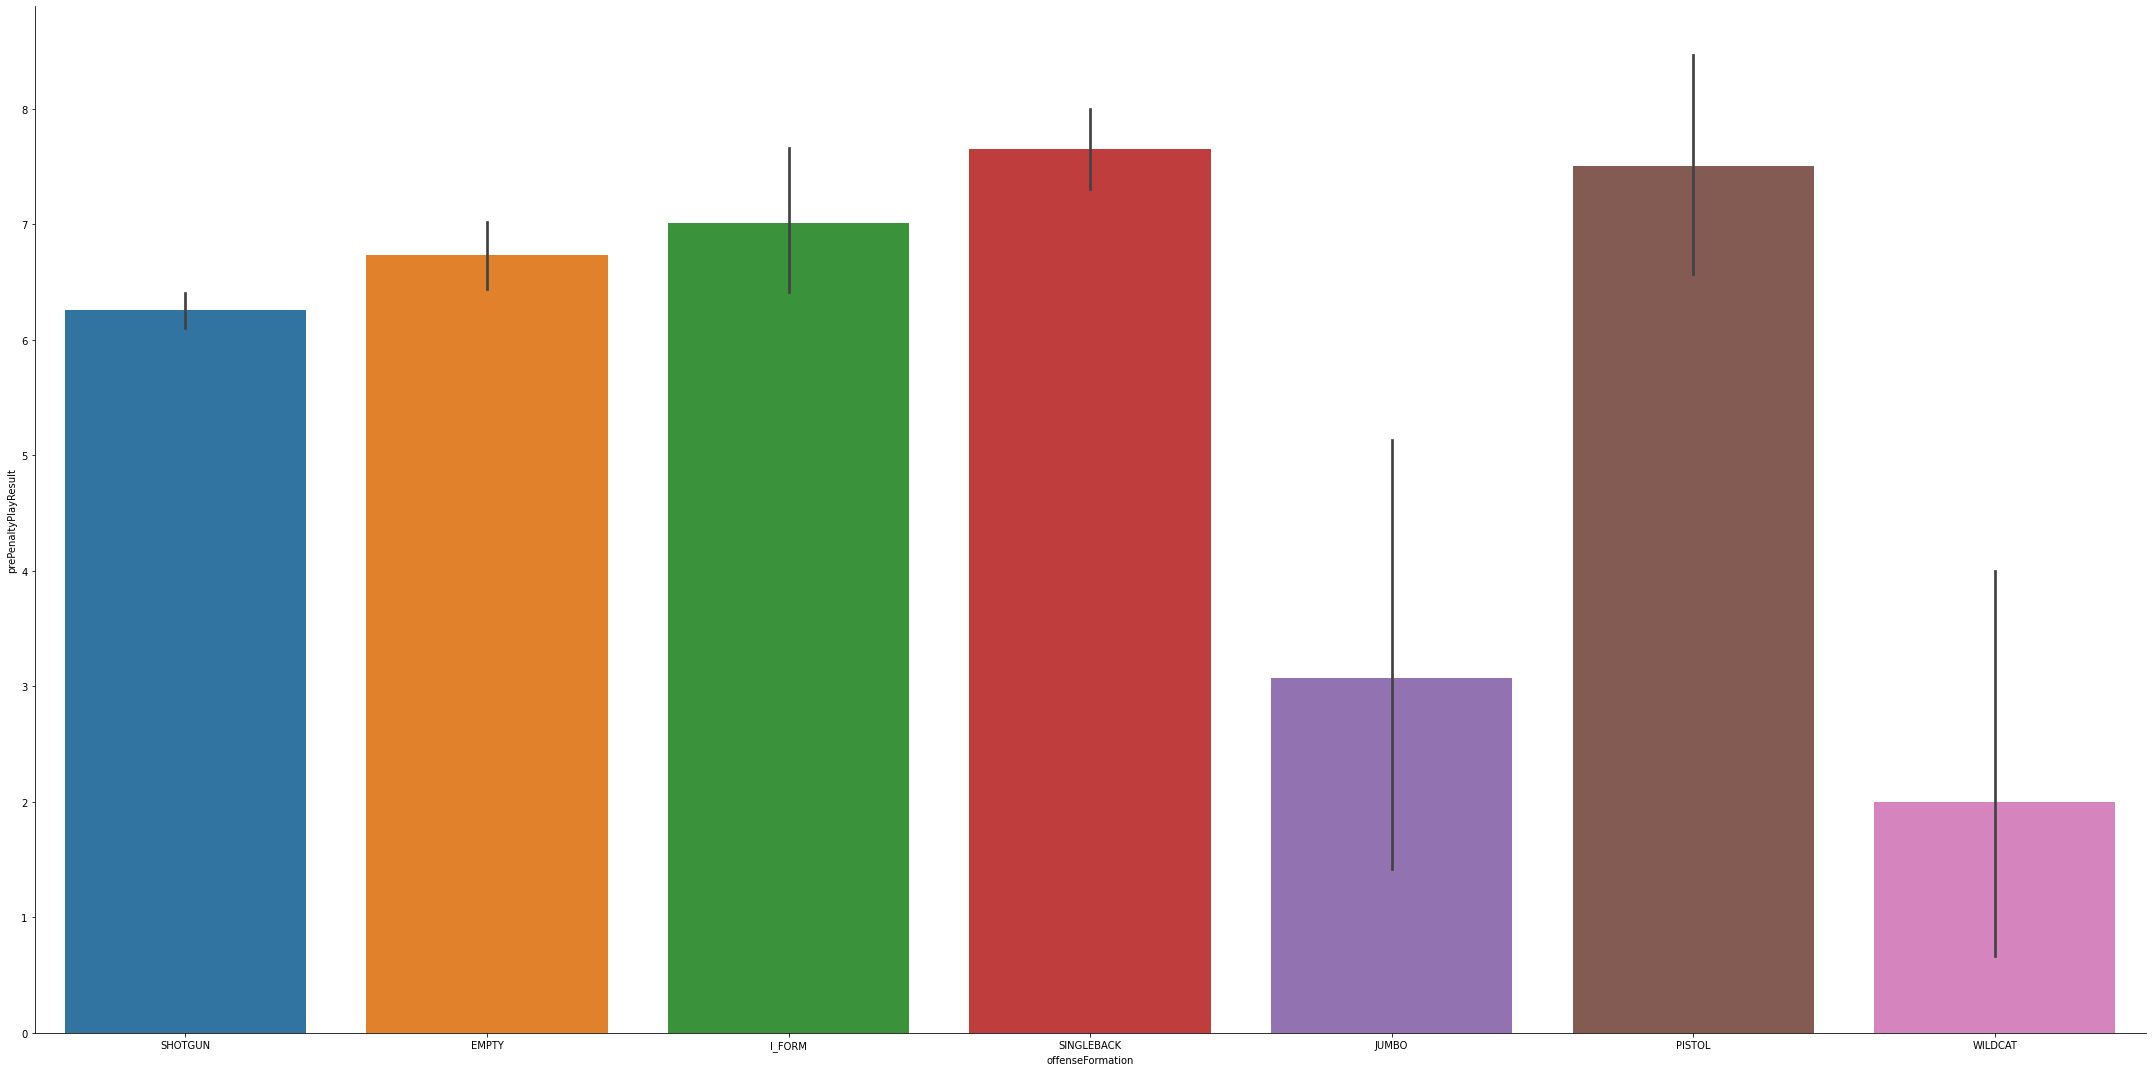

In [28]:
sns.catplot(x='offenseFormation', y='prePenaltyPlayResult', kind='bar',data=df_eda_cov, height=15, aspect=2)

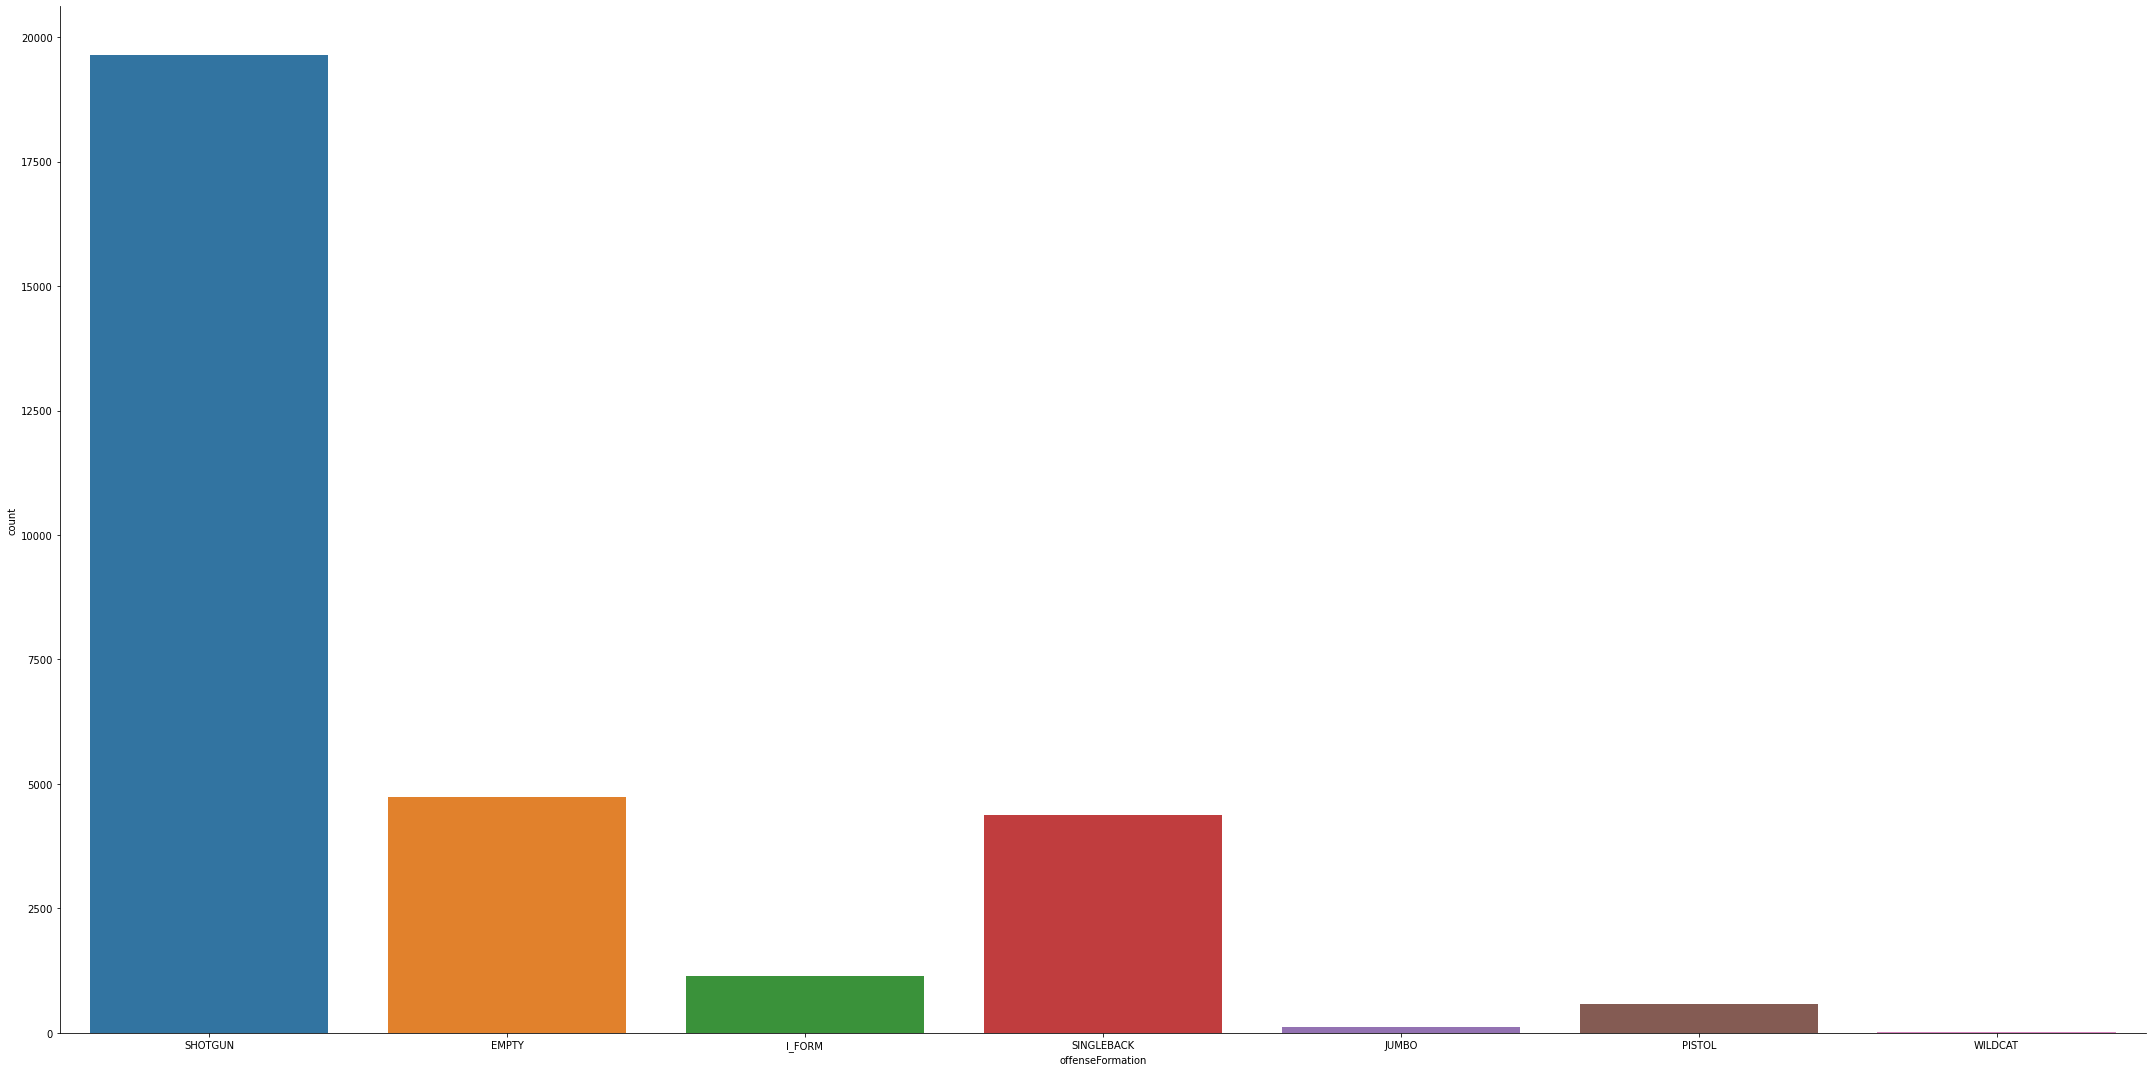

In [29]:
sns.catplot(x='offenseFormation', kind='count',data=df_eda_cov, height=15, aspect=2)

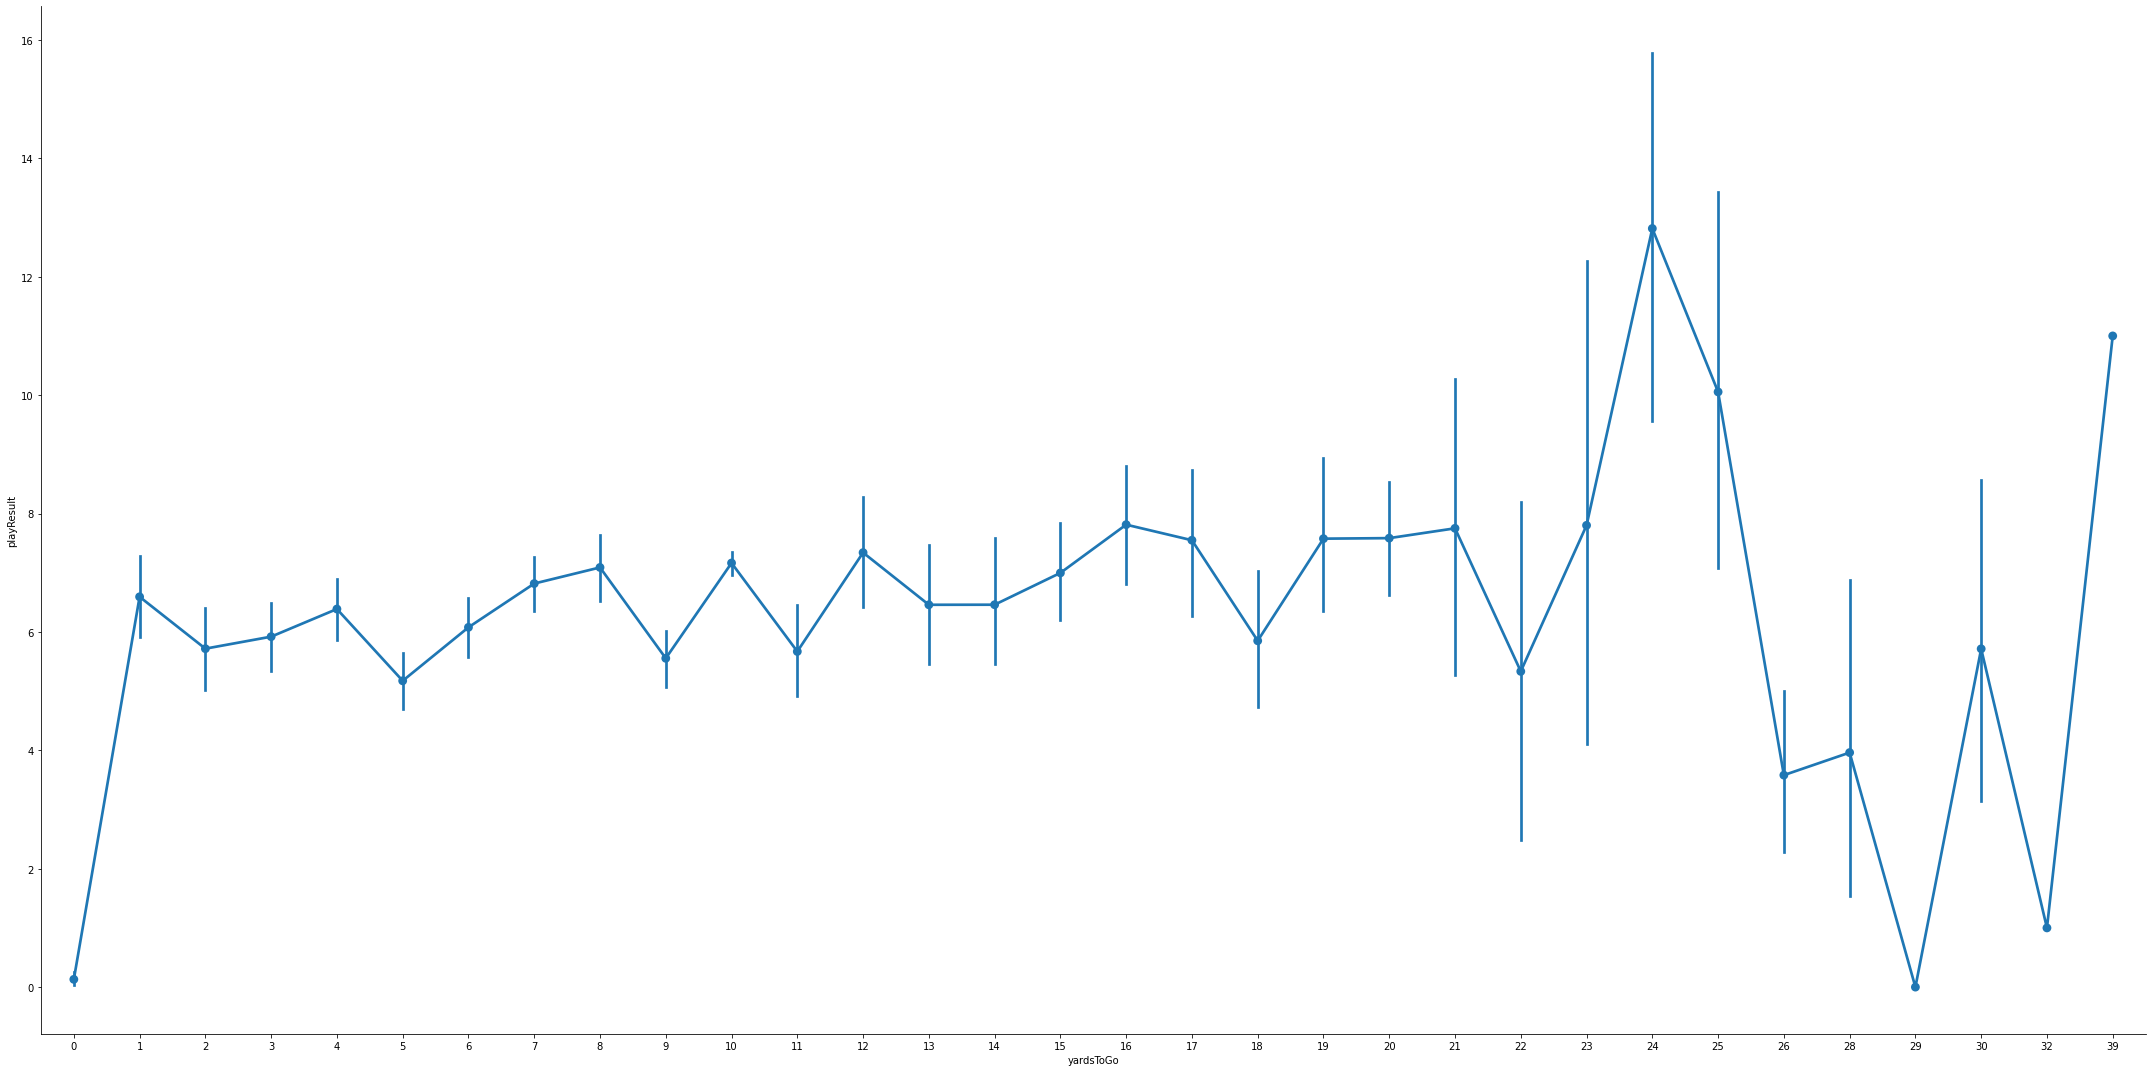

In [30]:
sns.catplot(x='yardsToGo',y='playResult', kind='point',data=df_eda_cov, height=15, aspect=2)

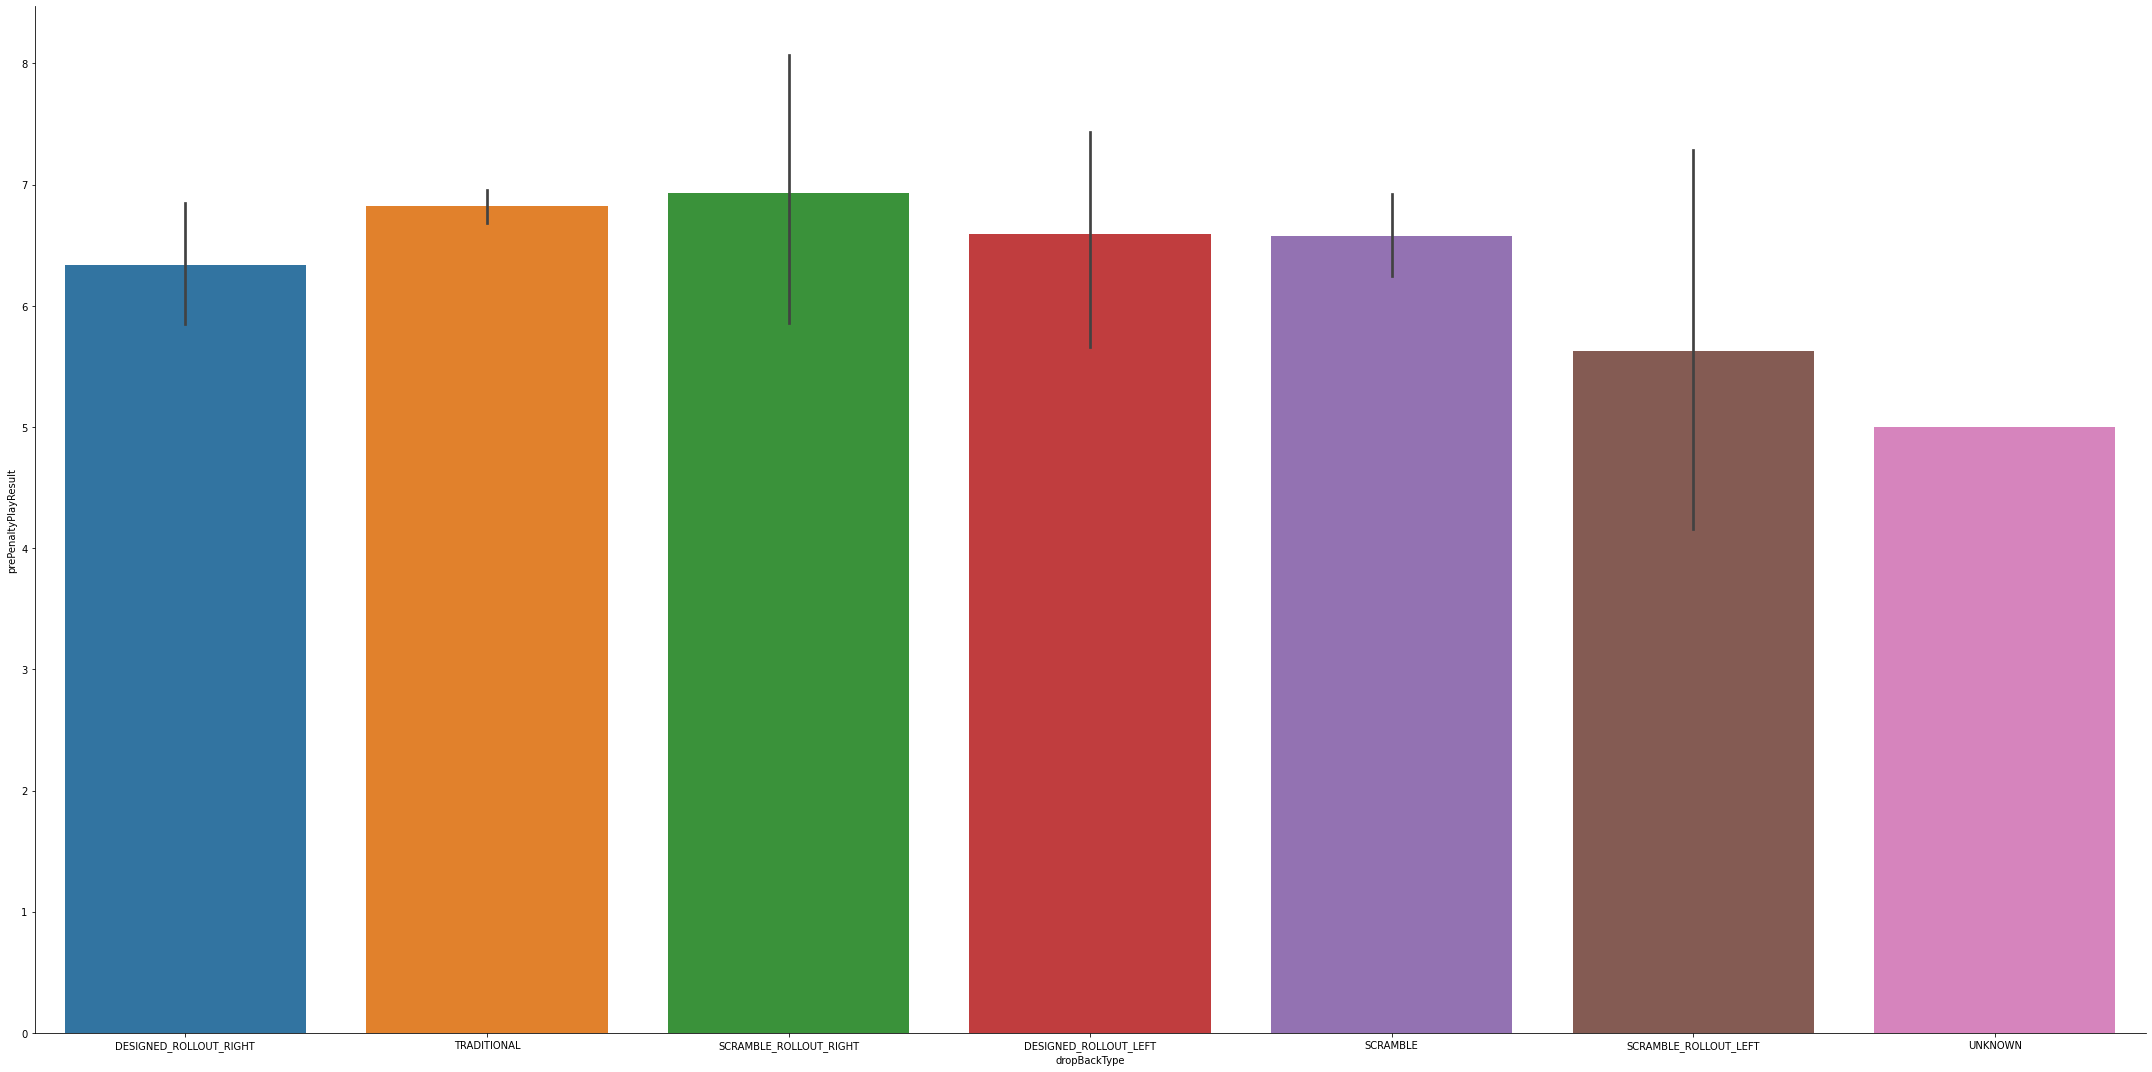

In [31]:
sns.catplot(x='dropBackType',y='prePenaltyPlayResult', kind='bar',data=df_eda_cov, height=15, aspect=2)

In [32]:
df2 = spark.read.format("csv").option('header','true').load('Data/new_metrics')
df2.createOrReplaceTempView('new_metrics')
df_new_metrics = spark.sql("SELECT * FROM new_metrics")
df_new_metrics = df_new_metrics.toPandas()
df_new_metrics.head()

,gameId,playId,nflId,pff_role,pff_positionLinedUp,frameId,x,y,s,a,dis,o,dir,yardsToGo,passResult,prePenaltyPlayResult,offenseFormation,defendersInBox,dropBackType,pff_passCoverage,pff_passCoverageType,separation_from_defender,defender_from_ball,dist_from_ball,xcatchingReceiverRoute,ycatchingReceiverRoute
0,2021090900,97,35481.0,Pass Route,TE-L,38,46.36,43.5,6.34,1.69,0.64,93.12,21.55,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,1.331352695569436,0.9451454914456324,25.25842433723846,short,stop
1,2021090900,97,35634.0,Pass Route,LWR,38,54.32,41.83,3.27,4.17,0.32,21.61,144.2,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,1.3567977004697476,0.9451454914456324,28.98004313316321,short,flat
2,2021090900,97,39985.0,Pass Route,HB-R,38,37.28,16.22,5.55,2.13,0.56,63.93,160.82,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,4.558168491839679,0.9451454914456324,6.919248514109031,medium,out
3,2021090900,97,41233.0,Pass Route,RWR,38,46.32,30.59,6.7,2.18,0.68,337.67,11.23,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,6.033945641120741,0.9451454914456324,15.664753429275551,short,flat
4,2021090900,97,44896.0,Pass Route,SLWR,38,53.01,23.44,7.64,3.49,0.77,11.44,154.38,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,1.359301291105103,0.9451454914456324,19.77163877881649,short,slant


In [33]:
df_new_metrics.dtypes

df_new_metrics['x'] = df_new_metrics['x'].astype(float)
df_new_metrics['y'] = df_new_metrics['y'].astype(float)
df_new_metrics['s'] = df_new_metrics['s'].astype(float)
df_new_metrics['a'] = df_new_metrics['a'].astype(float)
df_new_metrics['dis'] = df_new_metrics['dis'].astype(float)
df_new_metrics['o'] = df_new_metrics['o'].astype(float)
df_new_metrics['dir'] = df_new_metrics['dir'].astype(float)
df_new_metrics['prePenaltyPlayResult'] = df_new_metrics['prePenaltyPlayResult'].astype(float)
df_new_metrics['defendersInBox'] = df_new_metrics['defendersInBox'].astype(float)
df_new_metrics['separation_from_defender'] = df_new_metrics['separation_from_defender'].astype(float)
df_new_metrics['dist_from_ball'] = df_new_metrics['dist_from_ball'].astype(float)
df_new_metrics['yardsToGo'] = df_new_metrics['dist_from_ball'].astype(float)



In [34]:
df_new_metrics.dtypes


gameId                       object
playId                       object
nflId                        object
pff_role                     object
pff_positionLinedUp          object
frameId                      object
x                           float64
y                           float64
s                           float64
a                           float64
dis                         float64
o                           float64
dir                         float64
yardsToGo                   float64
passResult                   object
prePenaltyPlayResult        float64
offenseFormation             object
defendersInBox              float64
dropBackType                 object
pff_passCoverage             object
pff_passCoverageType         object
separation_from_defender    float64
defender_from_ball           object
dist_from_ball              float64
xcatchingReceiverRoute       object
ycatchingReceiverRoute       object
dtype: object

In [35]:
df_new_metrics['first_down_achieved'] = np.where(
    df_new_metrics['yardsToGo'] > df_new_metrics['prePenaltyPlayResult'], 0, np.where(
        df_new_metrics['yardsToGo'] <= df_new_metrics['prePenaltyPlayResult'], 1, -1)
)
df_new_metrics.describe

<bound method NDFrame.describe of            gameId playId    nflId    pff_role pff_positionLinedUp frameId  \
0      2021090900     97  35481.0  Pass Route                TE-L      38   
1      2021090900     97  35634.0  Pass Route                 LWR      38   
2      2021090900     97  39985.0  Pass Route                HB-R      38   
3      2021090900     97  41233.0  Pass Route                 RWR      38   
4      2021090900     97  44896.0  Pass Route                SLWR      38   
...           ...    ...      ...         ...                 ...     ...   
34342  2021110100   4363  53449.0  Pass Route                 RWR      43   
34343  2021110100   4411  44835.0  Pass Route                SRWR      32   
34344  2021110100   4411  47954.0  Pass Route                 RWR      32   
34345  2021110100   4411  52573.0  Pass Route                 LWR      32   
34346  2021110100   4411  53449.0  Pass Route                SLWR      32   

           x      y     s     a   dis    

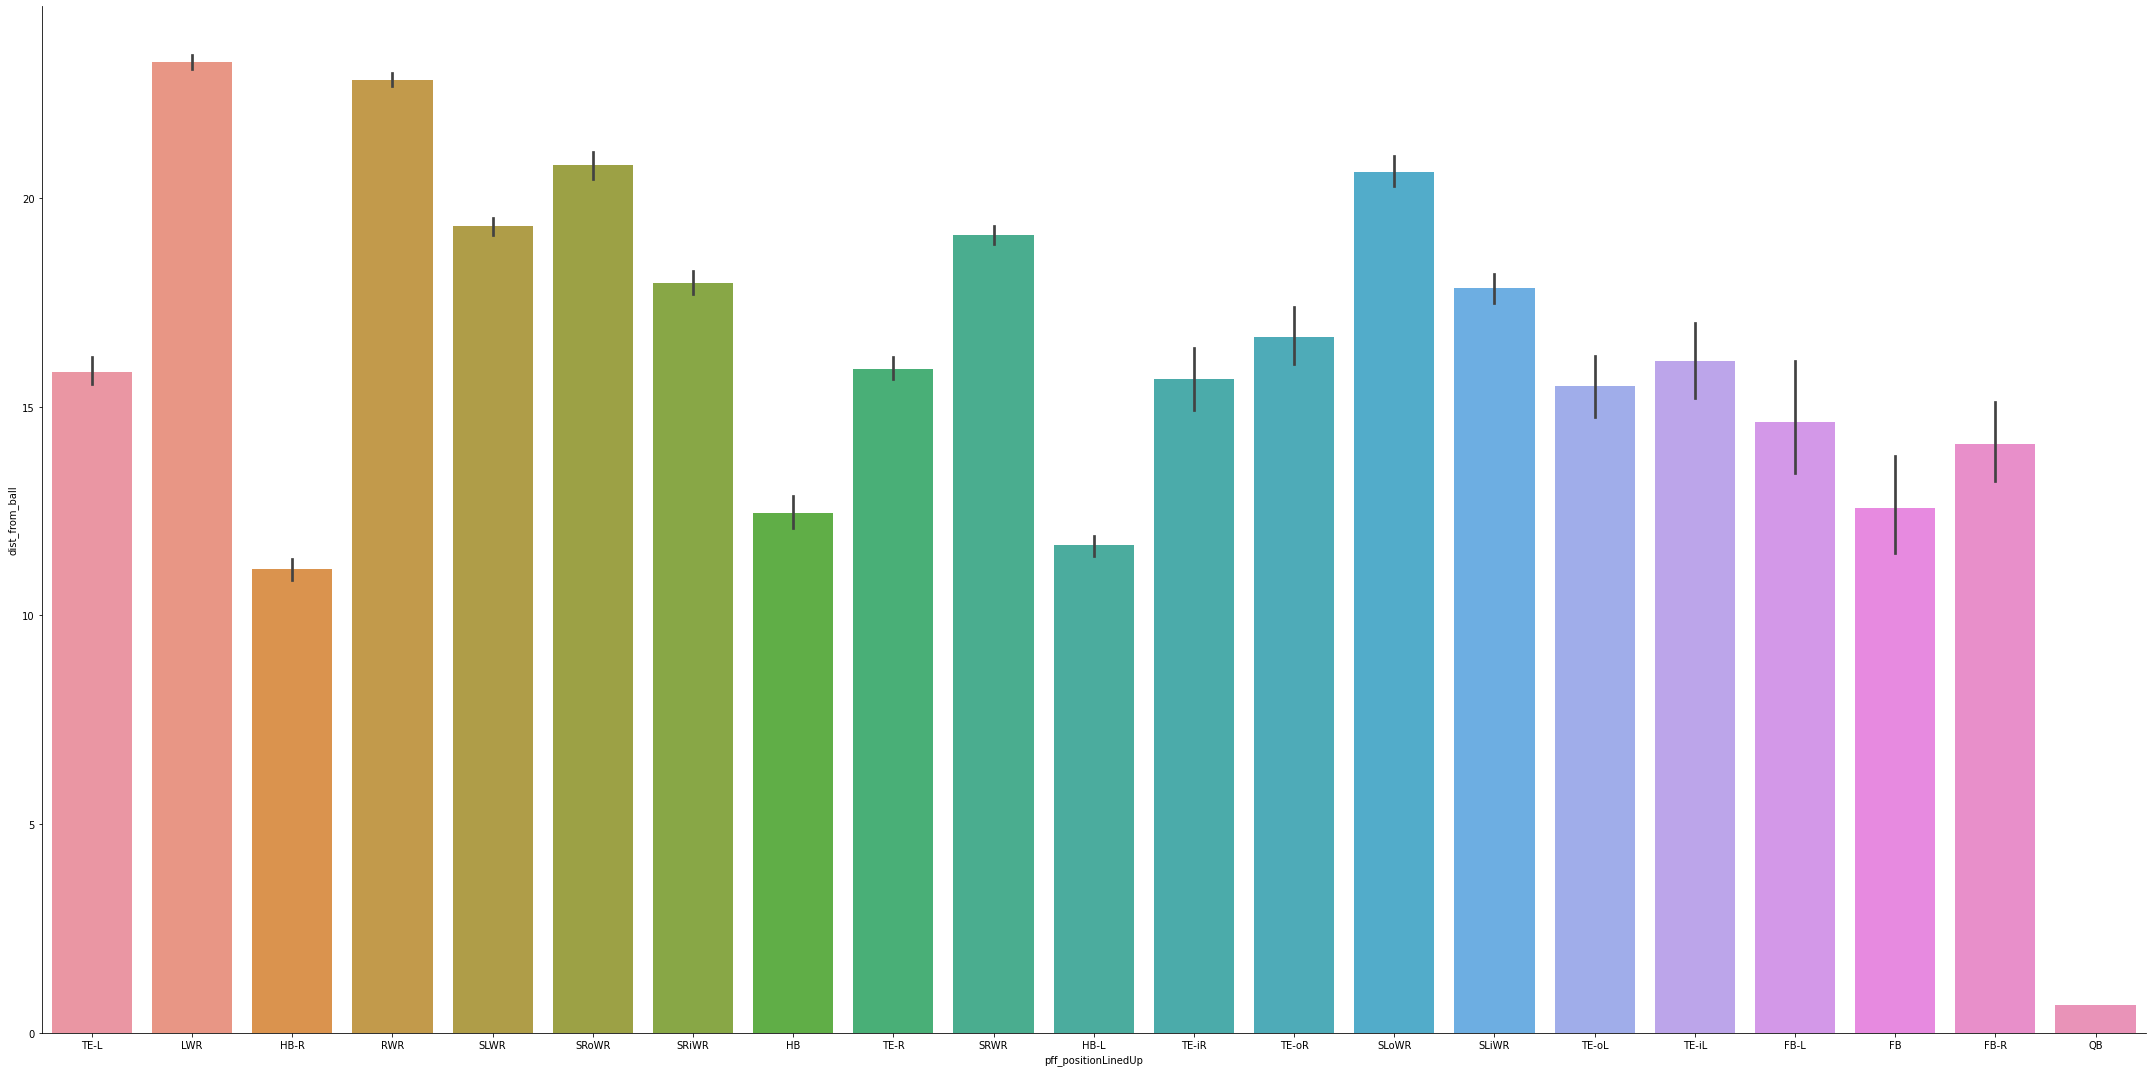

In [36]:
sns.catplot(x='pff_positionLinedUp',y='dist_from_ball', kind='bar',data=df_new_metrics, height=15, aspect=2)

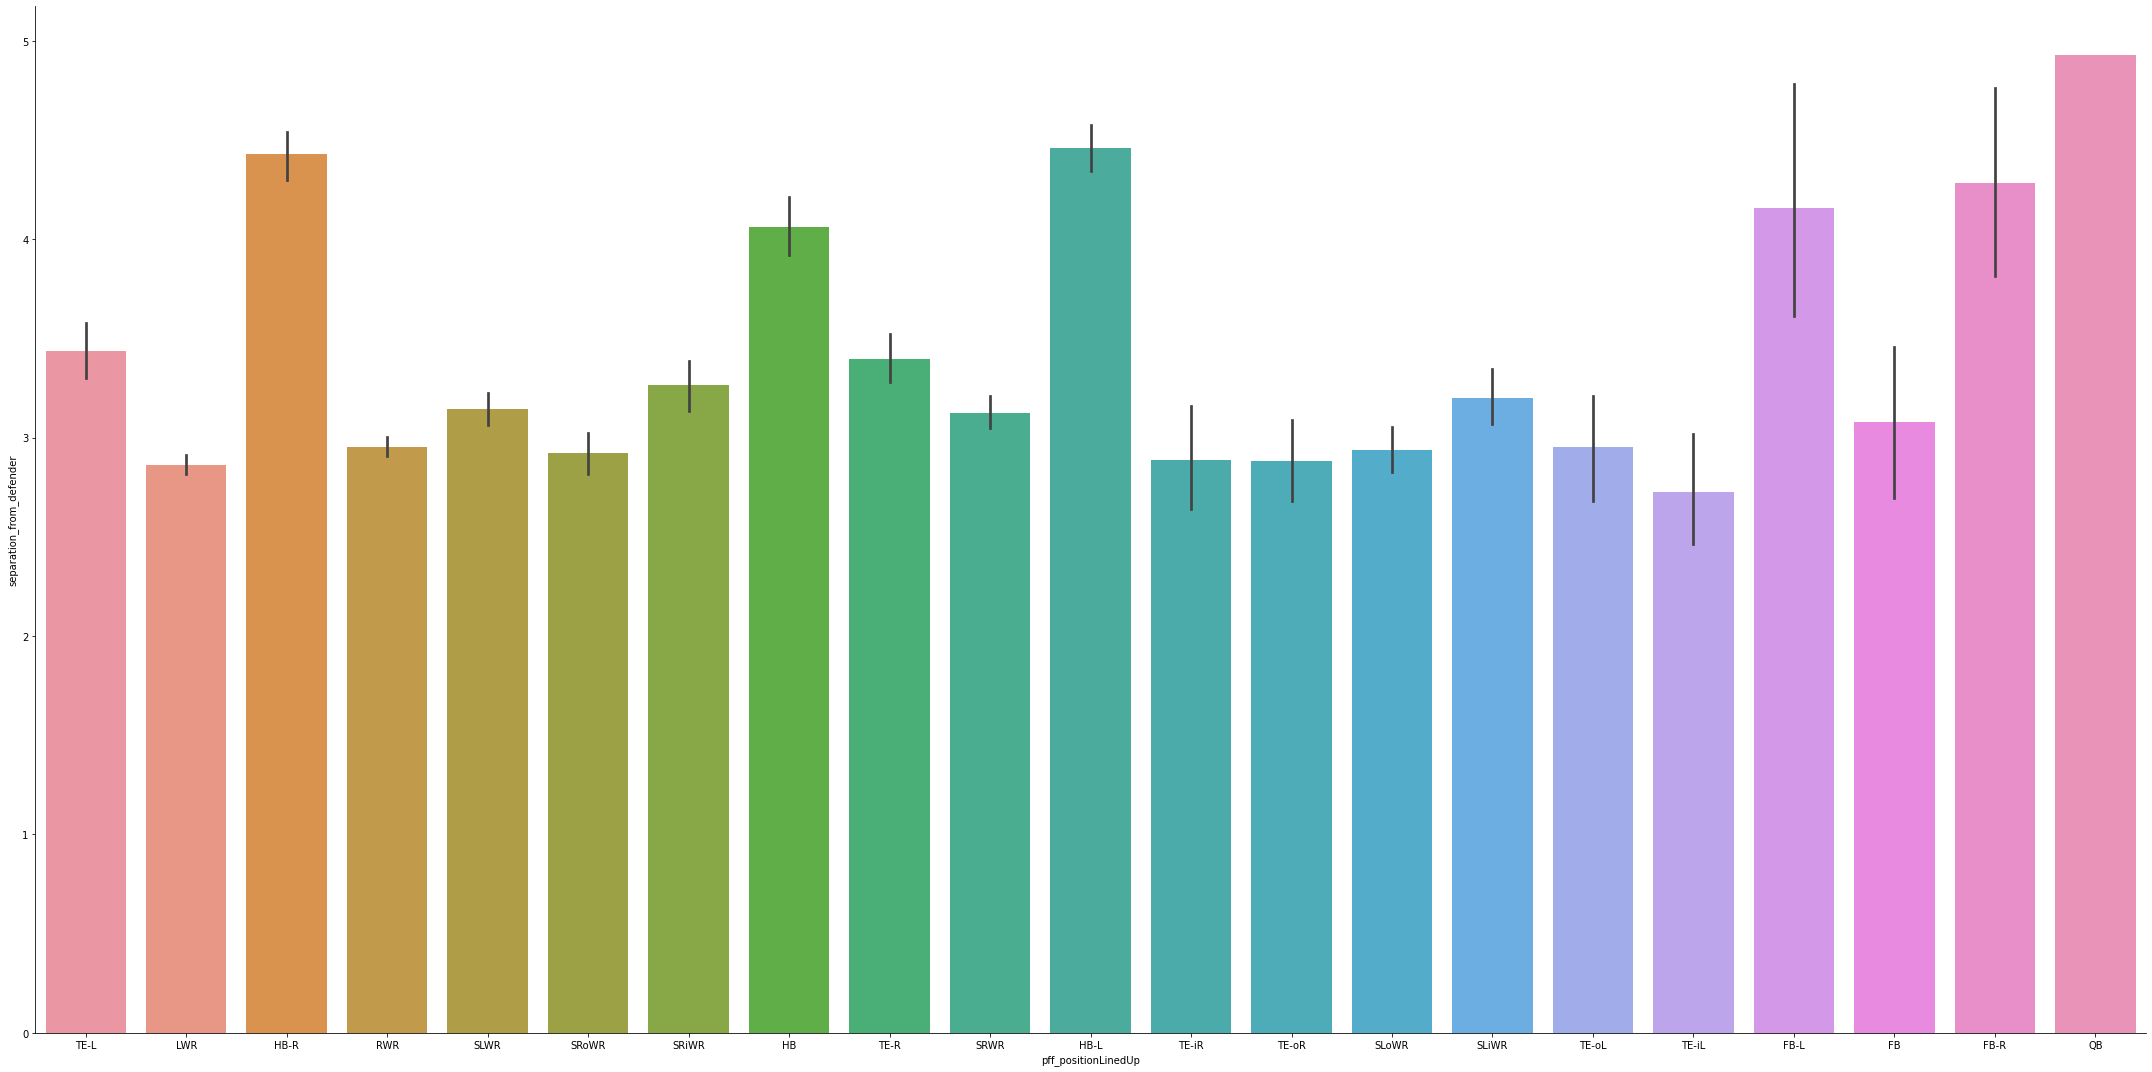

In [37]:
sns.catplot(x='pff_positionLinedUp',y='separation_from_defender', kind='bar',data=df_new_metrics, height=15, aspect=2)

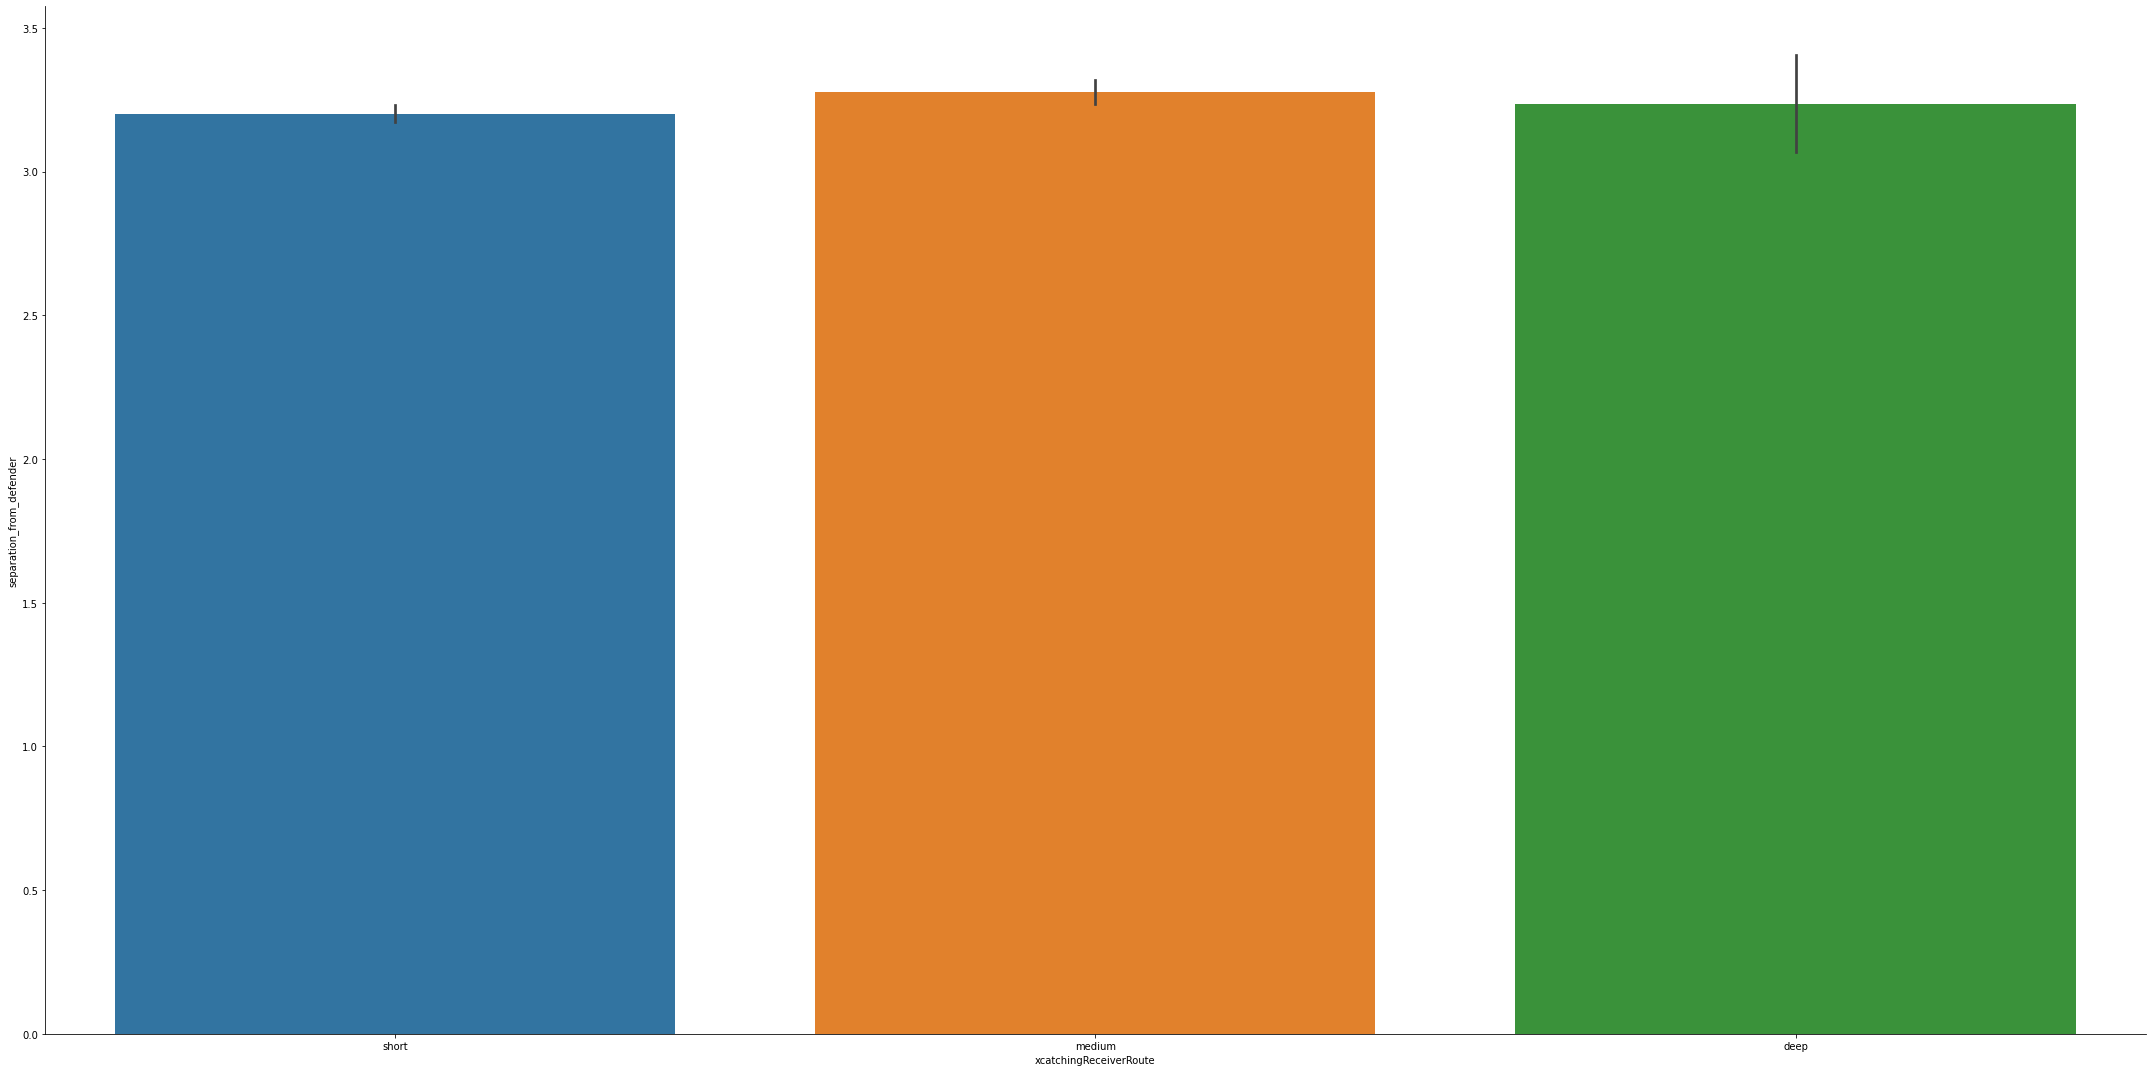

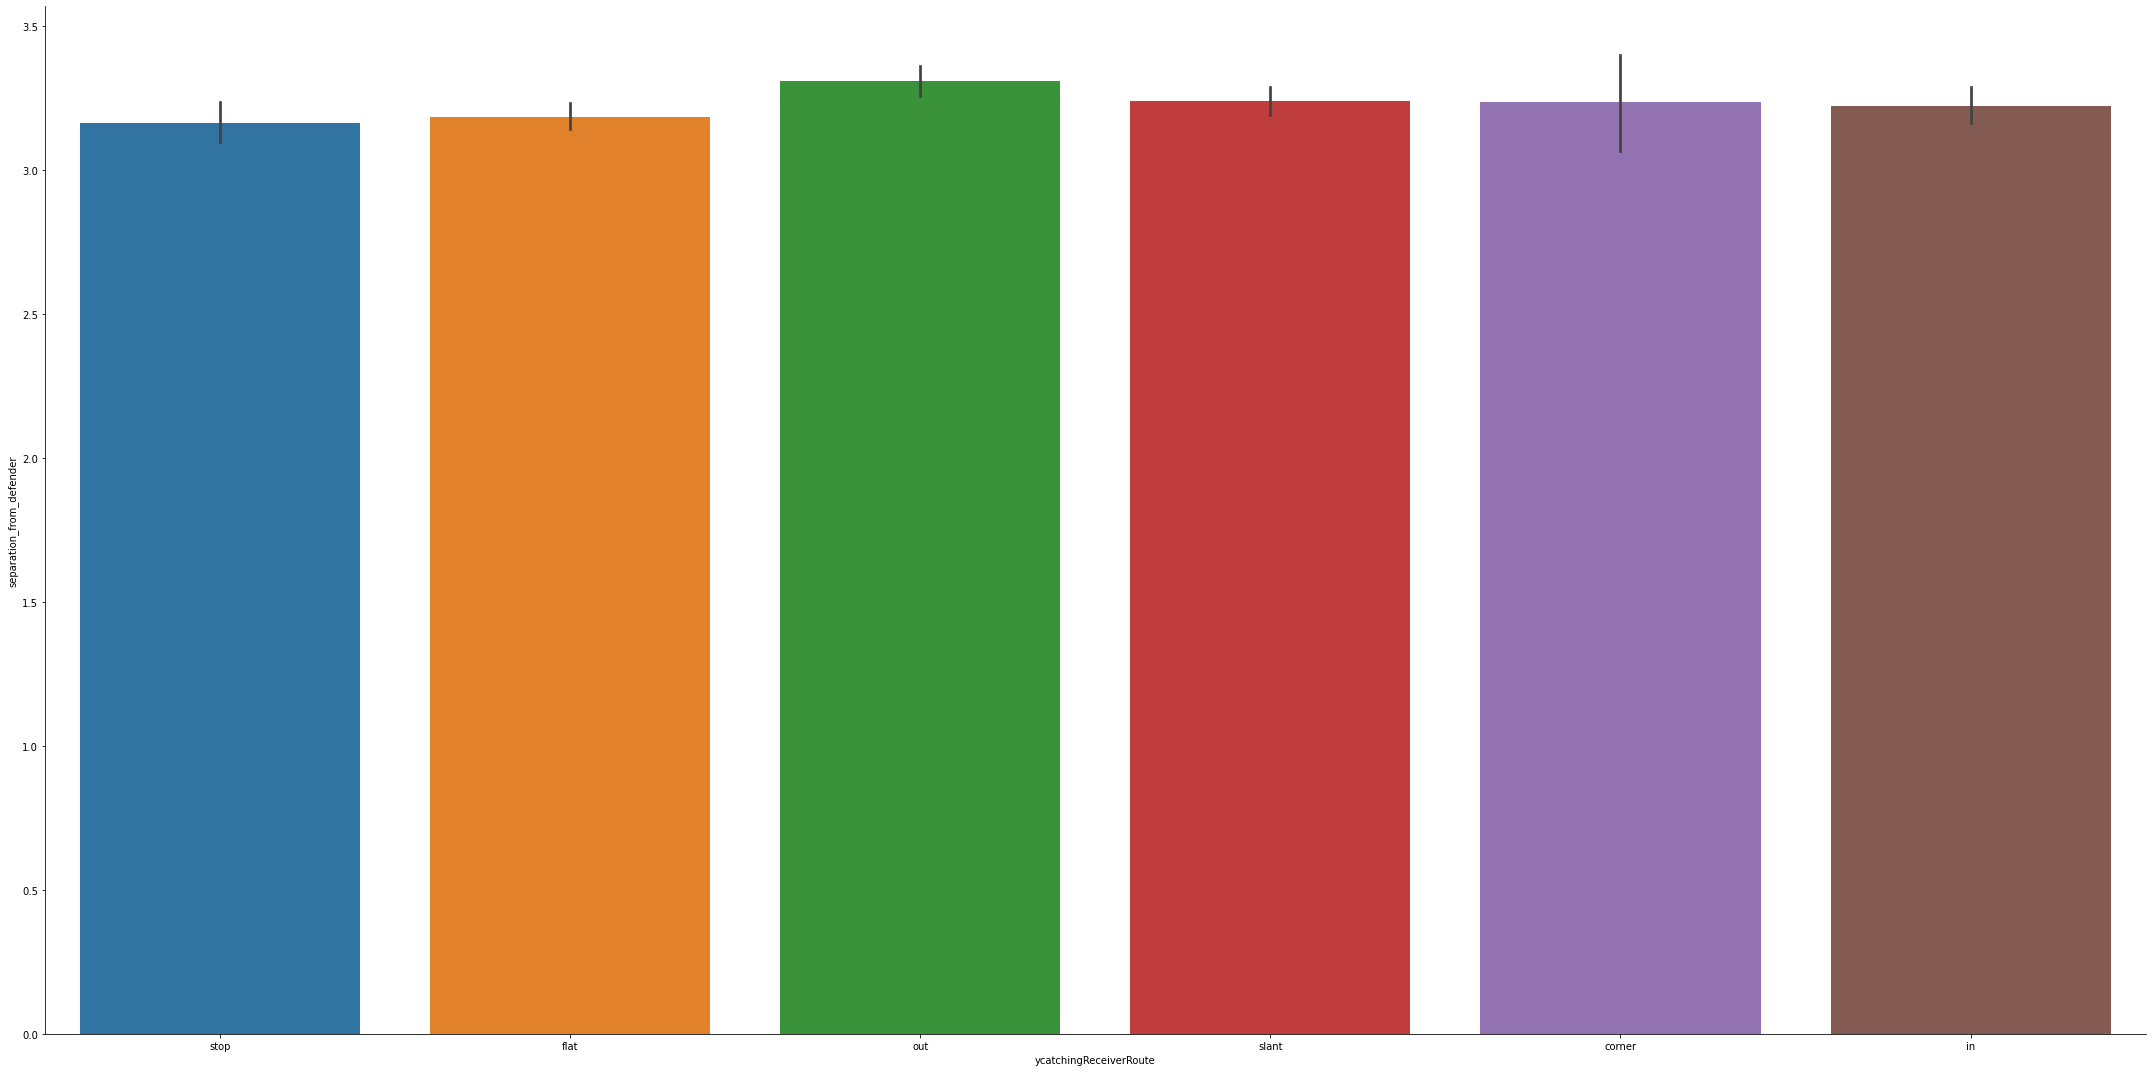

In [38]:
sns.catplot(x='xcatchingReceiverRoute',y='separation_from_defender', kind='bar',data=df_new_metrics, height=15, aspect=2)
sns.catplot(x='ycatchingReceiverRoute',y='separation_from_defender', kind='bar',data=df_new_metrics, height=15, aspect=2)

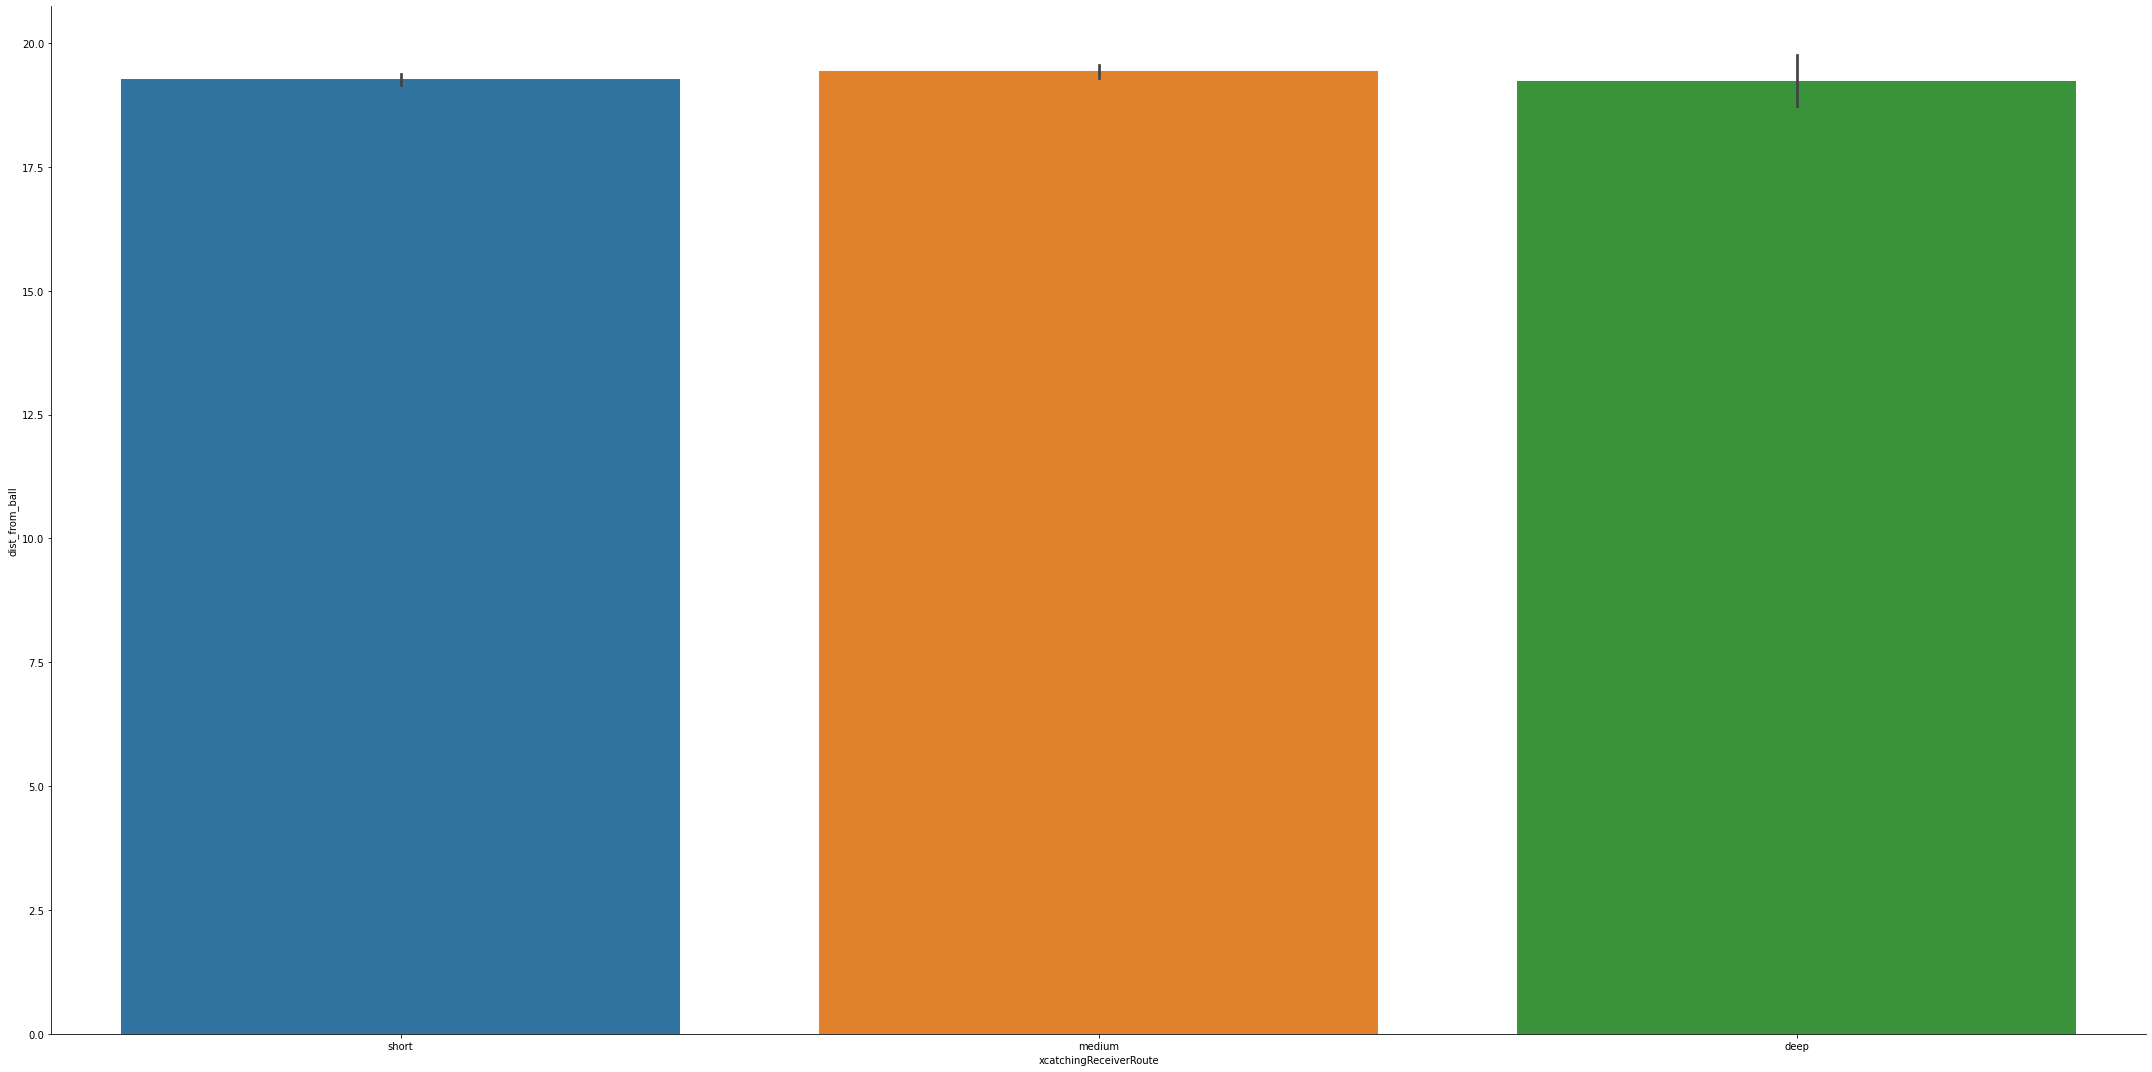

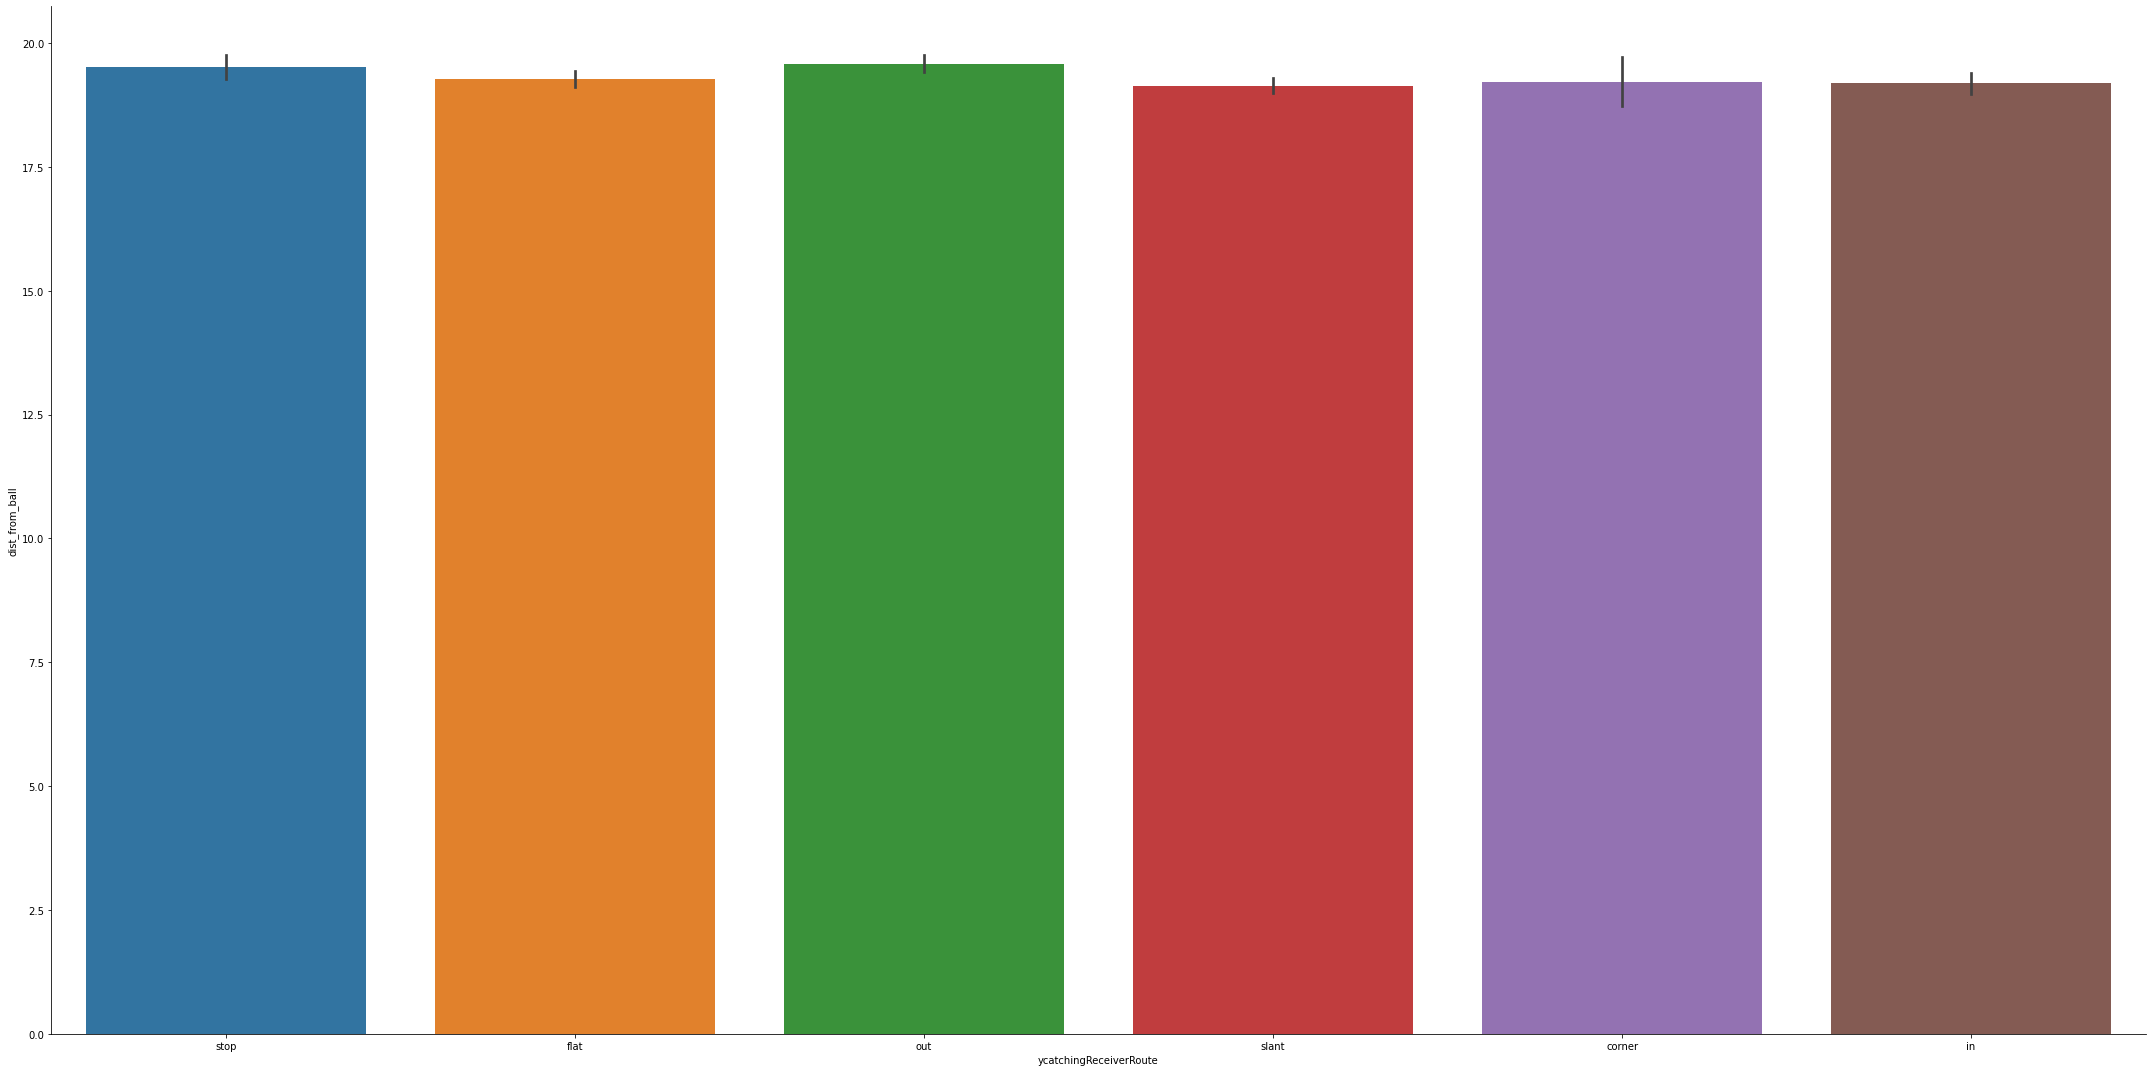

In [39]:
sns.catplot(x='xcatchingReceiverRoute',y='dist_from_ball', kind='bar',data=df_new_metrics, height=15, aspect=2)
sns.catplot(x='ycatchingReceiverRoute',y='dist_from_ball', kind='bar',data=df_new_metrics, height=15, aspect=2)

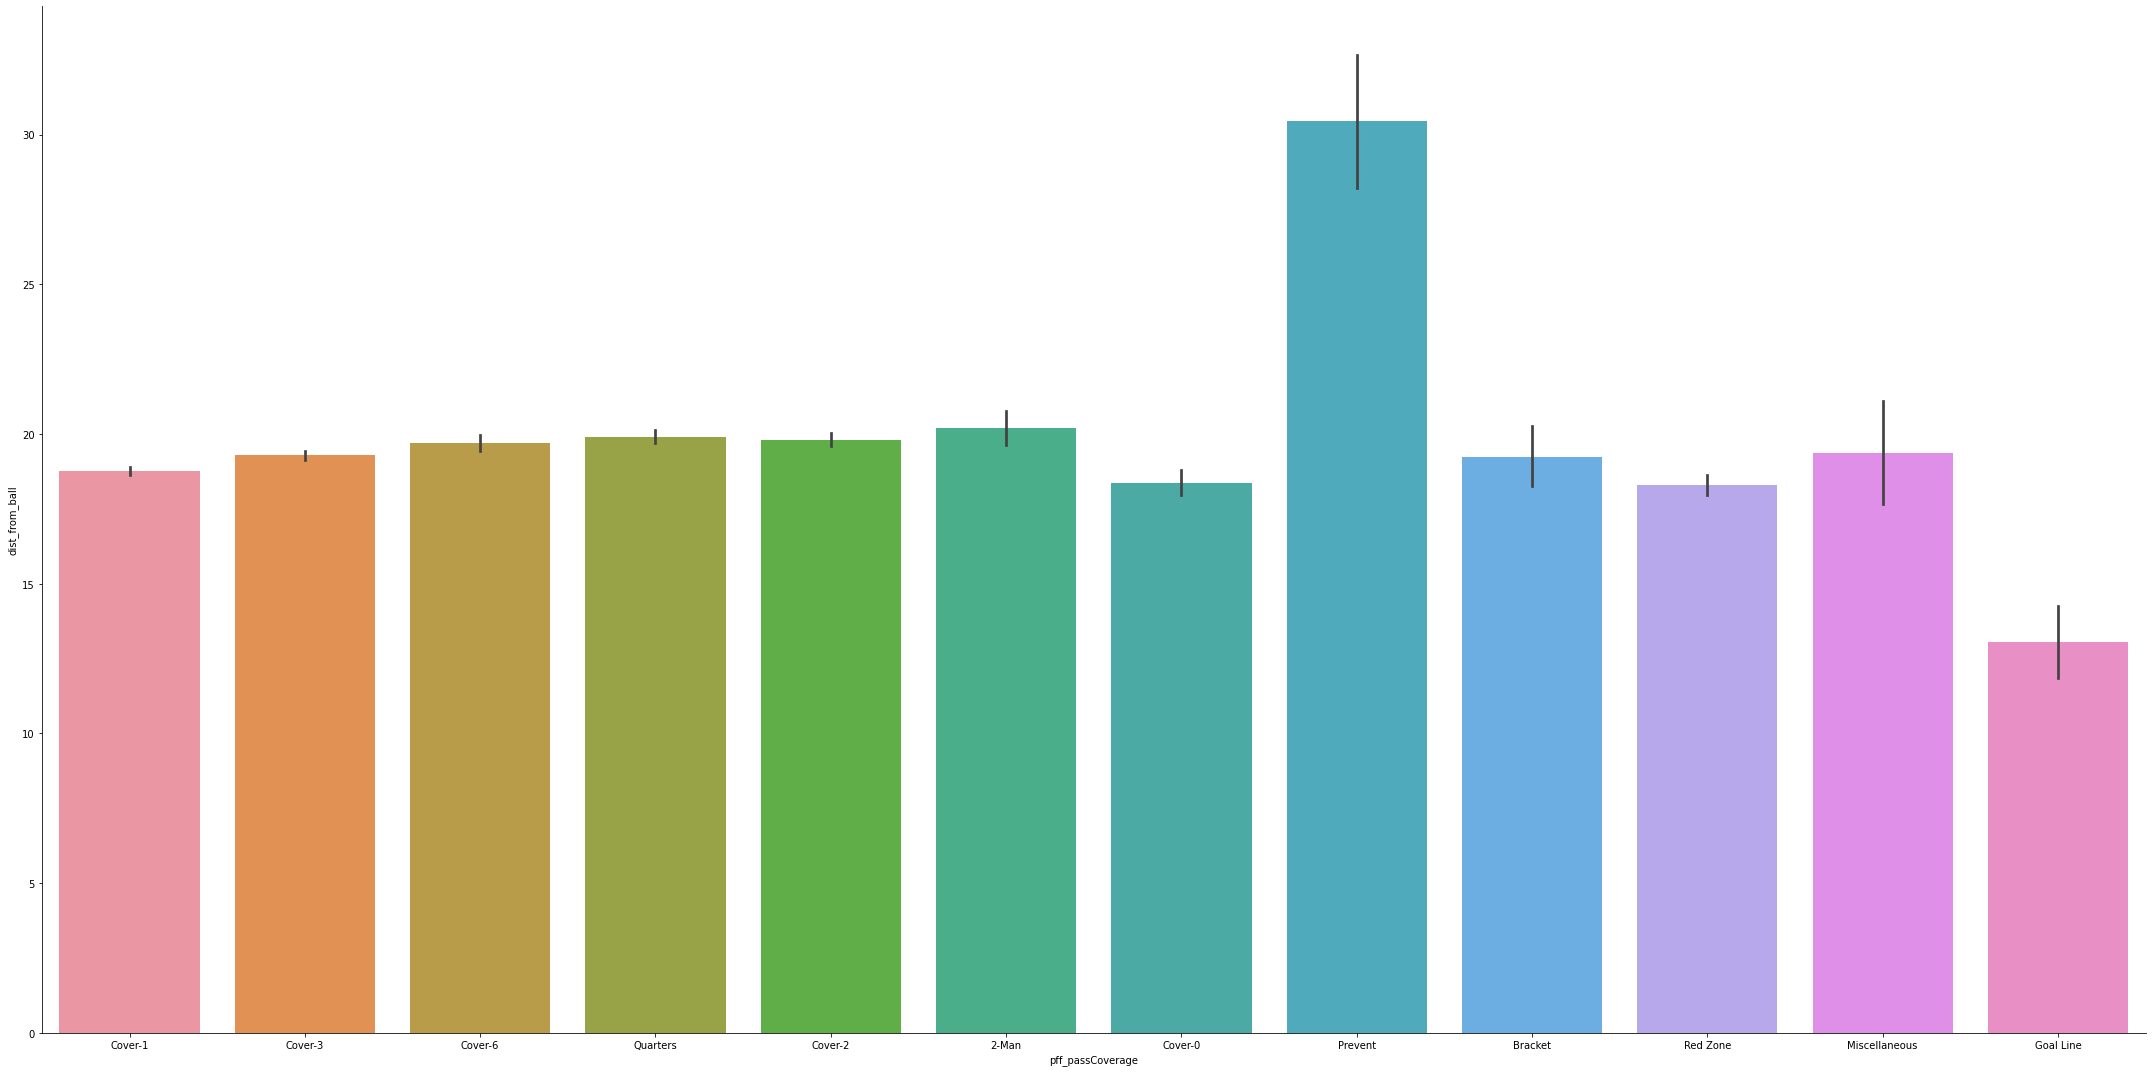

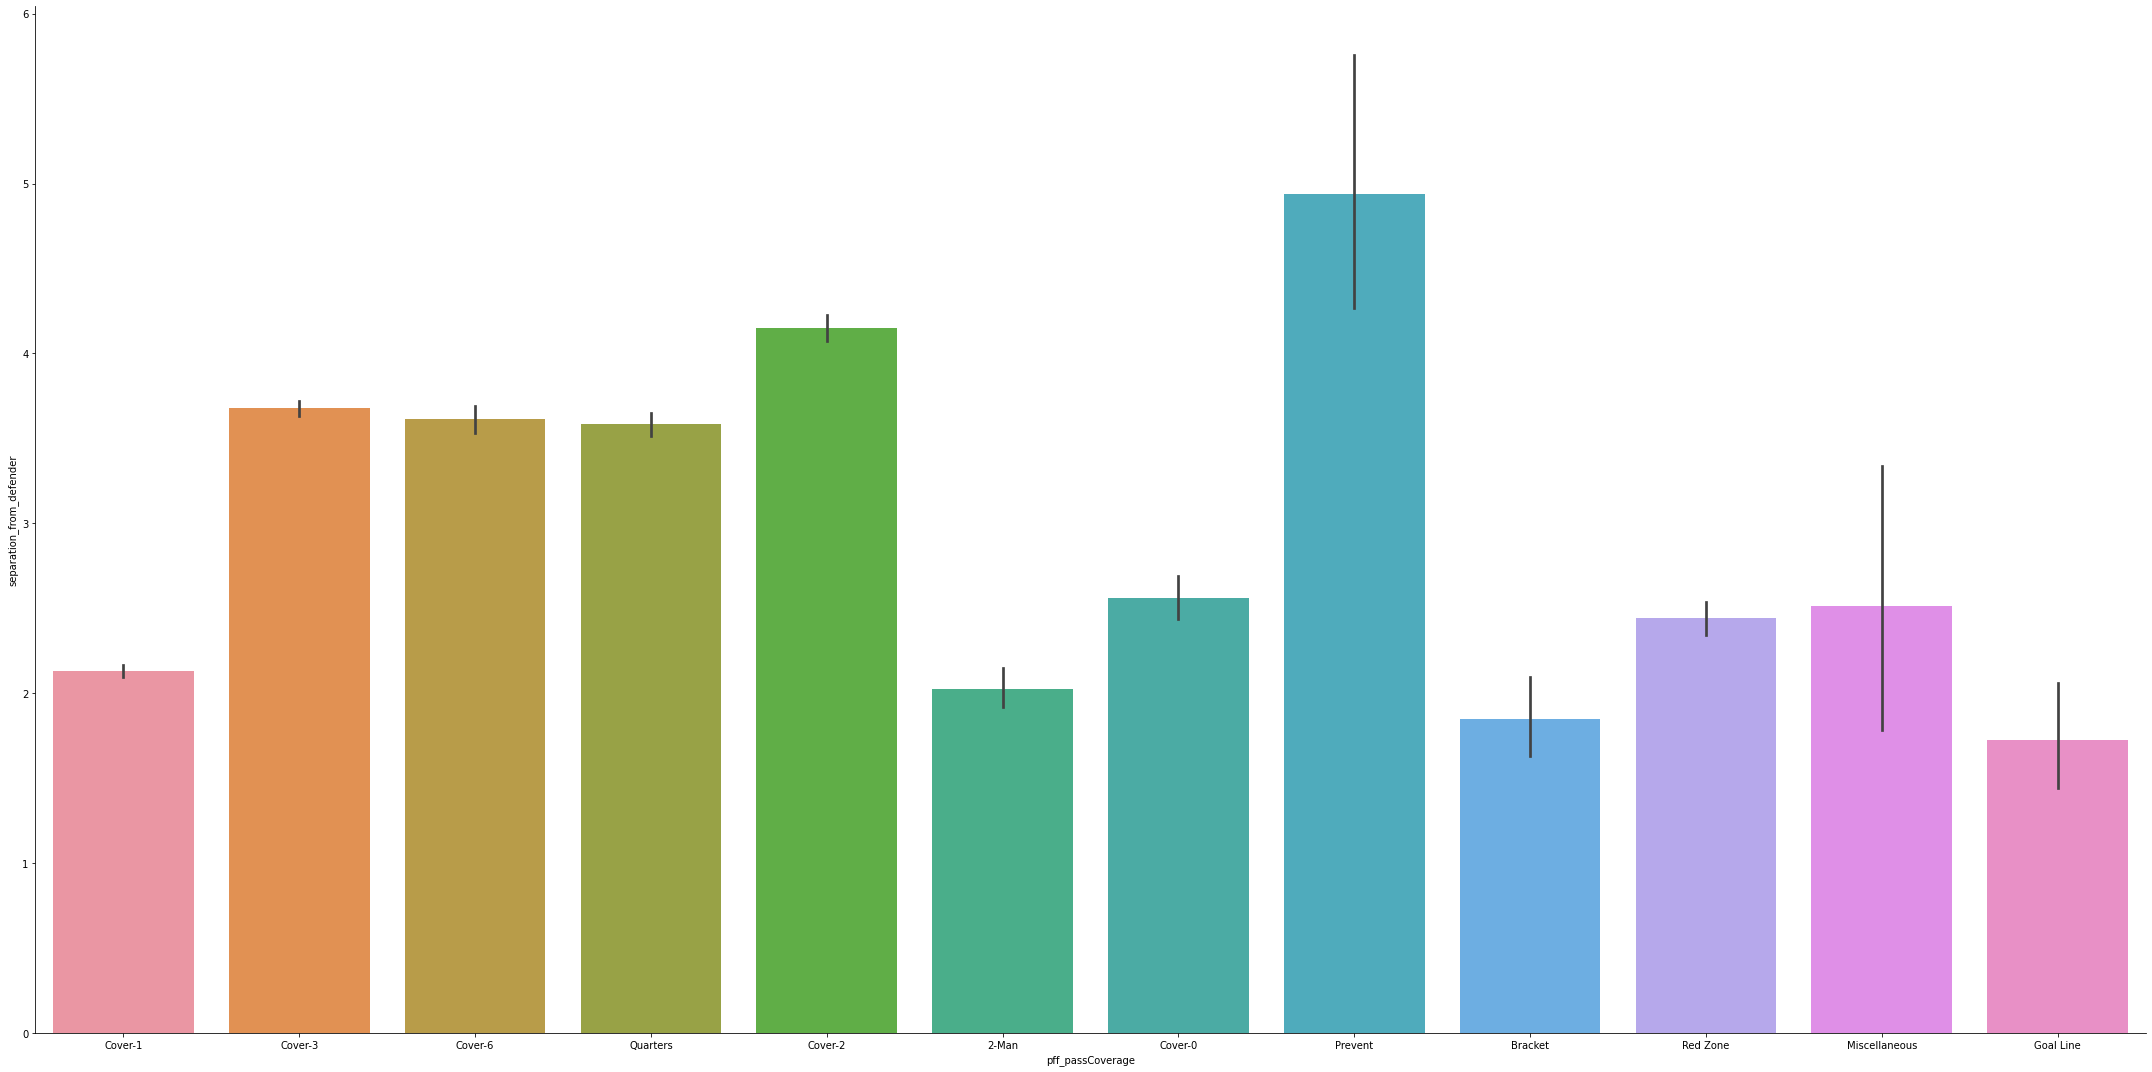

In [40]:
sns.catplot(x='pff_passCoverage',y='dist_from_ball', kind='bar',data=df_new_metrics, height=15, aspect=2)
sns.catplot(x='pff_passCoverage',y='separation_from_defender', kind='bar',data=df_new_metrics, height=15, aspect=2)

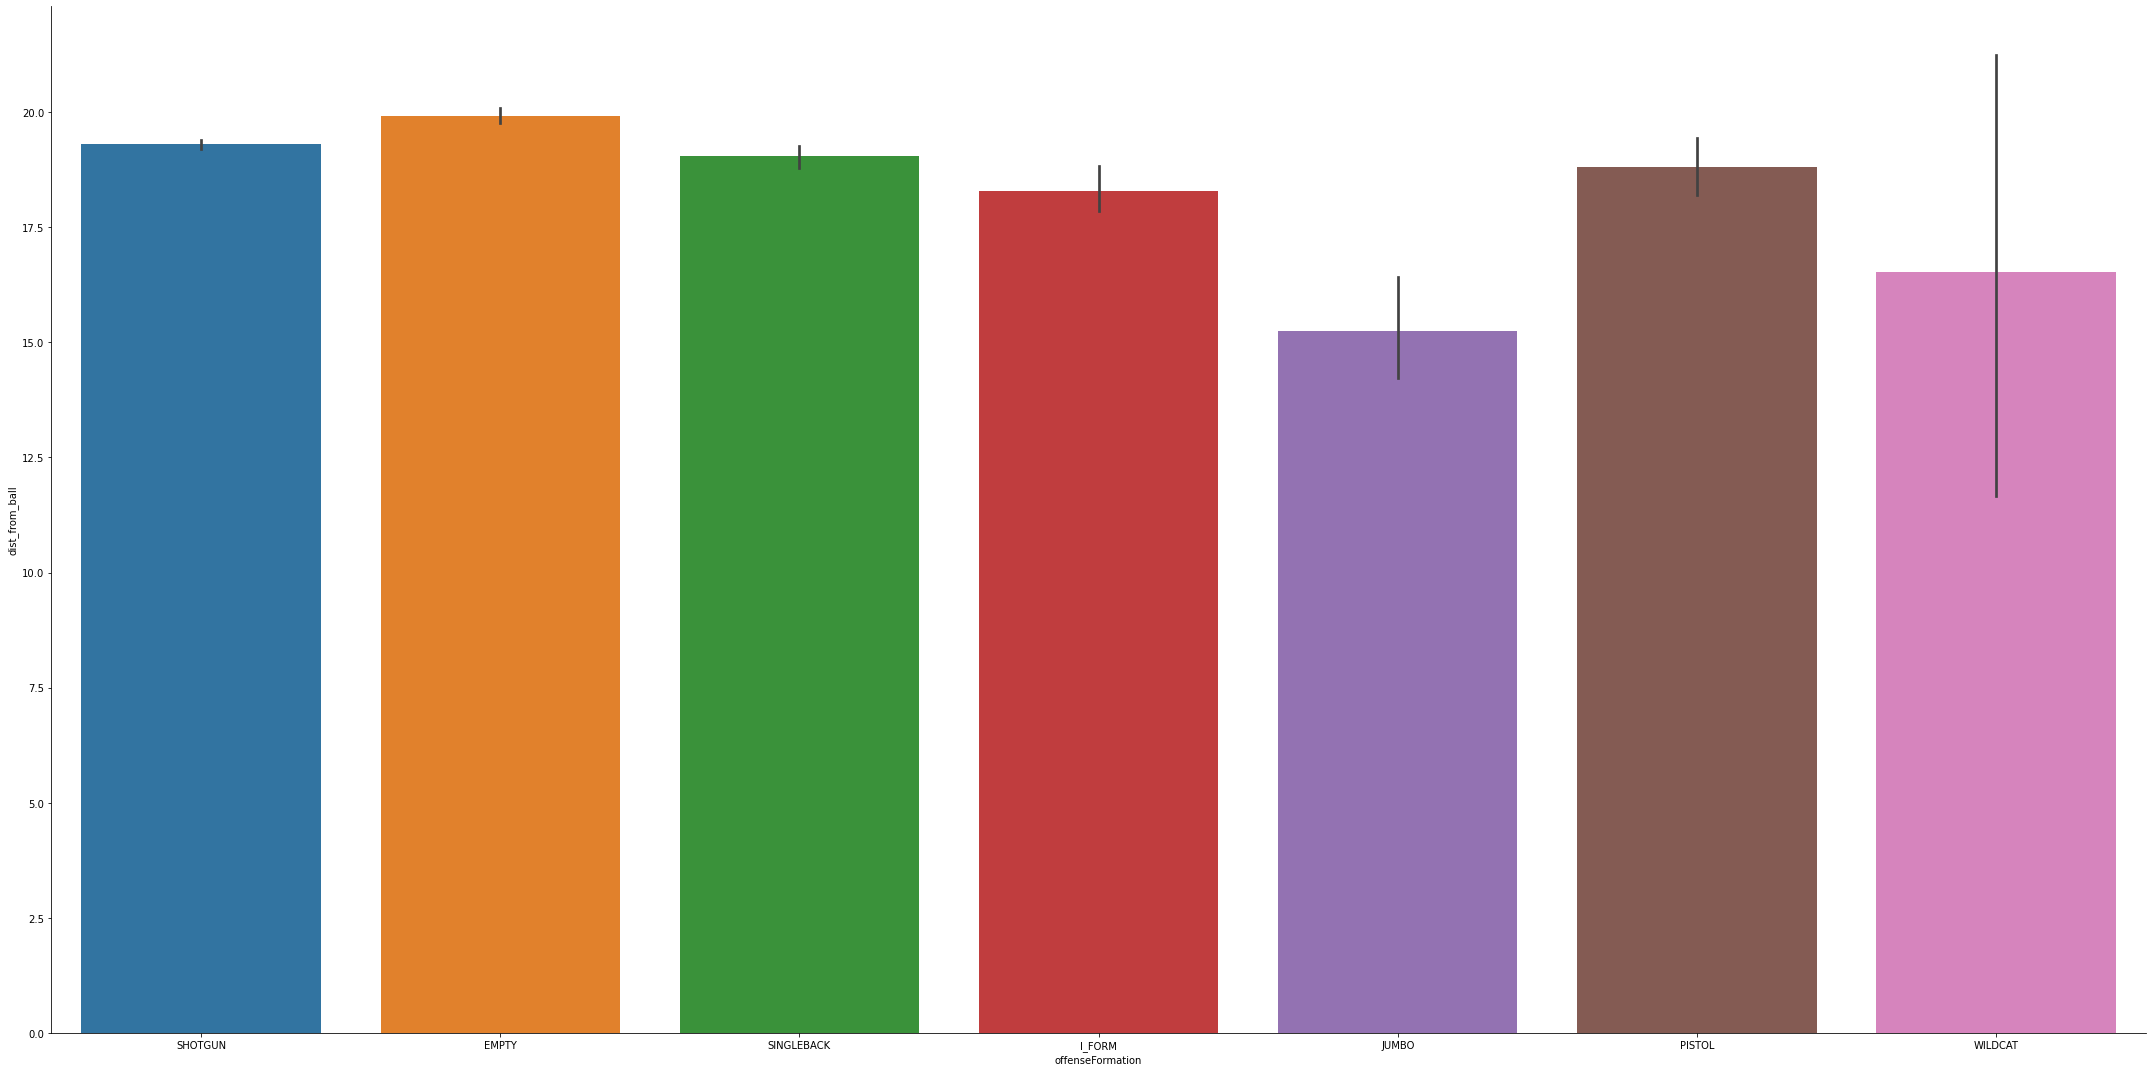

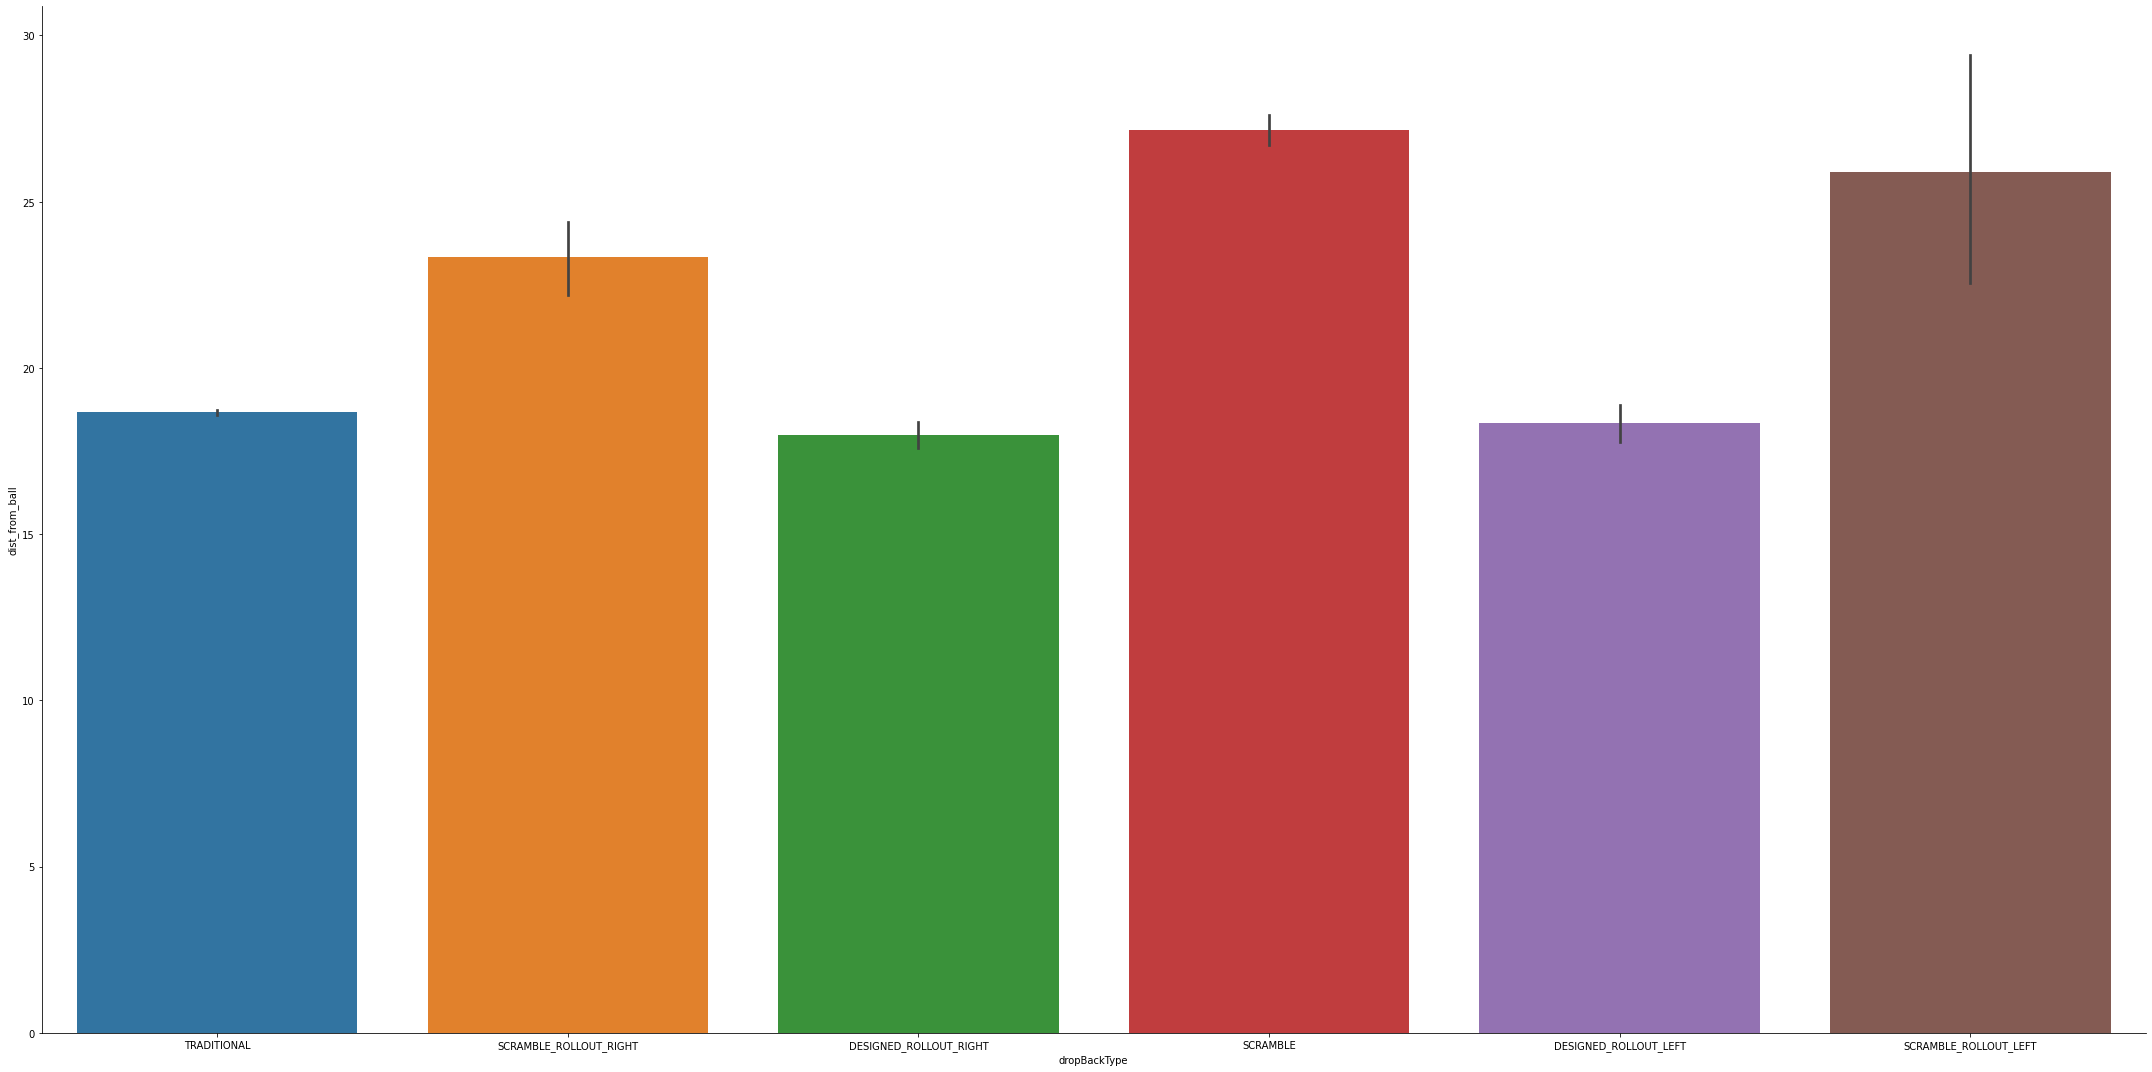

In [41]:
sns.catplot(x='offenseFormation',y='dist_from_ball',kind='bar',data=df_new_metrics, height=15, aspect=2)
sns.catplot(x='dropBackType',y='dist_from_ball',kind='bar',data=df_new_metrics, height=15, aspect=2)


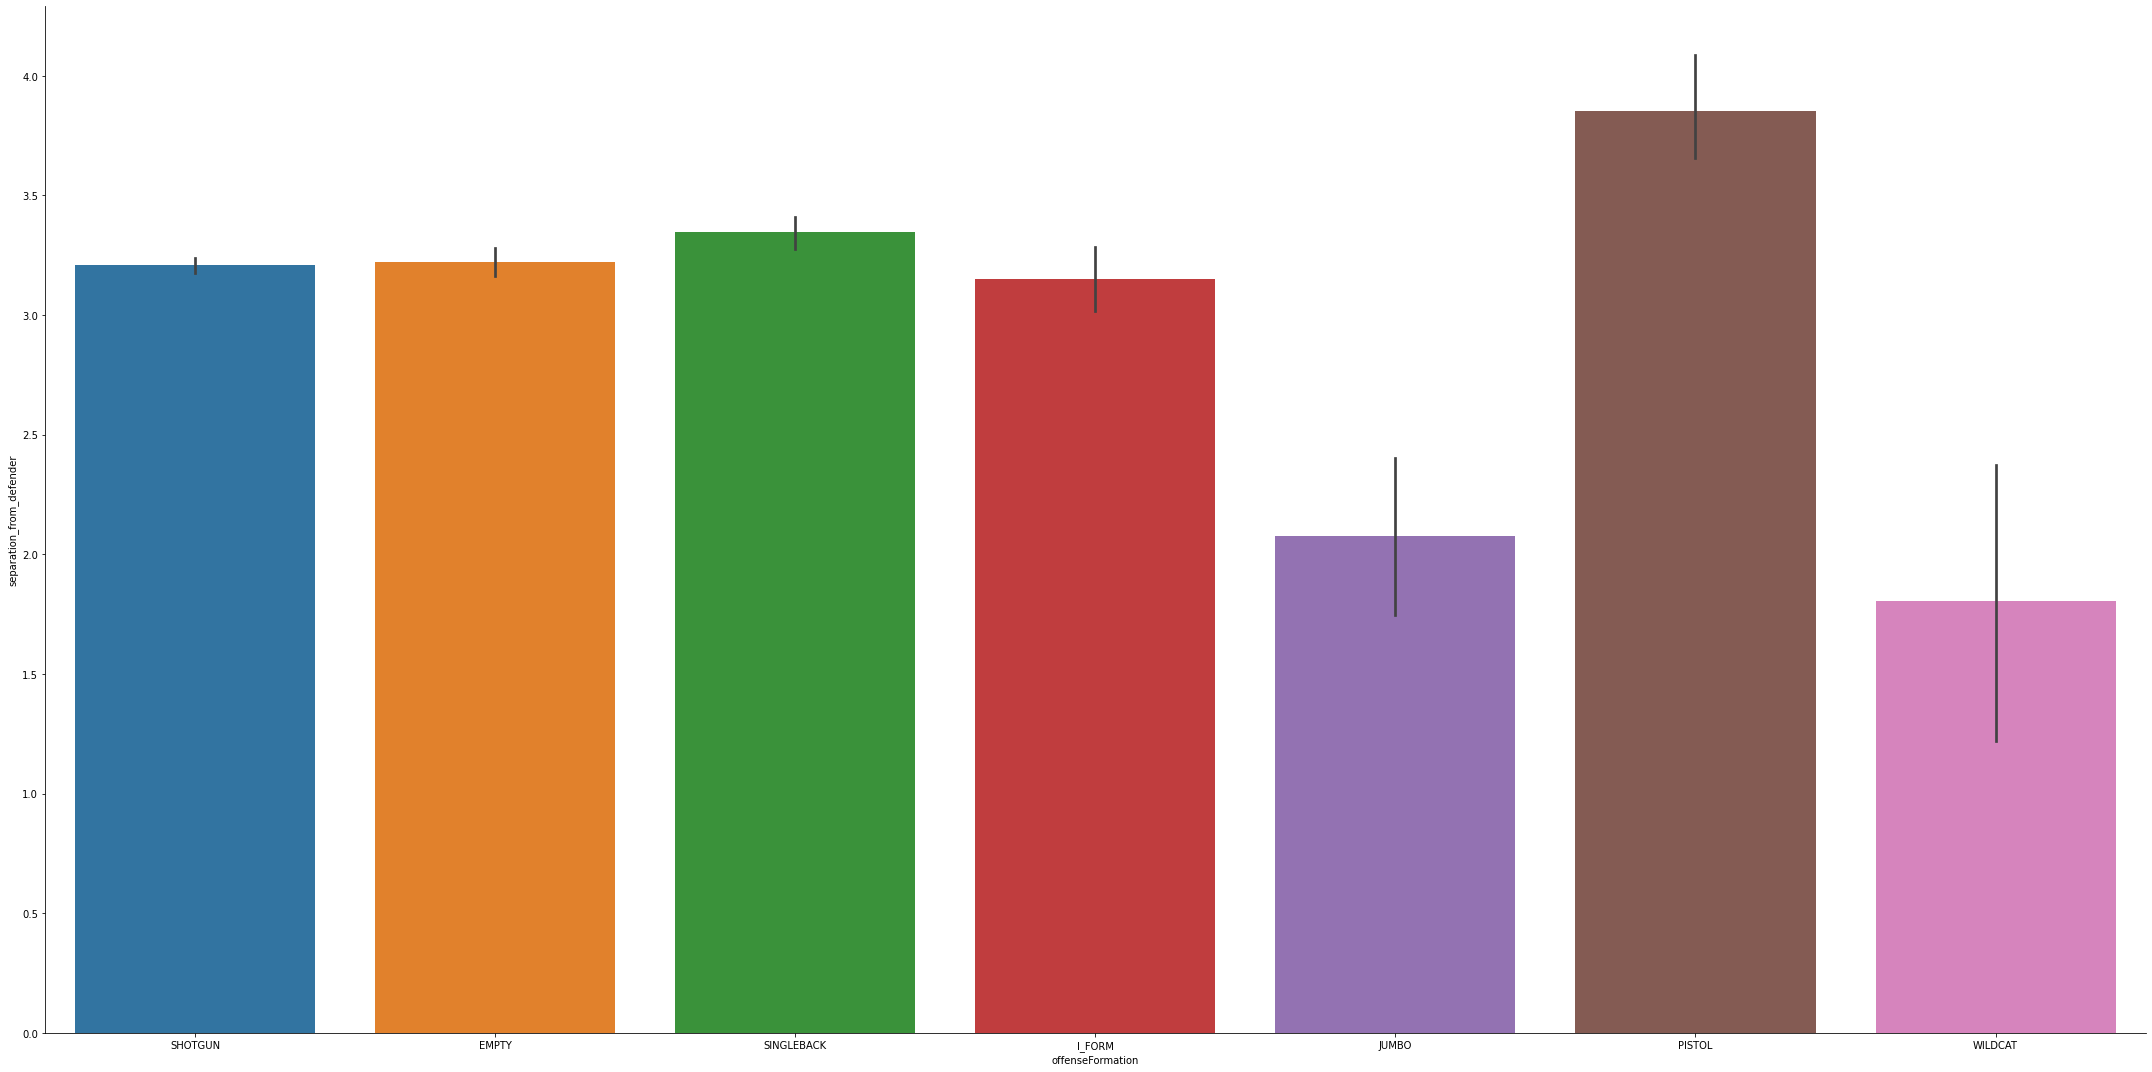

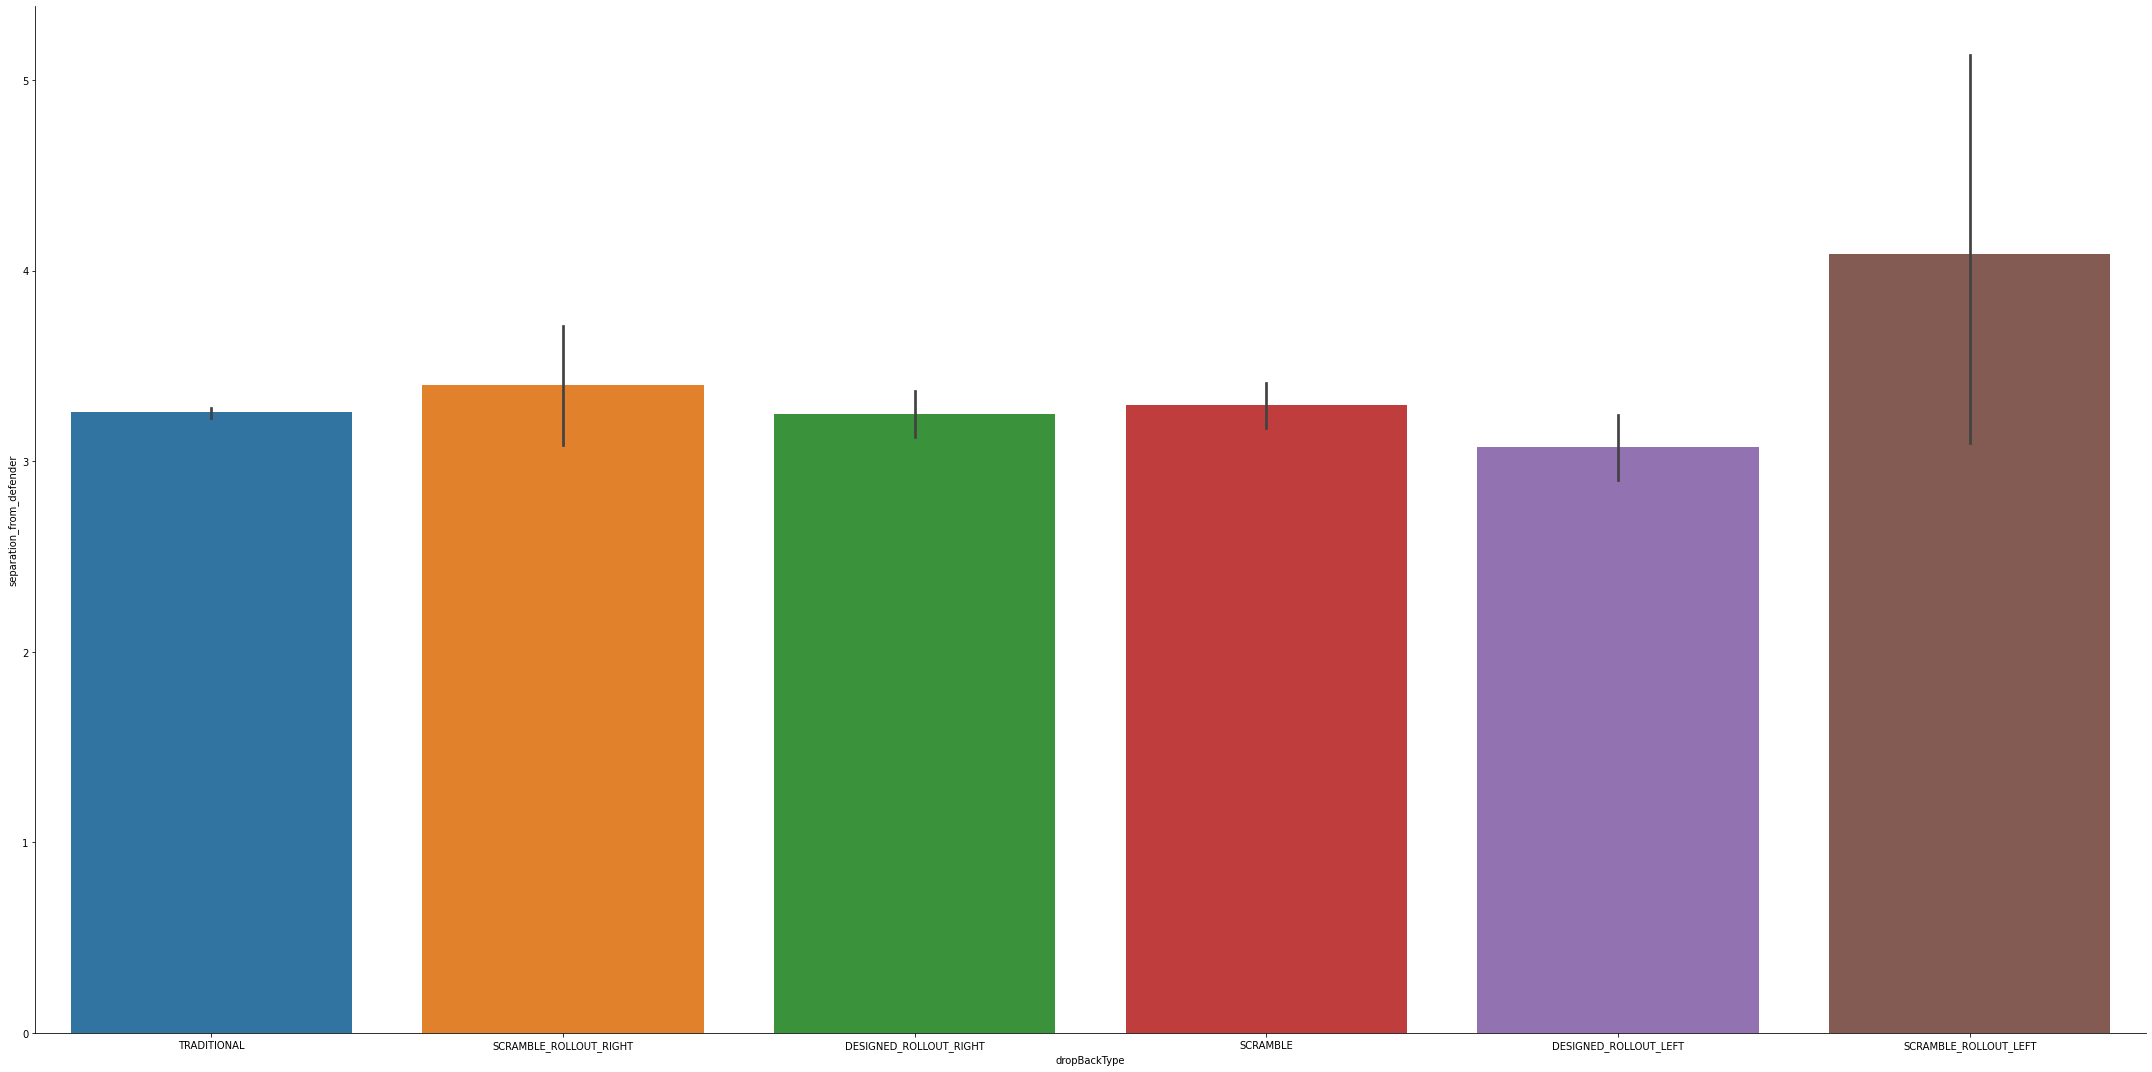

In [42]:
sns.catplot(x='offenseFormation',y='separation_from_defender',kind='bar',data=df_new_metrics, height=15, aspect=2)
sns.catplot(x='dropBackType',y='separation_from_defender',kind='bar',data=df_new_metrics, height=15, aspect=2)


In [43]:
df2 = spark.read.format("csv").option('header','true').load('Data/final_dataset')
df2.createOrReplaceTempView('final_dataset')
df_final = spark.sql("SELECT * FROM final_dataset")
df_final = df_final.toPandas()
df_final.head()

df_final.columns


columns = ['yardsToGo', 'prePenaltyPlayResult',
       'defendersInBox', 'defender_from_ball', 'receivers_count', 'o_0',
       'dir_0', 'separation_from_defender_0', 'dist_from_ball_0',
        'o_1', 'dir_1',
       'separation_from_defender_1', 'dist_from_ball_1',
        'o_2', 'dir_2',
       'separation_from_defender_2', 'dist_from_ball_2',
        'o_3', 'dir_3',
       'separation_from_defender_3', 'dist_from_ball_3',
        'o_4', 'dir_4',
       'separation_from_defender_4', 'dist_from_ball_4',
       'first_down_achieved']

for col in columns:
    df_final[col] = df_final[col].astype(float)



In [44]:
df_final.describe()


,yardsToGo,prePenaltyPlayResult,defendersInBox,defender_from_ball,receivers_count,o_0,dir_0,separation_from_defender_0,dist_from_ball_0,o_1,dir_1,separation_from_defender_1,dist_from_ball_1,o_2,dir_2,separation_from_defender_2,dist_from_ball_2,o_3,dir_3,separation_from_defender_3,dist_from_ball_3,o_4,dir_4,separation_from_defender_4,dist_from_ball_4,first_down_achieved
count,8317.000000,8317.000000,8310.000000,8317.000000,8317.000000,8317.000000,8317.000000,8317.000000,8317.000000,8314.000000,8314.000000,8314.000000,8314.000000,8247.000000,8247.000000,8247.000000,8247.000000,7602.000000,7602.000000,7602.000000,7602.000000,5909.000000,5909.000000,5909.000000,5909.000000,8317.000000
mean,8.728027,6.537333,6.023345,1.589343,4.615727,181.123048,181.035097,4.233635,10.391350,181.111473,184.383518,4.352488,10.036773,182.846521,180.117766,4.311444,9.950635,181.157852,182.213852,4.510385,10.153398,180.836471,182.532291,4.680736,10.674826,0.342311
std,3.922512,10.184161,1.005310,0.659447,0.666654,92.373429,102.042295,2.123783,4.851218,92.744243,102.726641,2.121911,4.870901,93.266345,102.526700,2.140162,4.793190,93.326531,102.538690,2.147512,4.886382,92.878986,102.001614,2.159654,4.948678,0.474512
min,0.000000,-34.000000,1.000000,0.022361,1.000000,0.280000,0.100000,0.819878,2.104305,0.510000,0.000000,0.920869,1.606393,0.100000,0.010000,0.502195,1.209669,0.130000,0.060000,0.906091,2.280351,0.190000,0.060000,1.241692,2.116247,0.000000
25%,6.000000,0.000000,5.000000,1.132784,4.000000,89.590000,90.690000,2.540315,6.388623,89.352500,93.862500,2.578905,5.961705,89.280000,90.610000,2.557118,5.940715,88.870000,92.015000,2.690465,5.997866,88.380000,93.430000,2.819645,6.354188,0.000000
50%,10.000000,4.000000,6.000000,1.450552,5.000000,220.840000,183.820000,3.520511,9.187698,215.210000,186.365000,3.743408,8.771097,226.540000,180.930000,3.654942,8.662528,222.580000,184.075000,4.016248,8.754789,222.450000,184.310000,4.262065,9.469747,0.000000
75%,10.000000,10.000000,7.000000,1.884038,5.000000,268.620000,270.350000,5.670353,13.098996,268.907500,273.827500,5.809873,12.517316,269.910000,270.835000,5.805885,12.550596,268.840000,272.627500,5.992725,12.962649,268.630000,271.850000,6.136163,13.611807,1.000000
max,39.000000,91.000000,11.000000,6.493327,5.000000,359.880000,359.980000,16.092557,25.106322,359.900000,359.980000,12.304552,23.912173,359.790000,359.920000,15.201069,24.705200,360.000000,359.920000,14.040057,25.388667,359.500000,359.950000,15.959402,25.819204,1.000000


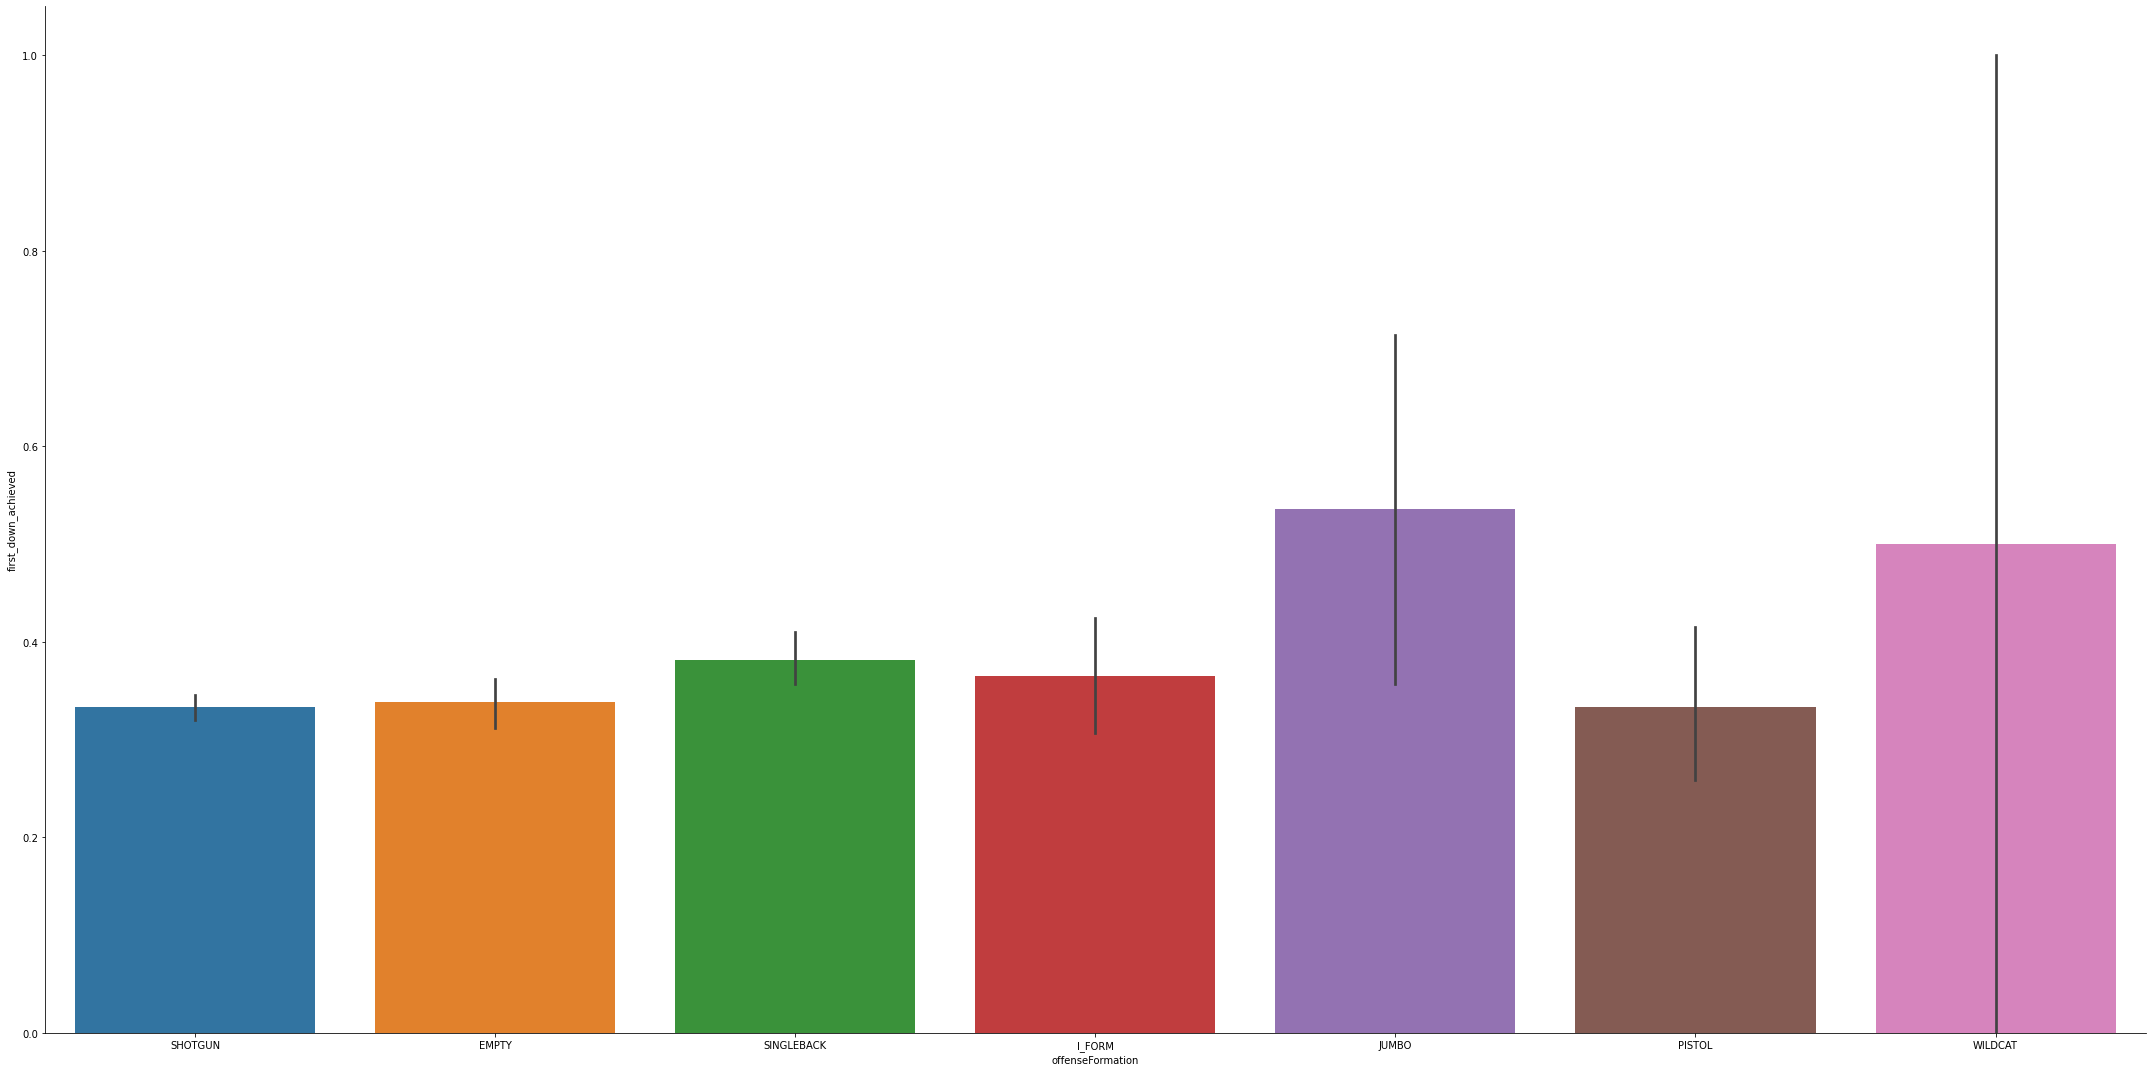

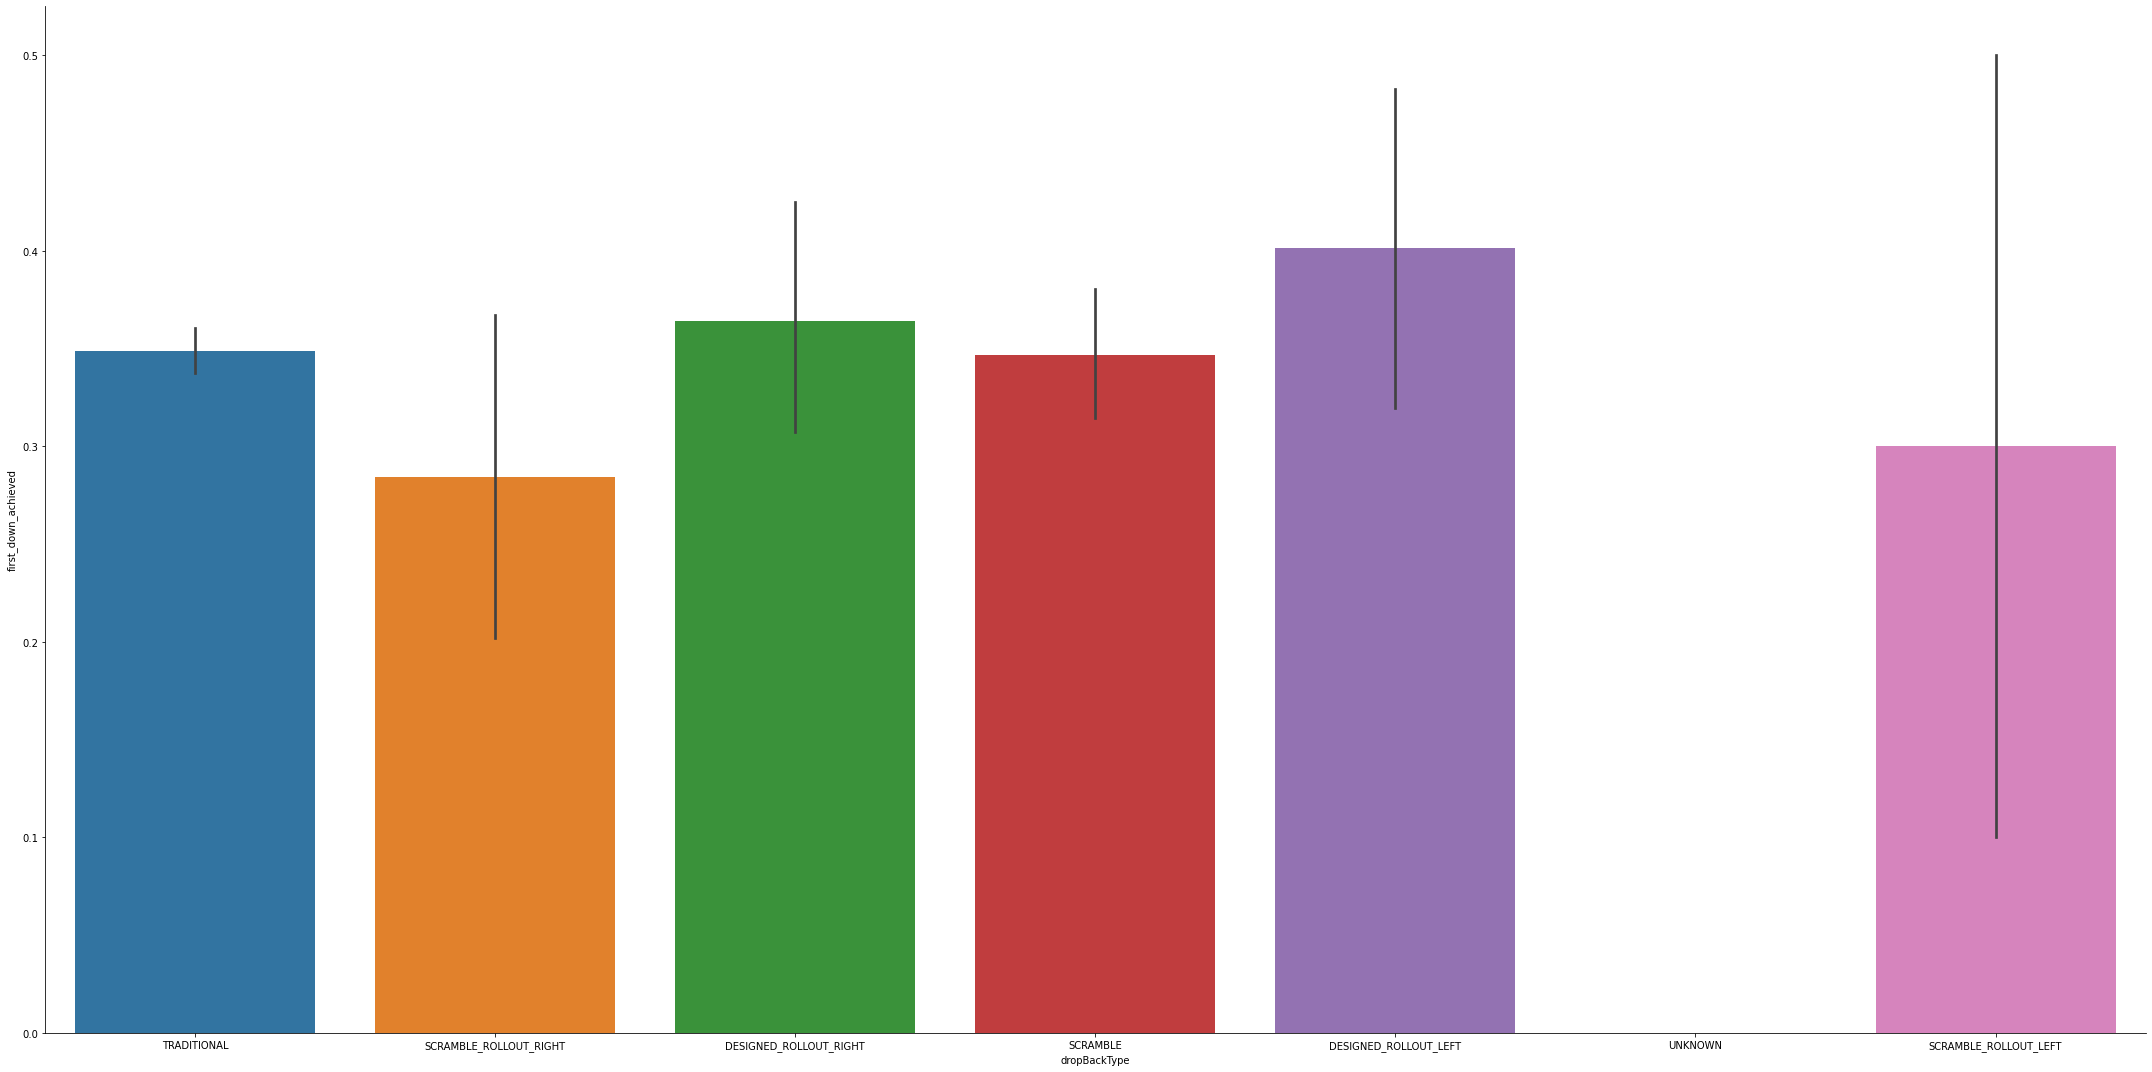

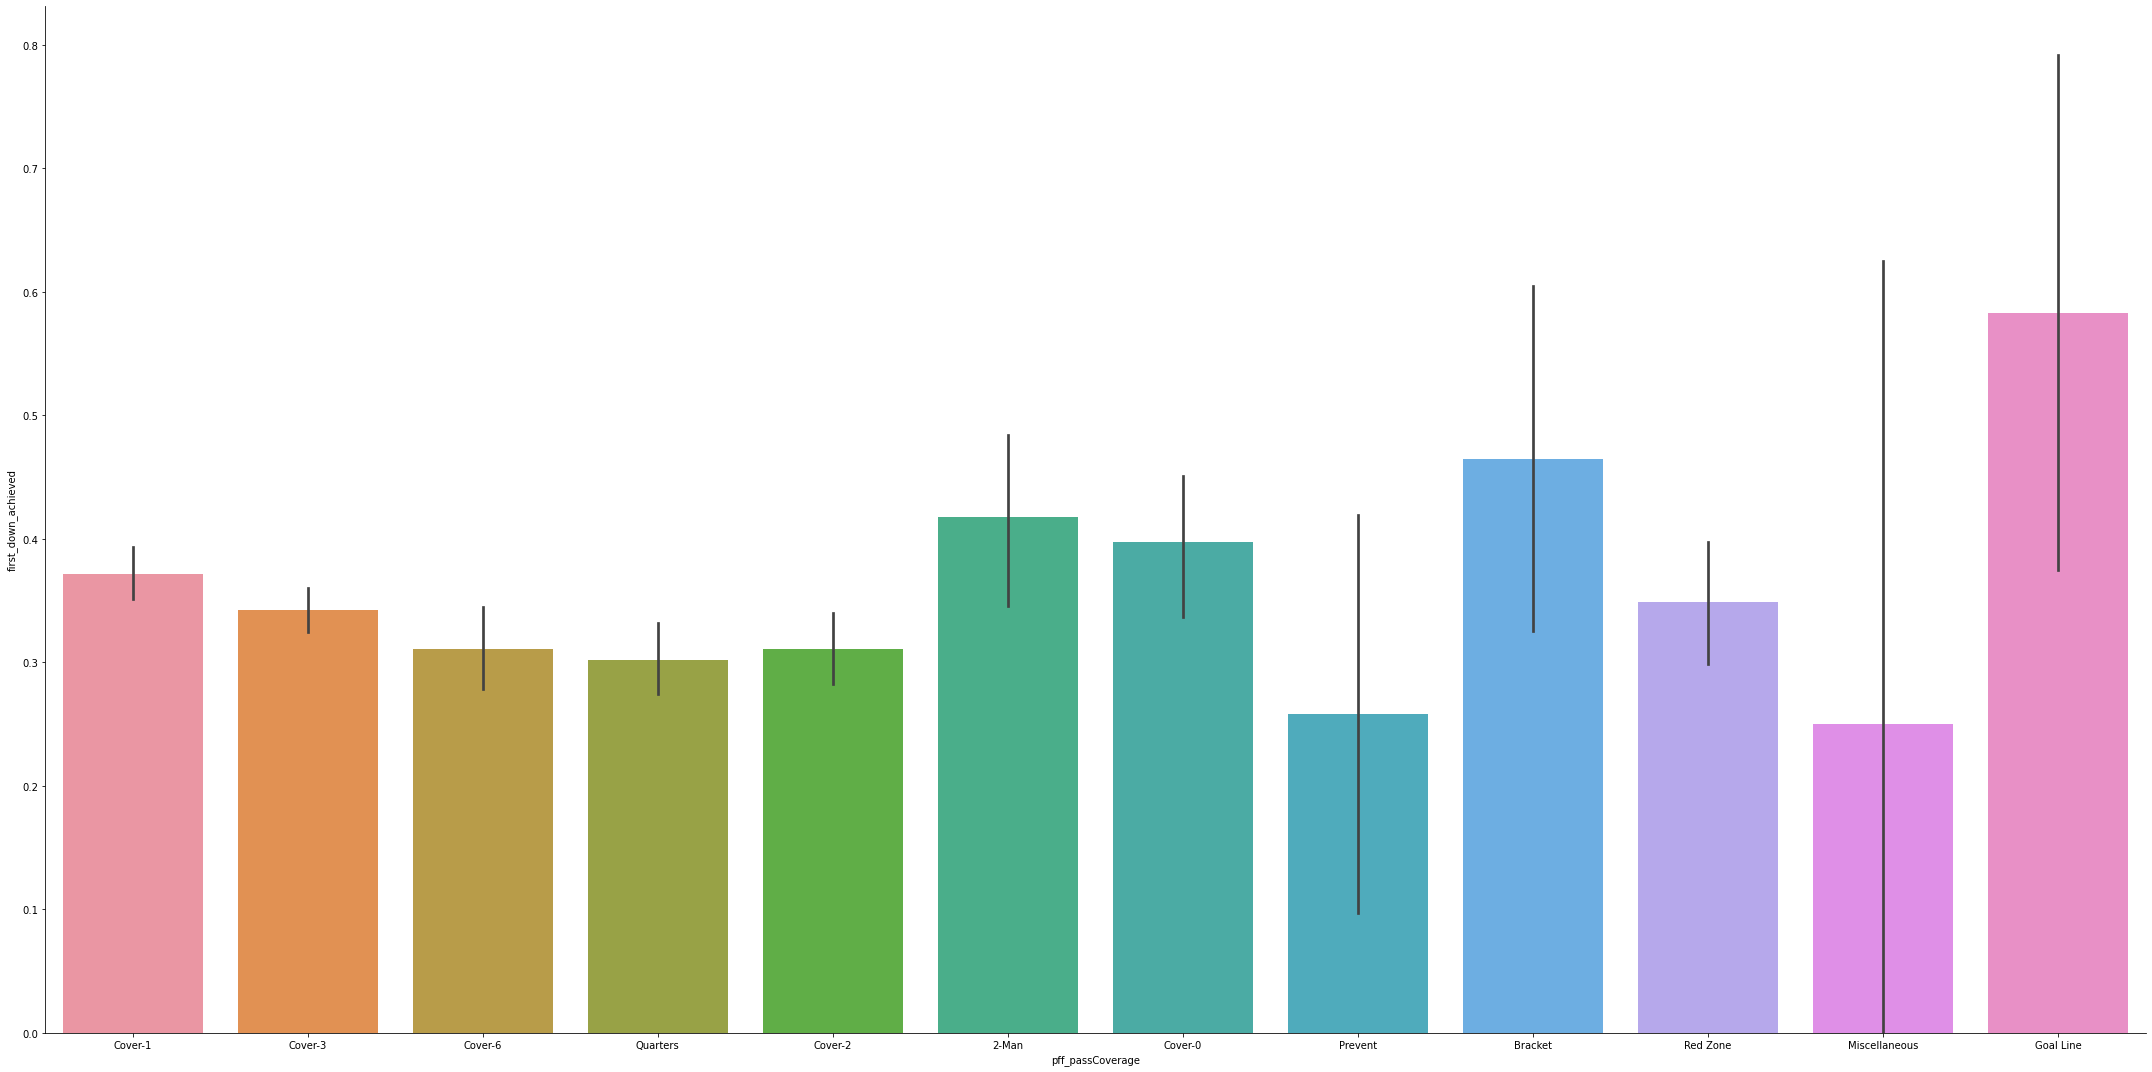

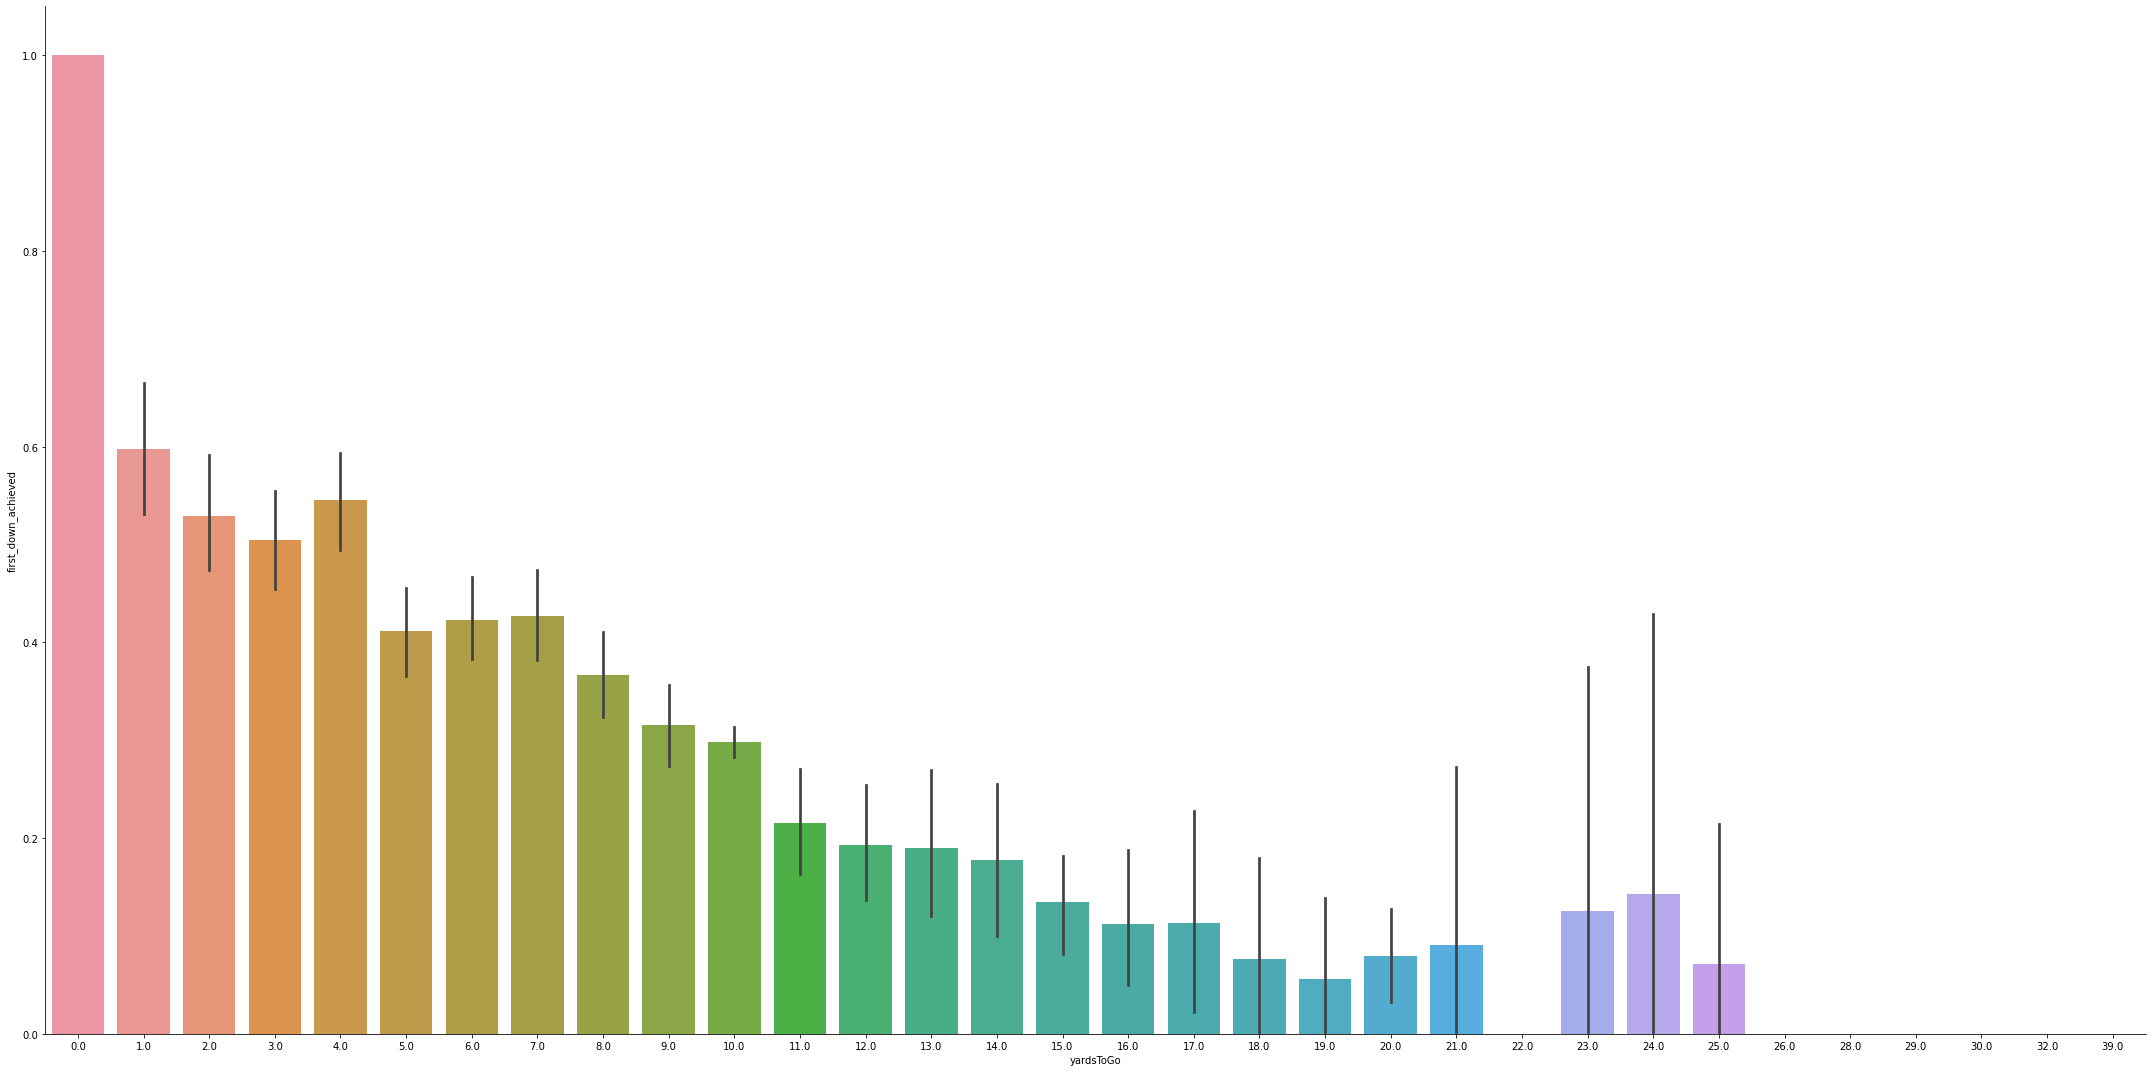

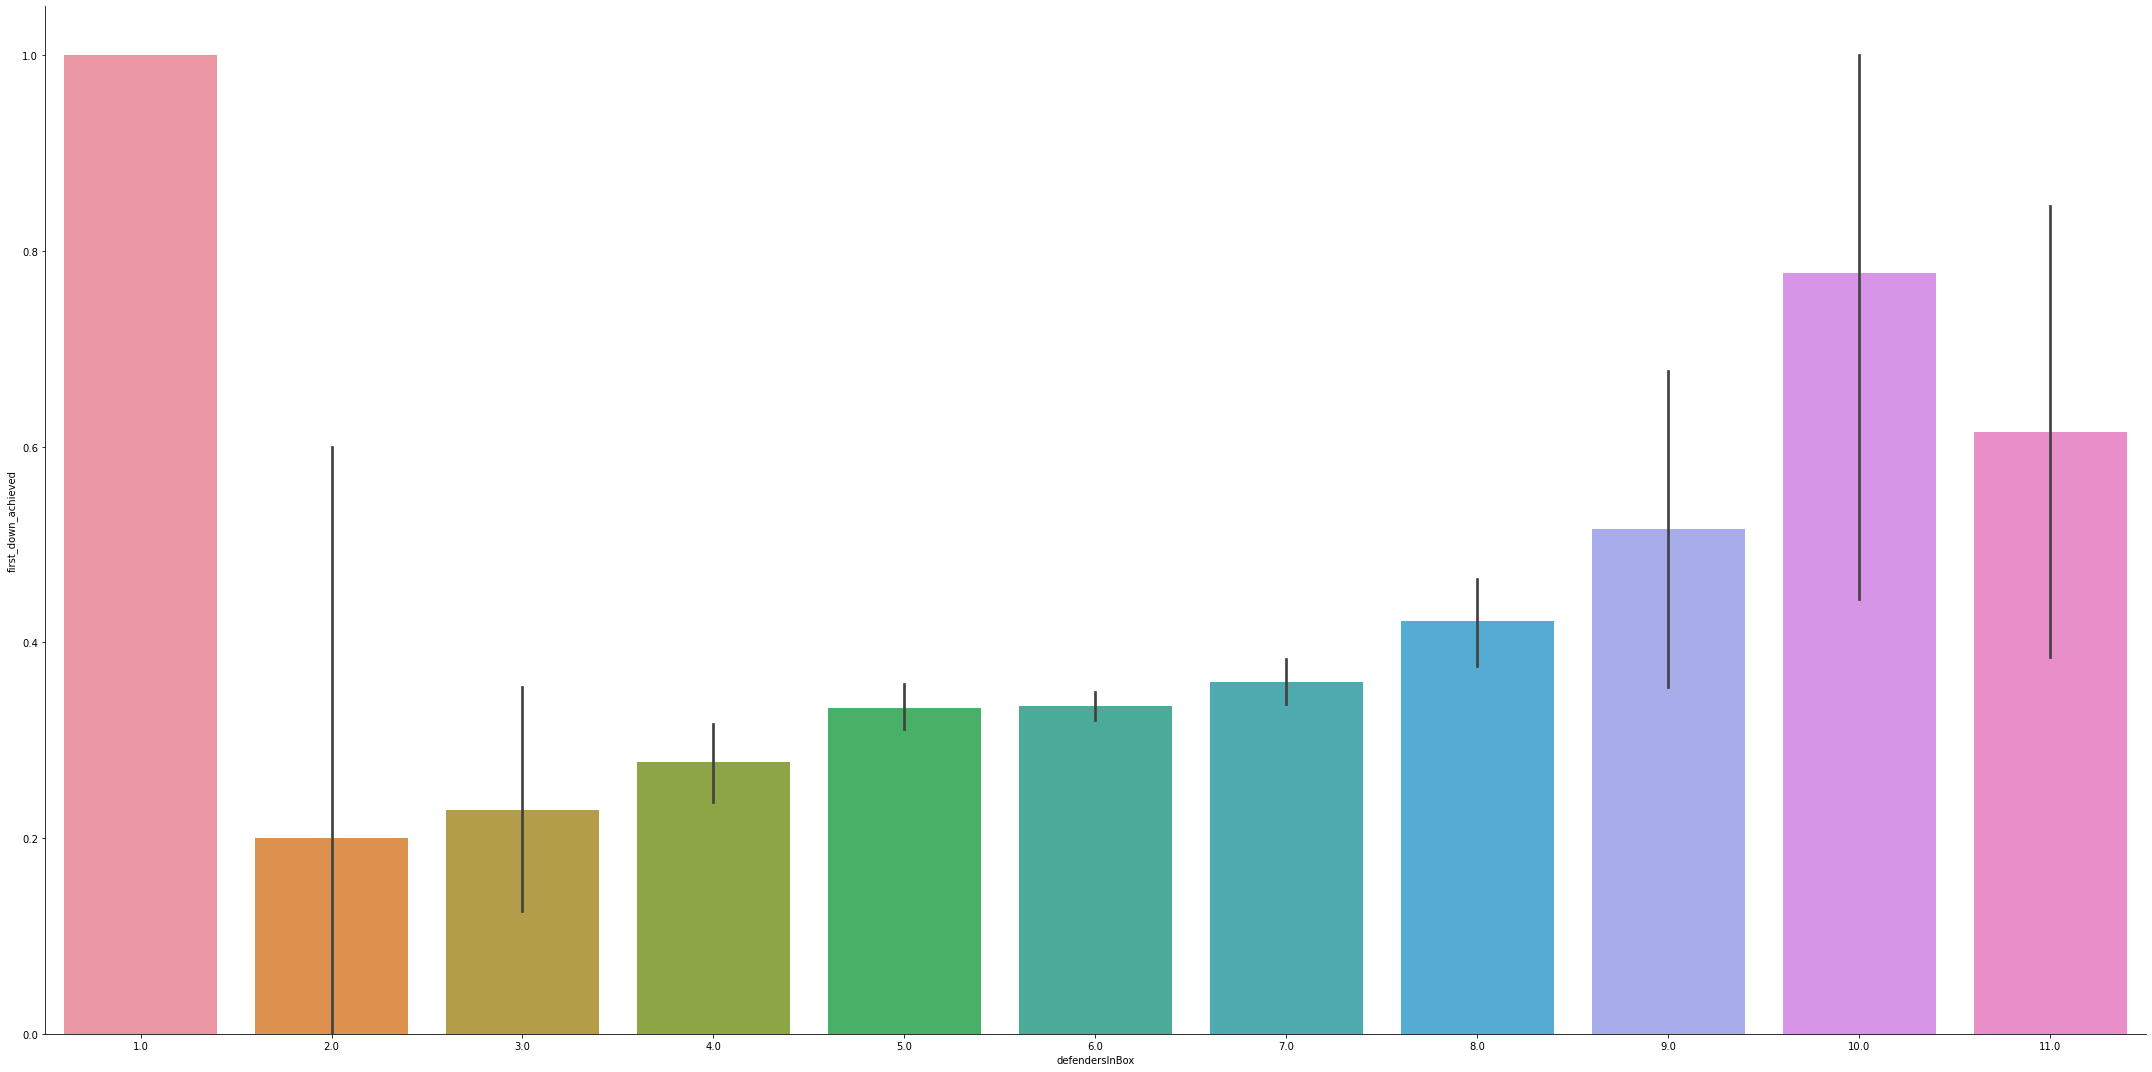

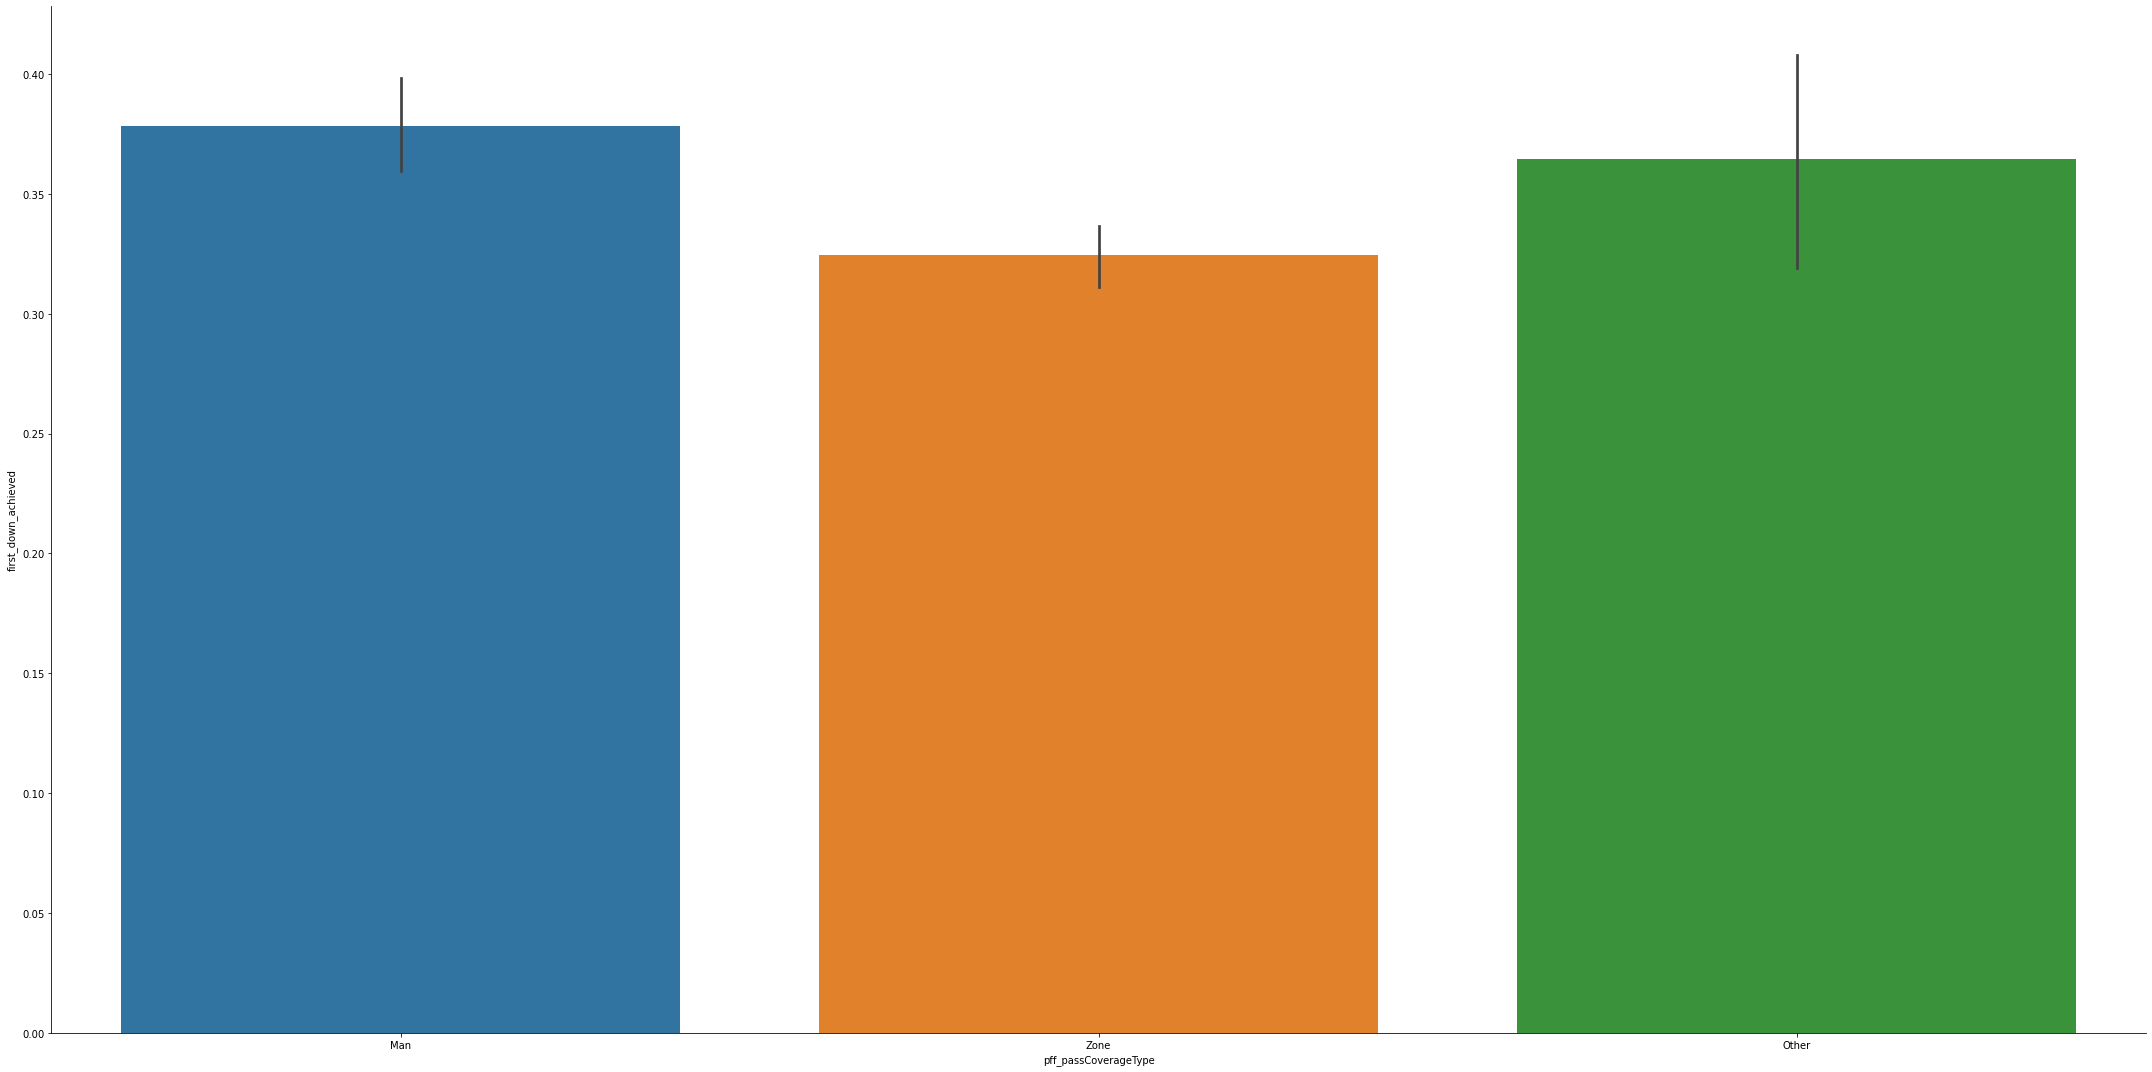

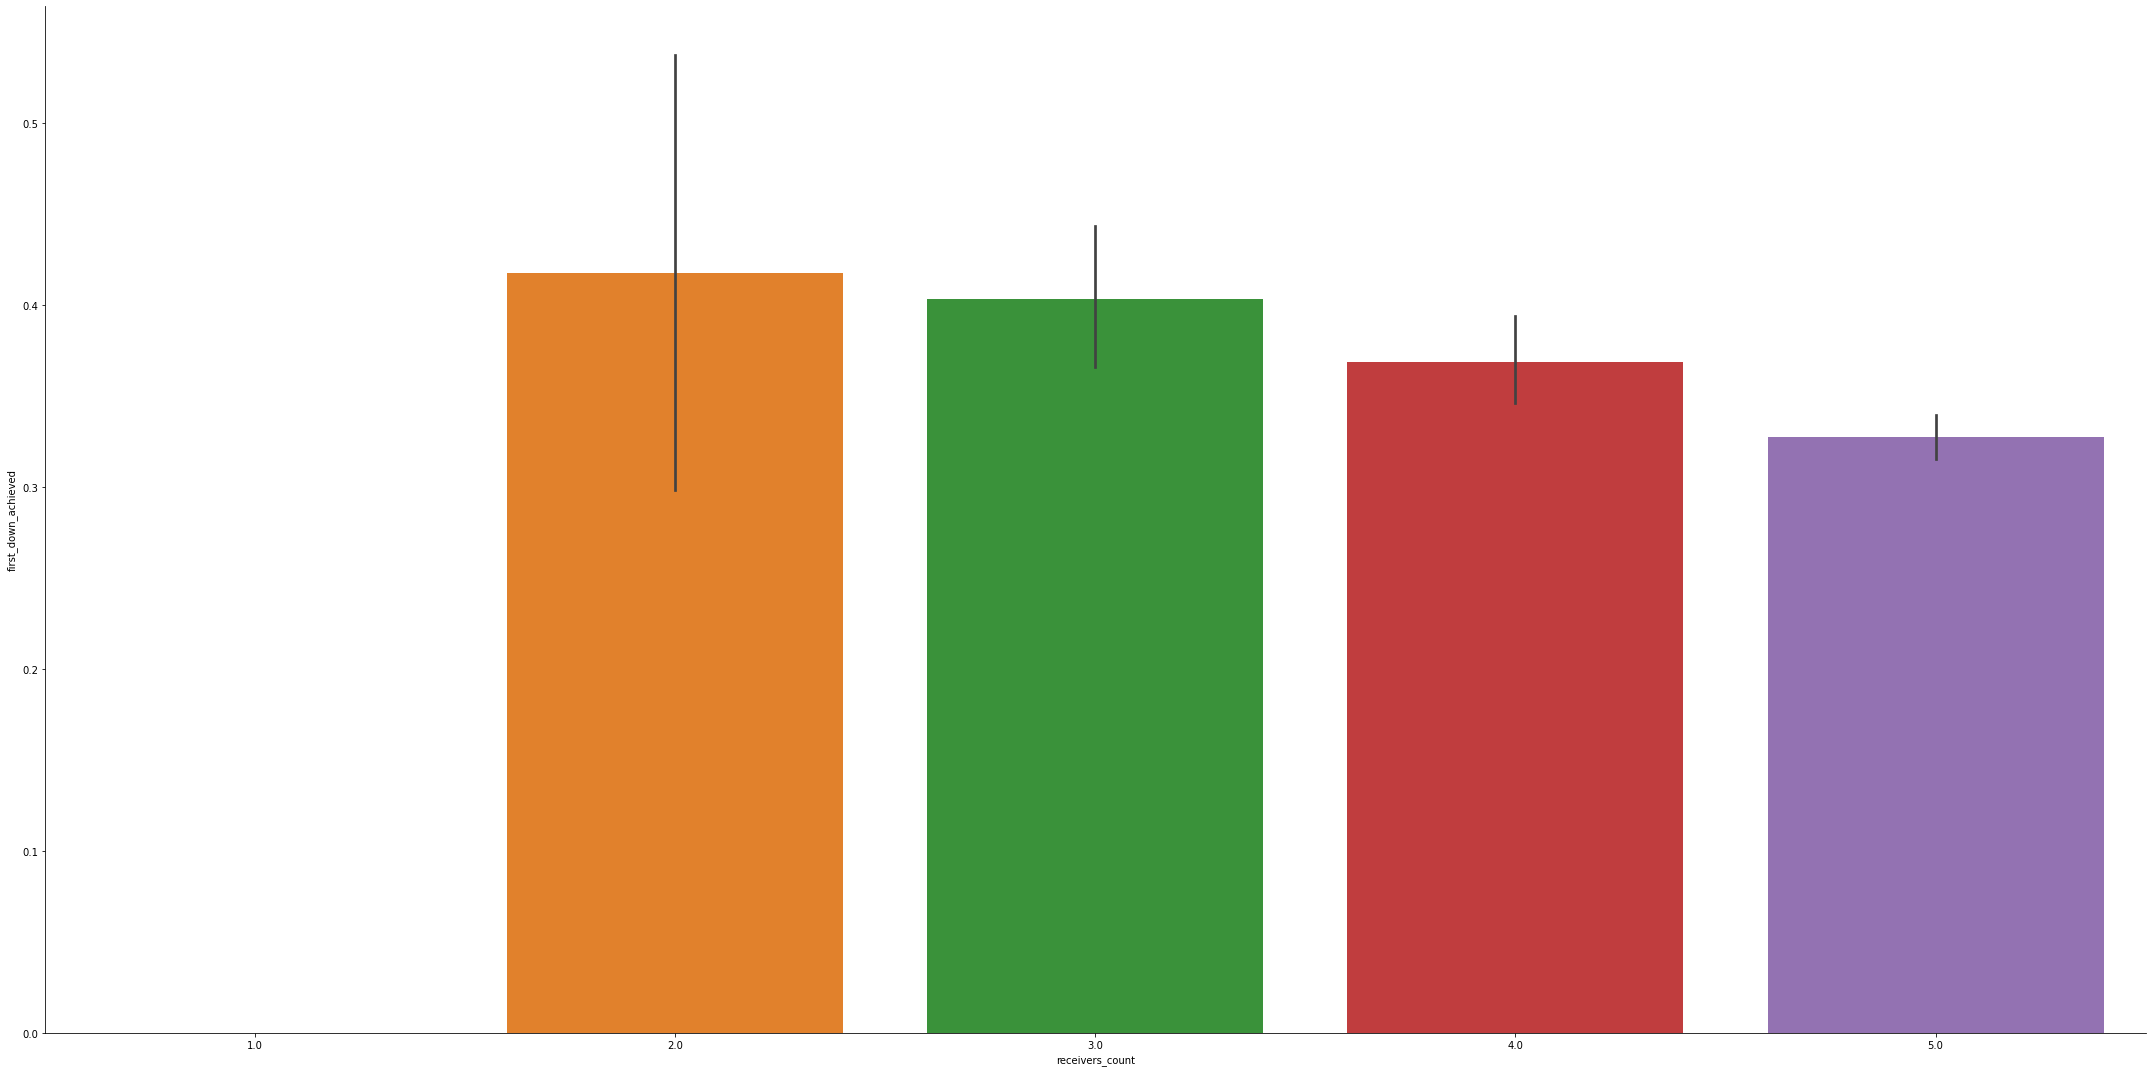

In [45]:
sns.catplot(x='offenseFormation',y='first_down_achieved',kind='bar',data=df_final, height=15, aspect=2)
sns.catplot(x='dropBackType',y='first_down_achieved',kind='bar',data=df_final, height=15, aspect=2)
sns.catplot(x='pff_passCoverage',y='first_down_achieved', kind='bar',data=df_final, height=15, aspect=2)
sns.catplot(x='yardsToGo',y='first_down_achieved', kind='bar',data=df_final, height=15, aspect=2)
sns.catplot(x='defendersInBox',y='first_down_achieved', kind='bar',data=df_final, height=15, aspect=2)
sns.catplot(x='pff_passCoverageType',y='first_down_achieved', kind='bar',data=df_final, height=15, aspect=2)
sns.catplot(x='receivers_count',y='first_down_achieved', kind='bar',data=df_final, height=15, aspect=2)


In [ ]:
sns.catplot(x='offenseFormation',y='first_down_achieved',kind='bar',data=df_new_metrics, height=15, aspect=2)
sns.catplot(x='dropBackType',y='first_down_achieved',kind='bar',data=df_new_metrics, height=15, aspect=2)
sns.catplot(x='pff_passCoverage',y='first_down_achieved', kind='bar',data=df_new_metrics, height=15, aspect=2)
sns.catplot(x='yardsToGo',y='first_down_achieved', kind='bar',data=df_new_metrics, height=15, aspect=2)
sns.catplot(x='defendersInBox',y='first_down_achieved', kind='bar',data=df_new_metrics, height=15, aspect=2)
sns.catplot(x='pff_passCoverageType',y='first_down_achieved', kind='bar',data=df_new_metrics, height=15, aspect=2)
# sns.catplot(x='receivers_count',y='first_down_achieved', kind='bar',data=df_new_metrics, height=15, aspect=2)


## Conclusion

There was plenty of insightful information I gained from this analysis. I will be using this data to set up the pre-processing step of the machine learning process. Some insights include:

1. Running Singleback or Pistol offensive formation leads to a higher average yards gained result vs running Jumbo or wildcat formation
2. When there are 9,10, or 11 defenders in the box, the average pass result is significantly lower
3. Offensive linemen using UP block allow for more passing yards on average vs offensinve linemen using any other block type
4. There are no significantly strong relationships (negative or positive) among the different features within this dataset. 
5. When the offense is using Wildcat formation, on average, the defense puts the least amount of defenders in the box. But when the offense is using JUMBO formation, one average, defense puts the most amount of defenders in the box.
6. Singleback and Pistol formation have the highest average yards gained per play
7. There is no relationship between yards gained and the length of a play - has a p-value significantly lower than 0.05
8. On average, the more yards needed to gain for first down, the lower the number of defenders that'll be in the box